In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torch.optim import LBFGS
from tqdm import tqdm

from util import *
from model.pinn import PINNs
from model.pinnsformer import PINNsformer

from sketchysgd import SketchySGD

In [3]:
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

device = 'cuda:1'

In [4]:
# Train PINNsformer
res, b_left, b_right, b_upper, b_lower = get_data([0,2*np.pi], [0,1], 51, 51)
res_test, _, _, _, _ = get_data([0,2*np.pi], [0,1], 101, 101)

res = make_time_sequence(res, num_step=5, step=1e-4)
b_left = make_time_sequence(b_left, num_step=5, step=1e-4)
b_right = make_time_sequence(b_right, num_step=5, step=1e-4)
b_upper = make_time_sequence(b_upper, num_step=5, step=1e-4)
b_lower = make_time_sequence(b_lower, num_step=5, step=1e-4)

res = torch.tensor(res, dtype=torch.float32, requires_grad=True).to(device)
b_left = torch.tensor(b_left, dtype=torch.float32, requires_grad=True).to(device)
b_right = torch.tensor(b_right, dtype=torch.float32, requires_grad=True).to(device)
b_upper = torch.tensor(b_upper, dtype=torch.float32, requires_grad=True).to(device)
b_lower = torch.tensor(b_lower, dtype=torch.float32, requires_grad=True).to(device)

x_res, t_res = res[:,:,0:1], res[:,:,1:2]
x_left, t_left = b_left[:,:,0:1], b_left[:,:,1:2]
x_right, t_right = b_right[:,:,0:1], b_right[:,:,1:2]
x_upper, t_upper = b_upper[:,:,0:1], b_upper[:,:,1:2]
x_lower, t_lower = b_lower[:,:,0:1], b_lower[:,:,1:2]

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [5]:
model = PINNsformer(d_out=1, d_hidden=512, d_model=32, N=1, heads=2).to(device)

model.apply(init_weights)

# print(model)
# print(get_n_params(model))

/tmp/ipykernel_2457311/1725142899.py:25: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


PINNsformer(
  (linear_emb): Linear(in_features=2, out_features=32, bias=True)
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (ff): FeedForward(
          (linear): Sequential(
            (0): Linear(in_features=32, out_features=256, bias=True)
            (1): WaveAct()
            (2): Linear(in_features=256, out_features=256, bias=True)
            (3): WaveAct()
            (4): Linear(in_features=256, out_features=32, bias=True)
          )
        )
        (act1): WaveAct()
        (act2): WaveAct()
      )
    )
    (act): WaveAct()
  )
  (decoder): Decoder(
    (layers): ModuleList(
      (0): DecoderLayer(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (ff): FeedForward(
          (linear): Sequen

In [6]:
# optim = LBFGS(model.parameters(), line_search_fn='strong_wolfe')
optim = SketchySGD(model.parameters(), rank=30, rho=1e0, lr=1e2, 
                    hes_update_freq=10, line_search_fn='backtracking', verbose=True)

In [7]:
loss_track = []
step_size_track = []
n_iters = 1000

for i in tqdm(range(n_iters)):
    def closure():
        pred_res = model(x_res, t_res)
        pred_left = model(x_left, t_left)
        pred_right = model(x_right, t_right)
        pred_upper = model(x_upper, t_upper)
        pred_lower = model(x_lower, t_lower)

        u_x = torch.autograd.grad(pred_res, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
        u_t = torch.autograd.grad(pred_res, t_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]

        loss_res = torch.mean((u_t - 5 * pred_res * (1-pred_res)) ** 2)
        loss_bc = torch.mean((pred_upper - pred_lower) ** 2)
        loss_ic = torch.mean((pred_left[:,0] - torch.exp(- (x_left[:,0] - torch.pi)**2 / (2*(torch.pi/4)**2))) ** 2)

        loss_track.append([loss_res.item(), loss_bc.item(), loss_ic.item()])

        loss = loss_res + loss_bc + loss_ic        
        optim.zero_grad()

        if isinstance(optim, SketchySGD): 
            grad_tuple = torch.autograd.grad(loss, model.parameters(), create_graph=True)
            return loss, grad_tuple   
        loss.backward()
        return loss

    optim.step(closure)

    if isinstance(optim, SketchySGD): 
        cur_step_size = optim.state_dict()['state'][0]['step_size']
        step_size_track.append(cur_step_size)

  0%|          | 0/1000 [00:00<?, ?it/s]

SketchySGD: chunk size has been set to 6.
Shift = 1.6462070941925049
Eigenvalues = tensor([1.1921e-07, 2.6508e-01, 4.0059e-01, 5.7612e-01, 7.3293e-01, 8.5304e-01,
        1.0580e+00, 1.1212e+00, 1.1757e+00, 1.3735e+00, 1.4124e+00, 1.4427e+00,
        1.5559e+00, 1.6150e+00, 1.7196e+00, 1.7805e+00, 1.9052e+00, 1.9682e+00,
        2.1017e+00, 2.1907e+00, 2.2513e+00, 2.3879e+00, 2.4517e+00, 2.5656e+00,
        2.7681e+00, 2.8545e+00, 3.0210e+00, 3.4430e+00, 4.2153e+00, 2.2702e+01],
       device='cuda:1')
Approximate eigenvalues = tensor([1.4762e+11, 3.4107e+05, 5.8834e+04, 3.1737e+04, 2.4673e+04, 1.8652e+04,
        1.7170e+04, 1.4825e+04, 1.3371e+04, 1.0638e+04, 9.2555e+03, 8.6530e+03,
        8.0459e+03, 7.5826e+03, 7.1371e+03, 6.3023e+03, 5.9612e+03, 5.7354e+03,
        5.6089e+03, 5.1332e+03, 4.9270e+03, 4.6812e+03, 4.4638e+03, 4.2109e+03,
        4.1061e+03, 4.0022e+03, 3.5278e+03, 3.4249e+03, 3.2763e+03, 3.0074e+03],
       device='cuda:1')
Norm of g = 2151.836669921875
Norm of g_n

  0%|          | 1/1000 [00:16<4:38:14, 16.71s/it]

Norm of g = 670.0632934570312
Norm of g_new = 447.8498840332031
Cosine similarity between g and g_new = 0.6683874726295471


  0%|          | 2/1000 [00:18<2:07:30,  7.67s/it]

Norm of g = 598.089599609375
Norm of g_new = 586.8668823242188
Cosine similarity between g and g_new = 0.9812405705451965


  0%|          | 3/1000 [00:20<1:24:03,  5.06s/it]

Norm of g = 312.3526611328125
Norm of g_new = 309.223388671875
Cosine similarity between g and g_new = 0.9899845719337463


  0%|          | 4/1000 [00:21<1:01:49,  3.72s/it]

Norm of g = 293.3717041015625
Norm of g_new = 288.7826232910156
Cosine similarity between g and g_new = 0.9843621253967285


  0%|          | 5/1000 [00:23<49:40,  3.00s/it]  

Norm of g = 49.95882034301758
Norm of g_new = 49.31721115112305
Cosine similarity between g and g_new = 0.9871616959571838


  1%|          | 6/1000 [00:25<45:28,  2.74s/it]

Norm of g = 70.5183334350586
Norm of g_new = 69.50896453857422
Cosine similarity between g and g_new = 0.985690712928772


  1%|          | 7/1000 [00:27<42:39,  2.58s/it]

Norm of g = 31.01280975341797
Norm of g_new = 30.74713134765625
Cosine similarity between g and g_new = 0.9914361238479614


  1%|          | 8/1000 [00:30<40:27,  2.45s/it]

Norm of g = 39.09602737426758
Norm of g_new = 38.65073776245117
Cosine similarity between g and g_new = 0.9886136651039124


  1%|          | 9/1000 [00:32<39:08,  2.37s/it]

Norm of g = 50.75790023803711
Norm of g_new = 50.08510971069336
Cosine similarity between g and g_new = 0.9867491722106934


  1%|          | 10/1000 [00:34<38:09,  2.31s/it]

Shift = 0.04262630268931389
Eigenvalues = tensor([1.1921e-07, 1.0795e-02, 2.0434e-02, 2.8112e-02, 3.1922e-02, 3.3261e-02,
        3.3962e-02, 3.5740e-02, 3.7468e-02, 3.8679e-02, 3.9121e-02, 4.0653e-02,
        4.1750e-02, 4.2773e-02, 4.3569e-02, 4.4728e-02, 4.5504e-02, 4.6767e-02,
        4.8742e-02, 5.0053e-02, 5.0995e-02, 5.2035e-02, 5.4578e-02, 5.7511e-02,
        6.1123e-02, 6.7545e-02, 7.2192e-02, 7.7292e-02, 1.2159e-01, 1.2272e+01],
       device='cuda:1')
Approximate eigenvalues = tensor([2.9062e+08, 1.3288e+05, 1.7966e+03, 7.3703e+02, 4.3536e+02, 2.5785e+02,
        1.4720e+02, 1.2251e+02, 1.1399e+02, 9.2772e+01, 7.6501e+01, 6.9066e+01,
        6.2489e+01, 5.5955e+01, 4.5546e+01, 4.0750e+01, 3.9544e+01, 3.3707e+01,
        2.9694e+01, 2.7667e+01, 2.1858e+01, 2.1471e+01, 2.0389e+01, 1.9079e+01,
        1.7589e+01, 1.7331e+01, 1.5204e+01, 1.3772e+01, 1.2292e+01, 1.2040e+01],
       device='cuda:1')
Norm of g = 75.87145233154297
Norm of g_new = 4.879181385040283
Cosine similarity 

  1%|          | 11/1000 [00:38<45:54,  2.79s/it]

Norm of g = 203.85423278808594
Norm of g_new = 23.665714263916016
Cosine similarity between g and g_new = 0.11856291443109512


  1%|          | 12/1000 [00:39<37:50,  2.30s/it]

Norm of g = 64.26581573486328
Norm of g_new = 36.26891326904297
Cosine similarity between g and g_new = 0.569908618927002


  1%|▏         | 13/1000 [00:41<35:30,  2.16s/it]

Norm of g = 10.6847562789917
Norm of g_new = 8.47553825378418
Cosine similarity between g and g_new = 0.797900915145874


  1%|▏         | 14/1000 [00:42<32:43,  1.99s/it]

Norm of g = 28.48979949951172
Norm of g_new = 18.329307556152344
Cosine similarity between g and g_new = 0.6490697264671326


  2%|▏         | 15/1000 [00:44<31:20,  1.91s/it]

Norm of g = 21.34705924987793
Norm of g_new = 14.09067153930664
Cosine similarity between g and g_new = 0.6663890480995178


  2%|▏         | 16/1000 [00:46<30:31,  1.86s/it]

Norm of g = 14.81052303314209
Norm of g_new = 9.61094856262207
Cosine similarity between g and g_new = 0.6541051864624023


  2%|▏         | 17/1000 [00:47<25:33,  1.56s/it]

Norm of g = 20.176651000976562
Norm of g_new = 19.530975341796875
Cosine similarity between g and g_new = 0.9686951041221619


  2%|▏         | 18/1000 [00:49<27:13,  1.66s/it]

Norm of g = 17.171783447265625
Norm of g_new = 16.66626739501953
Cosine similarity between g and g_new = 0.9712525010108948


  2%|▏         | 19/1000 [00:51<28:14,  1.73s/it]

Norm of g = 15.230644226074219
Norm of g_new = 14.740334510803223
Cosine similarity between g and g_new = 0.9685041308403015


  2%|▏         | 20/1000 [00:53<29:29,  1.81s/it]

Shift = 0.012460632249712944
Eigenvalues = tensor([1.1921e-07, 8.9423e-03, 9.1137e-03, 1.0227e-02, 1.0498e-02, 1.0661e-02,
        1.0892e-02, 1.0984e-02, 1.1222e-02, 1.1423e-02, 1.1634e-02, 1.1832e-02,
        1.2117e-02, 1.2184e-02, 1.2525e-02, 1.2687e-02, 1.2696e-02, 1.2836e-02,
        1.3279e-02, 1.3700e-02, 1.3766e-02, 1.4032e-02, 1.4110e-02, 1.4455e-02,
        1.4816e-02, 1.5296e-02, 1.5351e-02, 1.6052e-02, 1.8375e-02, 1.2031e+00],
       device='cuda:1')
Approximate eigenvalues = tensor([1.6267e+07, 2.1331e+04, 2.3453e+01, 1.7356e+01, 1.3081e+01, 9.2784e+00,
        7.8520e+00, 6.3135e+00, 5.4391e+00, 4.8710e+00, 4.6607e+00, 4.3073e+00,
        4.2146e+00, 3.9226e+00, 3.6856e+00, 3.4470e+00, 3.3033e+00, 3.0601e+00,
        2.8202e+00, 2.7250e+00, 2.6135e+00, 2.4224e+00, 2.2222e+00, 2.1137e+00,
        1.9139e+00, 1.8458e+00, 1.6361e+00, 1.6227e+00, 1.5740e+00, 1.4684e+00],
       device='cuda:1')
Norm of g = 13.099113464355469
Norm of g_new = 0.234003484249115
Cosine similarit

  2%|▏         | 21/1000 [00:56<37:27,  2.30s/it]

Norm of g = 1.3387185335159302
Norm of g_new = 0.1330879181623459
Cosine similarity between g and g_new = 0.10548878461122513


  2%|▏         | 22/1000 [00:57<30:41,  1.88s/it]

Norm of g = 7.911187171936035
Norm of g_new = 0.30567389726638794
Cosine similarity between g and g_new = 0.044558800756931305


  2%|▏         | 23/1000 [00:58<27:47,  1.71s/it]

Norm of g = 3.6330456733703613
Norm of g_new = 0.20175309479236603
Cosine similarity between g and g_new = 0.05858142673969269


  2%|▏         | 24/1000 [00:59<25:35,  1.57s/it]

Norm of g = 2.51513671875
Norm of g_new = 0.09480733424425125
Cosine similarity between g and g_new = 0.04177163541316986


  2%|▎         | 25/1000 [01:00<21:51,  1.34s/it]

Norm of g = 2.5242438316345215
Norm of g_new = 0.4789313077926636
Cosine similarity between g and g_new = 0.19487255811691284


  3%|▎         | 26/1000 [01:02<23:02,  1.42s/it]

Norm of g = 4.988799095153809
Norm of g_new = 0.6050819754600525
Cosine similarity between g and g_new = 0.12790584564208984


  3%|▎         | 27/1000 [01:04<24:34,  1.51s/it]

Norm of g = 3.7563536167144775
Norm of g_new = 0.43636754155158997
Cosine similarity between g and g_new = 0.12212567776441574


  3%|▎         | 28/1000 [01:05<25:35,  1.58s/it]

Norm of g = 2.43635630607605
Norm of g_new = 0.3182387351989746
Cosine similarity between g and g_new = 0.13692794740200043


  3%|▎         | 29/1000 [01:07<25:45,  1.59s/it]

Norm of g = 1.8125004768371582
Norm of g_new = 0.23822057247161865
Cosine similarity between g and g_new = 0.13706153631210327


  3%|▎         | 30/1000 [01:09<26:05,  1.61s/it]

Shift = 0.00035915806074626744
Eigenvalues = tensor([1.1921e-07, 9.8941e-05, 1.4863e-04, 1.7363e-04, 2.0112e-04, 2.1989e-04,
        2.6662e-04, 2.8102e-04, 2.9937e-04, 3.3445e-04, 3.3749e-04, 3.6437e-04,
        3.8002e-04, 3.9574e-04, 4.2388e-04, 4.5849e-04, 5.0761e-04, 5.1351e-04,
        5.2071e-04, 5.6767e-04, 5.7809e-04, 6.2808e-04, 6.8375e-04, 7.5828e-04,
        8.8777e-04, 1.2703e-03, 1.5630e-03, 2.8925e-03, 3.9318e-03, 7.7073e-01],
       device='cuda:1')
Approximate eigenvalues = tensor([2.3137e+04, 1.4280e+04, 4.3890e+01, 3.8353e+01, 1.9047e+01, 1.0387e+01,
        7.7763e+00, 6.7107e+00, 4.3503e+00, 3.6939e+00, 3.0544e+00, 2.6757e+00,
        2.1979e+00, 2.1363e+00, 1.9310e+00, 1.6034e+00, 1.4994e+00, 1.4312e+00,
        1.3099e+00, 1.2185e+00, 1.0637e+00, 1.0446e+00, 9.3008e-01, 8.6589e-01,
        7.9911e-01, 7.9041e-01, 7.4256e-01, 7.0298e-01, 6.0469e-01, 5.6658e-01],
       device='cuda:1')
Norm of g = 1.137719988822937
Norm of g_new = 0.08029569685459137
Cosine simila

  3%|▎         | 31/1000 [01:12<34:50,  2.16s/it]

Norm of g = 0.30639415979385376
Norm of g_new = 0.05301637947559357
Cosine similarity between g and g_new = 0.19484557211399078


  3%|▎         | 32/1000 [01:13<28:37,  1.77s/it]

Norm of g = 4.134623050689697
Norm of g_new = 0.13119101524353027
Cosine similarity between g and g_new = 0.03822334110736847


  3%|▎         | 33/1000 [01:14<25:29,  1.58s/it]

Norm of g = 3.6726558208465576
Norm of g_new = 0.10498027503490448
Cosine similarity between g and g_new = 0.03376038372516632


  3%|▎         | 34/1000 [01:15<22:47,  1.42s/it]

Norm of g = 1.8000670671463013
Norm of g_new = 0.07386163622140884
Cosine similarity between g and g_new = 0.04499787837266922


  4%|▎         | 35/1000 [01:16<20:59,  1.31s/it]

Norm of g = 1.2581355571746826
Norm of g_new = 0.05066722631454468
Cosine similarity between g and g_new = 0.04741697385907173


  4%|▎         | 36/1000 [01:17<18:53,  1.18s/it]

Norm of g = 3.0994443893432617
Norm of g_new = 0.1111304983496666
Cosine similarity between g and g_new = 0.04013724625110626


  4%|▎         | 37/1000 [01:18<18:04,  1.13s/it]

Norm of g = 3.6897170543670654
Norm of g_new = 0.1353812962770462
Cosine similarity between g and g_new = 0.04230101406574249


  4%|▍         | 38/1000 [01:19<18:19,  1.14s/it]

Norm of g = 0.5445131659507751
Norm of g_new = 0.04710685834288597
Cosine similarity between g and g_new = 0.09099699556827545


  4%|▍         | 39/1000 [01:20<17:52,  1.12s/it]

Norm of g = 1.1571890115737915
Norm of g_new = 0.050669845193624496
Cosine similarity between g and g_new = 0.051586881279945374


  4%|▍         | 40/1000 [01:21<17:52,  1.12s/it]

Shift = 0.0006717287469655275
Eigenvalues = tensor([1.1921e-07, 3.7873e-04, 4.0114e-04, 4.7157e-04, 4.9730e-04, 5.3057e-04,
        5.5680e-04, 6.3210e-04, 6.4234e-04, 6.6543e-04, 6.8679e-04, 7.3757e-04,
        7.6054e-04, 8.0033e-04, 8.0627e-04, 8.4053e-04, 8.8287e-04, 9.2915e-04,
        9.4037e-04, 9.5776e-04, 1.0042e-03, 1.0611e-03, 1.1538e-03, 1.2532e-03,
        1.3150e-03, 1.3848e-03, 2.5200e-03, 4.5461e-03, 5.5917e-03, 1.6747e+00],
       device='cuda:1')
Approximate eigenvalues = tensor([5.0871e+04, 2.3693e+04, 6.2172e+01, 4.4130e+01, 2.1059e+01, 6.4173e+00,
        4.7106e+00, 4.0915e+00, 3.7776e+00, 3.1812e+00, 2.8983e+00, 2.6665e+00,
        2.1989e+00, 1.9395e+00, 1.6675e+00, 1.4291e+00, 1.3515e+00, 1.2099e+00,
        1.1335e+00, 1.0774e+00, 1.0312e+00, 8.9802e-01, 8.2768e-01, 8.0410e-01,
        7.2190e-01, 6.7638e-01, 6.5997e-01, 6.3282e-01, 5.9855e-01, 5.1608e-01],
       device='cuda:1')
Norm of g = 1.582897663116455
Norm of g_new = 0.035825781524181366
Cosine simila

  4%|▍         | 41/1000 [01:25<28:26,  1.78s/it]

Norm of g = 1.404128909111023
Norm of g_new = 0.07096366584300995
Cosine similarity between g and g_new = 0.06385228037834167


  4%|▍         | 42/1000 [01:26<24:26,  1.53s/it]

Norm of g = 1.1863878965377808
Norm of g_new = 0.0494849719107151
Cosine similarity between g and g_new = 0.05354558676481247


  4%|▍         | 43/1000 [01:27<21:59,  1.38s/it]

Norm of g = 0.08436942845582962
Norm of g_new = 0.030414244160056114
Cosine similarity between g and g_new = 0.44961538910865784


  4%|▍         | 44/1000 [01:27<19:28,  1.22s/it]

Norm of g = 0.44831132888793945
Norm of g_new = 0.04833819717168808
Cosine similarity between g and g_new = 0.13945059478282928


  4%|▍         | 45/1000 [01:28<18:08,  1.14s/it]

Norm of g = 0.7468225359916687
Norm of g_new = 0.0341421514749527
Cosine similarity between g and g_new = 0.06010235473513603


  5%|▍         | 46/1000 [01:29<17:10,  1.08s/it]

Norm of g = 0.725684642791748
Norm of g_new = 0.03056042082607746
Cosine similarity between g and g_new = 0.04989101365208626


  5%|▍         | 47/1000 [01:30<16:33,  1.04s/it]

Norm of g = 0.750318169593811
Norm of g_new = 0.027637477964162827
Cosine similarity between g and g_new = 0.04521120339632034


  5%|▍         | 48/1000 [01:31<16:01,  1.01s/it]

Norm of g = 0.8197444677352905
Norm of g_new = 0.02886810339987278
Cosine similarity between g and g_new = 0.041062500327825546


  5%|▍         | 49/1000 [01:32<15:40,  1.01it/s]

Norm of g = 1.0869182348251343
Norm of g_new = 0.0321936160326004
Cosine similarity between g and g_new = 0.036290574818849564


  5%|▌         | 50/1000 [01:33<15:25,  1.03it/s]

Shift = 0.0003924817137885839
Eigenvalues = tensor([1.1921e-07, 3.2255e-05, 7.7997e-05, 2.1222e-04, 2.7417e-04, 2.9093e-04,
        3.4070e-04, 3.5156e-04, 3.6149e-04, 3.9963e-04, 4.2189e-04, 4.6198e-04,
        4.8692e-04, 5.1236e-04, 5.3348e-04, 5.8210e-04, 5.8686e-04, 6.9006e-04,
        7.3450e-04, 8.1850e-04, 9.3313e-04, 9.4027e-04, 1.0849e-03, 1.2038e-03,
        1.7857e-03, 2.0935e-03, 2.6926e-03, 8.2101e-03, 9.3862e-03, 2.2943e+00],
       device='cuda:1')
Approximate eigenvalues = tensor([2.6349e+04, 1.8350e+04, 1.0728e+02, 8.1673e+01, 6.2126e+01, 3.3724e+01,
        1.9365e+01, 1.3020e+01, 1.1123e+01, 7.1861e+00, 6.0876e+00, 4.6189e+00,
        3.4821e+00, 3.1101e+00, 2.8704e+00, 2.7144e+00, 2.3884e+00, 2.0527e+00,
        1.8078e+00, 1.6632e+00, 1.5516e+00, 1.3990e+00, 1.2034e+00, 1.1399e+00,
        1.0710e+00, 1.0051e+00, 8.8950e-01, 8.5140e-01, 8.2468e-01, 7.3621e-01],
       device='cuda:1')
Norm of g = 1.476324200630188
Norm of g_new = 0.02073134295642376
Cosine similar

  5%|▌         | 51/1000 [01:36<26:21,  1.67s/it]

Norm of g = 0.7358198165893555
Norm of g_new = 0.027445821091532707
Cosine similarity between g and g_new = 0.047983888536691666


  5%|▌         | 52/1000 [01:37<22:28,  1.42s/it]

Norm of g = 0.6586515307426453
Norm of g_new = 0.022380273789167404
Cosine similarity between g and g_new = 0.041986655443906784


  5%|▌         | 53/1000 [01:38<19:46,  1.25s/it]

Norm of g = 0.23455384373664856
Norm of g_new = 0.01834891177713871
Cosine similarity between g and g_new = 0.08668800443410873


  5%|▌         | 54/1000 [01:39<17:30,  1.11s/it]

Norm of g = 0.7153459191322327
Norm of g_new = 0.02940952777862549
Cosine similarity between g and g_new = 0.05271274596452713


  6%|▌         | 55/1000 [01:40<16:19,  1.04s/it]

Norm of g = 0.8321821689605713
Norm of g_new = 0.026601921766996384
Cosine similarity between g and g_new = 0.03964722529053688


  6%|▌         | 56/1000 [01:41<15:24,  1.02it/s]

Norm of g = 0.9542545080184937
Norm of g_new = 0.024008171632885933
Cosine similarity between g and g_new = 0.033134110271930695


  6%|▌         | 57/1000 [01:42<15:00,  1.05it/s]

Norm of g = 0.9314826130867004
Norm of g_new = 0.022605741396546364
Cosine similarity between g and g_new = 0.03051529824733734


  6%|▌         | 58/1000 [01:42<14:34,  1.08it/s]

Norm of g = 1.0148342847824097
Norm of g_new = 0.021882345899939537
Cosine similarity between g and g_new = 0.028329068794846535


  6%|▌         | 59/1000 [01:43<14:28,  1.08it/s]

Norm of g = 1.171063780784607
Norm of g_new = 0.02304917760193348
Cosine similarity between g and g_new = 0.02540796995162964


  6%|▌         | 60/1000 [01:44<14:23,  1.09it/s]

Shift = 0.0003678664215840399
Eigenvalues = tensor([1.1921e-07, 1.7985e-04, 2.1194e-04, 2.3781e-04, 2.6525e-04, 2.9623e-04,
        3.1658e-04, 3.4088e-04, 3.5870e-04, 3.9487e-04, 4.1254e-04, 4.4773e-04,
        4.6532e-04, 5.1168e-04, 5.5002e-04, 5.8761e-04, 6.6927e-04, 7.0740e-04,
        7.9866e-04, 8.2504e-04, 9.1879e-04, 9.9863e-04, 1.1408e-03, 1.5175e-03,
        1.6909e-03, 2.9806e-03, 3.9902e-03, 5.9067e-03, 1.0969e-02, 2.3558e+00],
       device='cuda:1')
Approximate eigenvalues = tensor([2.8915e+04, 2.2568e+04, 1.3150e+02, 7.9783e+01, 4.6586e+01, 2.9518e+01,
        1.5824e+01, 1.1959e+01, 1.0149e+01, 6.8530e+00, 5.6352e+00, 5.1041e+00,
        3.7219e+00, 3.4035e+00, 3.0831e+00, 2.7622e+00, 2.6407e+00, 2.3525e+00,
        2.0526e+00, 1.9796e+00, 1.9170e+00, 1.5706e+00, 1.4634e+00, 1.3513e+00,
        1.2852e+00, 1.1459e+00, 1.0549e+00, 9.6656e-01, 8.7376e-01, 8.1774e-01],
       device='cuda:1')
Norm of g = 1.4633666276931763
Norm of g_new = 0.014838112518191338
Cosine simil

  6%|▌         | 61/1000 [01:48<25:39,  1.64s/it]

Norm of g = 0.27169468998908997
Norm of g_new = 0.015953097492456436
Cosine similarity between g and g_new = 0.07827460765838623


  6%|▌         | 62/1000 [01:48<22:08,  1.42s/it]

Norm of g = 0.2029816061258316
Norm of g_new = 0.0107560520991683
Cosine similarity between g and g_new = 0.05922098085284233


  6%|▋         | 63/1000 [01:49<19:01,  1.22s/it]

Norm of g = 0.2800520062446594
Norm of g_new = 0.01680813357234001
Cosine similarity between g and g_new = 0.07495468109846115


  6%|▋         | 64/1000 [01:50<17:23,  1.11s/it]

Norm of g = 0.09599510580301285
Norm of g_new = 0.016074663028120995
Cosine similarity between g and g_new = 0.196244478225708


  6%|▋         | 65/1000 [01:51<16:11,  1.04s/it]

Norm of g = 0.09081929922103882
Norm of g_new = 0.01638953946530819
Cosine similarity between g and g_new = 0.21027284860610962


  7%|▋         | 66/1000 [01:52<15:17,  1.02it/s]

Norm of g = 0.037236522883176804
Norm of g_new = 0.01744328811764717
Cosine similarity between g and g_new = 0.5432722568511963


  7%|▋         | 67/1000 [01:53<14:43,  1.06it/s]

Norm of g = 0.08540291339159012
Norm of g_new = 0.018917102366685867
Cosine similarity between g and g_new = 0.25938066840171814


  7%|▋         | 68/1000 [01:54<14:25,  1.08it/s]

Norm of g = 0.049550119787454605
Norm of g_new = 0.021003907546401024
Cosine similarity between g and g_new = 0.4980981945991516


  7%|▋         | 69/1000 [01:54<14:15,  1.09it/s]

Norm of g = 0.08802980184555054
Norm of g_new = 0.023693647235631943
Cosine similarity between g and g_new = 0.31964603066444397


  7%|▋         | 70/1000 [01:55<14:38,  1.06it/s]

Approximate eigenvalues = tensor([2.8272e+04, 1.4558e+02, 9.7970e+01, 6.3037e+01, 4.0130e+01, 1.8604e+01,
        1.7957e+01, 1.1292e+01, 9.9015e+00, 6.9916e+00, 6.3351e+00, 5.5871e+00,
        3.9297e+00, 3.7165e+00, 3.0054e+00, 2.2608e+00, 1.8879e+00, 1.5788e+00,
        1.1738e+00, 8.6426e-01, 7.1479e-01, 6.6204e-01, 5.8935e-01, 4.3415e-01,
        3.3677e-01, 3.2641e-01, 3.0066e-01, 2.4255e-01, 1.6529e-01, 1.1810e-01],
       device='cuda:1')
Norm of g = 0.01339220441877842
Norm of g_new = 0.006340523716062307
Cosine similarity between g and g_new = 0.49842461943626404


  7%|▋         | 71/1000 [01:58<24:23,  1.58s/it]

Norm of g = 0.02841443568468094
Norm of g_new = 0.007316246163100004
Cosine similarity between g and g_new = 0.4540115296840668


  7%|▋         | 72/1000 [01:59<20:23,  1.32s/it]

Norm of g = 0.5436385869979858
Norm of g_new = 0.010432559996843338
Cosine similarity between g and g_new = 0.028432581573724747


  7%|▋         | 73/1000 [02:00<18:13,  1.18s/it]

Norm of g = 0.5980339646339417
Norm of g_new = 0.014449083246290684
Cosine similarity between g and g_new = 0.028697865083813667


  7%|▋         | 74/1000 [02:01<17:46,  1.15s/it]

Norm of g = 0.4701192378997803
Norm of g_new = 0.015092337504029274
Cosine similarity between g and g_new = 0.03963391110301018


  8%|▊         | 75/1000 [02:02<17:23,  1.13s/it]

Norm of g = 0.655060887336731
Norm of g_new = 0.013895613141357899
Cosine similarity between g and g_new = 0.025144437327980995


  8%|▊         | 76/1000 [02:03<17:13,  1.12s/it]

Norm of g = 0.3287999927997589
Norm of g_new = 0.00993415992707014
Cosine similarity between g and g_new = 0.037272531539201736


  8%|▊         | 77/1000 [02:04<16:56,  1.10s/it]

Norm of g = 0.376154363155365
Norm of g_new = 0.008371343836188316
Cosine similarity between g and g_new = 0.026069341227412224


  8%|▊         | 78/1000 [02:05<16:50,  1.10s/it]

Norm of g = 0.17983123660087585
Norm of g_new = 0.0058125280775129795
Cosine similarity between g and g_new = 0.03980261832475662


  8%|▊         | 79/1000 [02:07<16:41,  1.09s/it]

Norm of g = 0.18635739386081696
Norm of g_new = 0.004893043544143438
Cosine similarity between g and g_new = 0.02988569065928459


  8%|▊         | 80/1000 [02:08<16:15,  1.06s/it]

Shift = 8.377455378649756e-05
Eigenvalues = tensor([1.1921e-07, 1.7198e-05, 6.5429e-05, 7.3259e-05, 8.7659e-05, 8.9001e-05,
        9.6921e-05, 1.0370e-04, 1.1299e-04, 1.3881e-04, 1.5077e-04, 1.5437e-04,
        1.6645e-04, 1.8966e-04, 2.0766e-04, 2.3929e-04, 2.5543e-04, 3.3698e-04,
        3.9052e-04, 4.1791e-04, 5.0610e-04, 7.0945e-04, 8.1184e-04, 1.0776e-03,
        1.4081e-03, 2.0081e-03, 3.3650e-03, 5.7985e-03, 1.0172e-02, 2.6440e+00],
       device='cuda:1')
Approximate eigenvalues = tensor([2.7779e+04, 2.1888e+03, 1.2626e+02, 9.9673e+01, 5.9486e+01, 3.4706e+01,
        1.6651e+01, 1.3564e+01, 1.0353e+01, 9.0799e+00, 7.0314e+00, 5.9625e+00,
        4.8765e+00, 2.9109e+00, 2.1744e+00, 1.9715e+00, 1.3668e+00, 1.2746e+00,
        1.0555e+00, 9.3127e-01, 6.8668e-01, 6.2727e-01, 5.7448e-01, 5.0548e-01,
        4.8908e-01, 4.1312e-01, 3.6927e-01, 3.6201e-01, 3.1256e-01, 2.7296e-01],
       device='cuda:1')
Norm of g = 0.37153270840644836
Norm of g_new = 0.0030622021295130253
Cosine sim

  8%|▊         | 81/1000 [02:11<25:38,  1.67s/it]

Norm of g = 0.8871318101882935
Norm of g_new = 0.005309854168444872
Cosine similarity between g and g_new = 0.014318331144750118


  8%|▊         | 82/1000 [02:11<21:35,  1.41s/it]

Norm of g = 0.16058306396007538
Norm of g_new = 0.0034064913634210825
Cosine similarity between g and g_new = 0.02931041643023491


  8%|▊         | 83/1000 [02:12<18:49,  1.23s/it]

Norm of g = 0.12100502848625183
Norm of g_new = 0.0029972235206514597
Cosine similarity between g and g_new = 0.030324047431349754


  8%|▊         | 84/1000 [02:13<16:25,  1.08s/it]

Norm of g = 0.2958449721336365
Norm of g_new = 0.00572943314909935
Cosine similarity between g and g_new = 0.028186459094285965


  8%|▊         | 85/1000 [02:14<15:17,  1.00s/it]

Norm of g = 0.15678246319293976
Norm of g_new = 0.004657558165490627
Cosine similarity between g and g_new = 0.04154643788933754


  9%|▊         | 86/1000 [02:15<14:31,  1.05it/s]

Norm of g = 0.07470908015966415
Norm of g_new = 0.0036762645468115807
Cosine similarity between g and g_new = 0.06766354292631149


  9%|▊         | 87/1000 [02:15<13:50,  1.10it/s]

Norm of g = 0.008816719055175781
Norm of g_new = 0.0031765953171998262
Cosine similarity between g and g_new = 0.45736226439476013


  9%|▉         | 88/1000 [02:16<13:23,  1.13it/s]

Norm of g = 0.020968321710824966
Norm of g_new = 0.002681888872757554
Cosine similarity between g and g_new = 0.16280962526798248


  9%|▉         | 89/1000 [02:17<13:12,  1.15it/s]

Norm of g = 0.02739511802792549
Norm of g_new = 0.0024275127798318863
Cosine similarity between g and g_new = 0.10495016723871231


  9%|▉         | 90/1000 [02:18<12:16,  1.24it/s]

Approximate eigenvalues = tensor([2.7531e+04, 1.2683e+02, 9.8530e+01, 5.5872e+01, 3.5416e+01, 1.8177e+01,
        1.5051e+01, 1.1703e+01, 9.3189e+00, 7.8596e+00, 6.3287e+00, 4.8179e+00,
        4.4614e+00, 3.3634e+00, 3.1211e+00, 2.2004e+00, 2.0605e+00, 1.7157e+00,
        1.1169e+00, 1.0543e+00, 7.9082e-01, 7.0142e-01, 6.4023e-01, 5.1046e-01,
        4.6203e-01, 3.8457e-01, 2.7723e-01, 2.6156e-01, 2.4687e-01, 1.9619e-01],
       device='cuda:1')
Norm of g = 0.02904057689011097
Norm of g_new = 0.0022060696501284838
Cosine similarity between g and g_new = 0.1934027075767517


  9%|▉         | 91/1000 [02:21<22:38,  1.49s/it]

Norm of g = 0.08147459477186203
Norm of g_new = 0.00294099235907197
Cosine similarity between g and g_new = 0.11700914800167084


  9%|▉         | 92/1000 [02:22<19:04,  1.26s/it]

Norm of g = 0.016558213159441948
Norm of g_new = 0.0018483505118638277
Cosine similarity between g and g_new = 0.2127421647310257


  9%|▉         | 93/1000 [02:22<16:08,  1.07s/it]

Norm of g = 0.04613844305276871
Norm of g_new = 0.002669441979378462
Cosine similarity between g and g_new = 0.14528368413448334


  9%|▉         | 94/1000 [02:23<14:35,  1.03it/s]

Norm of g = 0.07019099593162537
Norm of g_new = 0.002019192324951291
Cosine similarity between g and g_new = 0.05555655062198639


 10%|▉         | 95/1000 [02:24<13:34,  1.11it/s]

Norm of g = 0.3419683873653412
Norm of g_new = 0.0033895298838615417
Cosine similarity between g and g_new = 0.016208525747060776


 10%|▉         | 96/1000 [02:25<13:31,  1.11it/s]

Norm of g = 0.09113524854183197
Norm of g_new = 0.0016121260123327374
Cosine similarity between g and g_new = 0.023024849593639374


 10%|▉         | 97/1000 [02:25<12:39,  1.19it/s]

Norm of g = 0.29380613565444946
Norm of g_new = 0.0027074420358985662
Cosine similarity between g and g_new = 0.015358809381723404


 10%|▉         | 98/1000 [02:26<12:29,  1.20it/s]

Norm of g = 0.41250357031822205
Norm of g_new = 0.004017981700599194
Cosine similarity between g and g_new = 0.015950269997119904


 10%|▉         | 99/1000 [02:27<11:53,  1.26it/s]

Norm of g = 0.020990073680877686
Norm of g_new = 0.0018946764757856727
Cosine similarity between g and g_new = 0.19028699398040771


 10%|█         | 100/1000 [02:27<11:30,  1.30it/s]

Shift = 0.00011566847388166934
Eigenvalues = tensor([1.1921e-07, 4.6062e-05, 6.0130e-05, 7.6035e-05, 8.7096e-05, 9.7674e-05,
        1.0927e-04, 1.3203e-04, 1.3555e-04, 1.4658e-04, 1.5947e-04, 1.6801e-04,
        1.7765e-04, 2.0122e-04, 2.0808e-04, 2.5027e-04, 2.7408e-04, 3.0768e-04,
        3.3623e-04, 3.9195e-04, 4.4544e-04, 6.4010e-04, 7.4174e-04, 9.2944e-04,
        1.0593e-03, 2.2928e-03, 2.6369e-03, 7.0033e-03, 1.0083e-02, 2.5246e+00],
       device='cuda:1')
Approximate eigenvalues = tensor([2.7717e+04, 5.7427e+03, 1.1309e+02, 7.3744e+01, 4.1765e+01, 3.0245e+01,
        1.3780e+01, 1.0763e+01, 8.6594e+00, 6.8093e+00, 4.8711e+00, 3.2482e+00,
        2.7312e+00, 2.3688e+00, 2.0282e+00, 1.4819e+00, 1.4321e+00, 1.2195e+00,
        1.0208e+00, 8.7723e-01, 6.7480e-01, 6.5199e-01, 5.5980e-01, 5.3001e-01,
        4.6798e-01, 3.7537e-01, 3.3621e-01, 3.2509e-01, 2.9776e-01, 2.3278e-01],
       device='cuda:1')
Norm of g = 0.43190470337867737
Norm of g_new = 0.0017591750947758555
Cosine si

 10%|█         | 101/1000 [02:31<22:29,  1.50s/it]

Norm of g = 0.4683094620704651
Norm of g_new = 0.004379585850983858
Cosine similarity between g and g_new = 0.01853247918188572


 10%|█         | 102/1000 [02:32<19:51,  1.33s/it]

Norm of g = 0.18595966696739197
Norm of g_new = 0.0019443650962784886
Cosine similarity between g and g_new = 0.01811392791569233


 10%|█         | 103/1000 [02:32<17:36,  1.18s/it]

Norm of g = 0.013177147135138512
Norm of g_new = 0.002354240044951439
Cosine similarity between g and g_new = 0.2389039397239685


 10%|█         | 104/1000 [02:33<16:00,  1.07s/it]

Norm of g = 0.0059431735426187515
Norm of g_new = 0.002963830018416047
Cosine similarity between g and g_new = 0.6933704614639282


 10%|█         | 105/1000 [02:34<14:56,  1.00s/it]

Norm of g = 0.006113782990723848
Norm of g_new = 0.0014094088692218065
Cosine similarity between g and g_new = 0.24510818719863892


 11%|█         | 106/1000 [02:35<13:10,  1.13it/s]

Norm of g = 0.07446900755167007
Norm of g_new = 0.004299662075936794
Cosine similarity between g and g_new = 0.08379257470369339


 11%|█         | 107/1000 [02:36<12:57,  1.15it/s]

Norm of g = 0.006323868874460459
Norm of g_new = 0.0014890773454681039
Cosine similarity between g and g_new = 0.26727983355522156


 11%|█         | 108/1000 [02:36<12:18,  1.21it/s]

Norm of g = 0.03060729429125786
Norm of g_new = 0.003063230775296688
Cosine similarity between g and g_new = 0.1419992744922638


 11%|█         | 109/1000 [02:37<12:45,  1.16it/s]

Norm of g = 0.006998295895755291
Norm of g_new = 0.0013658130774274468
Cosine similarity between g and g_new = 0.2087438851594925


 11%|█         | 110/1000 [02:38<11:45,  1.26it/s]

Shift = 1.778492696757894e-05
Eigenvalues = tensor([1.1921e-07, 9.8748e-06, 1.6628e-05, 2.0594e-05, 2.5291e-05, 2.6471e-05,
        2.8444e-05, 3.3953e-05, 4.1959e-05, 4.5202e-05, 5.1190e-05, 6.2181e-05,
        7.0609e-05, 8.3670e-05, 1.0537e-04, 1.1189e-04, 1.4442e-04, 2.0284e-04,
        2.5101e-04, 2.6420e-04, 2.7438e-04, 3.5528e-04, 5.5378e-04, 8.7814e-04,
        1.0782e-03, 1.9632e-03, 3.0510e-03, 4.6509e-03, 9.0932e-03, 1.9768e+00],
       device='cuda:1')
Approximate eigenvalues = tensor([2.7191e+04, 2.2208e+02, 1.0773e+02, 8.8066e+01, 3.7261e+01, 3.1145e+01,
        1.4799e+01, 1.2684e+01, 8.5687e+00, 6.9635e+00, 5.5373e+00, 4.3279e+00,
        3.7371e+00, 2.5377e+00, 2.3622e+00, 1.6351e+00, 1.4472e+00, 1.2170e+00,
        1.1320e+00, 7.3310e-01, 6.9569e-01, 5.6098e-01, 4.3527e-01, 3.2844e-01,
        2.7149e-01, 2.5332e-01, 2.2072e-01, 1.7680e-01, 1.6745e-01, 1.2278e-01],
       device='cuda:1')
Norm of g = 0.11473983526229858
Norm of g_new = 0.001892120810225606
Cosine simi

 11%|█         | 111/1000 [02:41<22:27,  1.52s/it]

Norm of g = 0.09380412846803665
Norm of g_new = 0.0015810045879334211
Cosine similarity between g and g_new = 0.0316668376326561


 11%|█         | 112/1000 [02:42<18:58,  1.28s/it]

Norm of g = 0.08375617861747742
Norm of g_new = 0.0014436757192015648
Cosine similarity between g and g_new = 0.027143802493810654


 11%|█▏        | 113/1000 [02:42<16:06,  1.09s/it]

Norm of g = 0.24894578754901886
Norm of g_new = 0.002359130186960101
Cosine similarity between g and g_new = 0.024835115298628807


 11%|█▏        | 114/1000 [02:43<14:30,  1.02it/s]

Norm of g = 0.2926108241081238
Norm of g_new = 0.0021790191531181335
Cosine similarity between g and g_new = 0.021712513640522957


 12%|█▏        | 115/1000 [02:44<13:14,  1.11it/s]

Norm of g = 0.22340618073940277
Norm of g_new = 0.002193005057051778
Cosine similarity between g and g_new = 0.024536240845918655


 12%|█▏        | 116/1000 [02:45<12:22,  1.19it/s]

Norm of g = 0.3171556293964386
Norm of g_new = 0.0027651935815811157
Cosine similarity between g and g_new = 0.01923438161611557


 12%|█▏        | 117/1000 [02:45<11:39,  1.26it/s]

Norm of g = 0.3565618395805359
Norm of g_new = 0.0027906750328838825
Cosine similarity between g and g_new = 0.01767207495868206


 12%|█▏        | 118/1000 [02:46<11:38,  1.26it/s]

Norm of g = 0.4888921082019806
Norm of g_new = 0.006386303808540106
Cosine similarity between g and g_new = 0.020846176892518997


 12%|█▏        | 119/1000 [02:47<11:29,  1.28it/s]

Norm of g = 0.2586204409599304
Norm of g_new = 0.0027108679059892893
Cosine similarity between g and g_new = 0.017009267583489418


 12%|█▏        | 120/1000 [02:48<11:55,  1.23it/s]

Shift = 2.0124183720326982e-05
Eigenvalues = tensor([1.1921e-07, 1.6932e-05, 1.7197e-05, 1.9951e-05, 2.1834e-05, 2.7783e-05,
        2.9222e-05, 3.7535e-05, 3.8737e-05, 4.3350e-05, 4.9233e-05, 5.0470e-05,
        6.9139e-05, 6.9706e-05, 9.5713e-05, 1.4187e-04, 1.5005e-04, 2.0655e-04,
        2.4120e-04, 2.7932e-04, 3.5630e-04, 3.7589e-04, 4.5199e-04, 7.1241e-04,
        1.0264e-03, 1.3540e-03, 2.1684e-03, 3.8901e-03, 9.9891e-03, 2.4085e+00],
       device='cuda:1')
Approximate eigenvalues = tensor([2.7383e+04, 2.8599e+02, 1.0541e+02, 8.3550e+01, 3.7261e+01, 2.9835e+01,
        1.5272e+01, 1.1634e+01, 7.3483e+00, 6.6471e+00, 5.3073e+00, 4.6497e+00,
        3.4407e+00, 2.7496e+00, 2.2150e+00, 1.7299e+00, 1.2895e+00, 1.2352e+00,
        9.8676e-01, 8.3320e-01, 5.9652e-01, 4.9610e-01, 4.3342e-01, 3.3522e-01,
        2.7239e-01, 2.6698e-01, 2.4310e-01, 2.2261e-01, 1.9263e-01, 1.5324e-01],
       device='cuda:1')
Norm of g = 0.1408122181892395
Norm of g_new = 0.0014388352865353227
Cosine sim

 12%|█▏        | 121/1000 [02:51<22:00,  1.50s/it]

Norm of g = 0.3167239725589752
Norm of g_new = 0.00268773315474391
Cosine similarity between g and g_new = 0.01867092214524746


 12%|█▏        | 122/1000 [02:51<18:22,  1.26s/it]

Norm of g = 0.3332054316997528
Norm of g_new = 0.0037616868503391743
Cosine similarity between g and g_new = 0.020092815160751343


 12%|█▏        | 123/1000 [02:52<15:49,  1.08s/it]

Norm of g = 0.005473383702337742
Norm of g_new = 0.0018989014206454158
Cosine similarity between g and g_new = 0.5819570422172546


 12%|█▏        | 124/1000 [02:53<14:05,  1.04it/s]

Norm of g = 0.45857200026512146
Norm of g_new = 0.004609304945915937
Cosine similarity between g and g_new = 0.017770500853657722


 12%|█▎        | 125/1000 [02:54<14:02,  1.04it/s]

Norm of g = 0.01582729071378708
Norm of g_new = 0.0014687865041196346
Cosine similarity between g and g_new = 0.11737370491027832


 13%|█▎        | 126/1000 [02:54<12:26,  1.17it/s]

Norm of g = 0.18686789274215698
Norm of g_new = 0.003930727951228619
Cosine similarity between g and g_new = 0.03218705579638481


 13%|█▎        | 127/1000 [02:55<12:35,  1.16it/s]

Norm of g = 0.39066994190216064
Norm of g_new = 0.0038501659873872995
Cosine similarity between g and g_new = 0.017131909728050232


 13%|█▎        | 128/1000 [02:56<12:32,  1.16it/s]

Norm of g = 0.34367886185646057
Norm of g_new = 0.005311033688485622
Cosine similarity between g and g_new = 0.022265205159783363


 13%|█▎        | 129/1000 [02:57<12:48,  1.13it/s]

Norm of g = 0.15773914754390717
Norm of g_new = 0.002020773245021701
Cosine similarity between g and g_new = 0.018236473202705383


 13%|█▎        | 130/1000 [02:58<12:40,  1.14it/s]

Shift = 1.7043468687916175e-05
Eigenvalues = tensor([1.1921e-07, 1.4129e-05, 2.1258e-05, 2.5567e-05, 2.6463e-05, 3.0785e-05,
        3.2096e-05, 3.8621e-05, 4.1033e-05, 4.9055e-05, 5.1994e-05, 6.4514e-05,
        7.2083e-05, 8.3594e-05, 1.0599e-04, 1.1797e-04, 1.4190e-04, 1.5449e-04,
        1.7605e-04, 2.6885e-04, 3.0240e-04, 3.6374e-04, 5.3431e-04, 7.4968e-04,
        1.4027e-03, 2.4576e-03, 2.8743e-03, 4.1092e-03, 6.9609e-03, 2.1210e+00],
       device='cuda:1')
Approximate eigenvalues = tensor([2.7531e+04, 2.4932e+02, 1.0932e+02, 6.0831e+01, 3.4792e+01, 3.0353e+01,
        1.3933e+01, 1.1523e+01, 7.4623e+00, 5.5856e+00, 5.4099e+00, 4.2920e+00,
        3.3405e+00, 2.6126e+00, 2.1694e+00, 1.6910e+00, 1.3312e+00, 9.9569e-01,
        9.5771e-01, 6.2650e-01, 5.9504e-01, 5.2646e-01, 4.6521e-01, 4.1448e-01,
        3.4619e-01, 3.2017e-01, 2.9281e-01, 2.6898e-01, 2.1494e-01, 1.9835e-01],
       device='cuda:1')
Norm of g = 0.1422513723373413
Norm of g_new = 0.0013522421941161156
Cosine sim

 13%|█▎        | 131/1000 [03:01<22:22,  1.55s/it]

Norm of g = 0.4173142910003662
Norm of g_new = 0.0016864507924765348
Cosine similarity between g and g_new = 0.016751304268836975


 13%|█▎        | 132/1000 [03:02<19:12,  1.33s/it]

Norm of g = 0.09185968339443207
Norm of g_new = 0.001407500822097063
Cosine similarity between g and g_new = 0.020067960023880005


 13%|█▎        | 133/1000 [03:02<15:22,  1.06s/it]

Norm of g = 0.5367013812065125
Norm of g_new = 0.007735010236501694
Cosine similarity between g and g_new = 0.02378692850470543


 13%|█▎        | 134/1000 [03:03<14:59,  1.04s/it]

Norm of g = 0.35674136877059937
Norm of g_new = 0.0076932040974497795
Cosine similarity between g and g_new = 0.0420638732612133


 14%|█▎        | 135/1000 [03:04<14:51,  1.03s/it]

Norm of g = 0.6495506167411804
Norm of g_new = 0.008196232840418816
Cosine similarity between g and g_new = 0.020759370177984238


 14%|█▎        | 136/1000 [03:05<14:40,  1.02s/it]

Norm of g = 0.375940203666687
Norm of g_new = 0.007373607251793146
Cosine similarity between g and g_new = 0.03571696951985359


 14%|█▎        | 137/1000 [03:06<14:32,  1.01s/it]

Norm of g = 0.5864886045455933
Norm of g_new = 0.0071963663212955
Cosine similarity between g and g_new = 0.020347462967038155


 14%|█▍        | 138/1000 [03:07<14:25,  1.00s/it]

Norm of g = 0.31133726239204407
Norm of g_new = 0.005881366785615683
Cosine similarity between g and g_new = 0.033373214304447174


 14%|█▍        | 139/1000 [03:08<14:25,  1.01s/it]

Norm of g = 0.44063496589660645
Norm of g_new = 0.005591224413365126
Cosine similarity between g and g_new = 0.020672500133514404


 14%|█▍        | 140/1000 [03:09<14:27,  1.01s/it]

Shift = 4.281060319044627e-05
Eigenvalues = tensor([1.1921e-07, 2.3544e-05, 2.8501e-05, 3.8688e-05, 4.6554e-05, 4.7294e-05,
        5.5636e-05, 6.2596e-05, 6.9008e-05, 7.0159e-05, 8.5414e-05, 8.6696e-05,
        9.2702e-05, 1.1173e-04, 1.2544e-04, 1.6059e-04, 1.6987e-04, 2.0511e-04,
        2.7344e-04, 3.3848e-04, 4.3329e-04, 5.7266e-04, 6.6502e-04, 8.4953e-04,
        9.6995e-04, 1.7106e-03, 2.2180e-03, 3.7240e-03, 7.6650e-03, 2.5171e+00],
       device='cuda:1')
Approximate eigenvalues = tensor([2.7947e+04, 5.0634e+02, 1.0493e+02, 7.3688e+01, 3.2558e+01, 2.7588e+01,
        1.4449e+01, 1.2020e+01, 7.2537e+00, 5.8816e+00, 5.5509e+00, 4.6332e+00,
        3.1210e+00, 2.5416e+00, 1.9946e+00, 1.6109e+00, 1.5128e+00, 9.6453e-01,
        9.4454e-01, 6.2391e-01, 5.6139e-01, 4.7780e-01, 4.4675e-01, 4.0505e-01,
        3.6761e-01, 3.0610e-01, 2.6922e-01, 2.5779e-01, 2.4107e-01, 1.9603e-01],
       device='cuda:1')
Norm of g = 0.24262885749340057
Norm of g_new = 0.0018326948629692197
Cosine sim

 14%|█▍        | 141/1000 [03:12<23:33,  1.65s/it]

Norm of g = 0.47005006670951843
Norm of g_new = 0.0041129873134195805
Cosine similarity between g and g_new = 0.016143089160323143


 14%|█▍        | 142/1000 [03:13<19:54,  1.39s/it]

Norm of g = 0.6212018728256226
Norm of g_new = 0.008707309141755104
Cosine similarity between g and g_new = 0.02253025770187378


 14%|█▍        | 143/1000 [03:14<17:22,  1.22s/it]

Norm of g = 0.010879051871597767
Norm of g_new = 0.003792115719988942
Cosine similarity between g and g_new = 0.5018680095672607


 14%|█▍        | 144/1000 [03:15<15:29,  1.09s/it]

Norm of g = 0.44611668586730957
Norm of g_new = 0.004868244286626577
Cosine similarity between g and g_new = 0.017260292544960976


 14%|█▍        | 145/1000 [03:16<14:45,  1.04s/it]

Norm of g = 0.4748426377773285
Norm of g_new = 0.007899973541498184
Cosine similarity between g and g_new = 0.0233230609446764


 15%|█▍        | 146/1000 [03:17<14:33,  1.02s/it]

Norm of g = 0.30057135224342346
Norm of g_new = 0.003254190320149064
Cosine similarity between g and g_new = 0.016560716554522514


 15%|█▍        | 147/1000 [03:18<14:02,  1.01it/s]

Norm of g = 0.281800240278244
Norm of g_new = 0.004540701862424612
Cosine similarity between g and g_new = 0.022325338795781136


 15%|█▍        | 148/1000 [03:19<14:13,  1.00s/it]

Norm of g = 0.13507232069969177
Norm of g_new = 0.0020304974168539047
Cosine similarity between g and g_new = 0.01905638724565506


 15%|█▍        | 149/1000 [03:20<13:46,  1.03it/s]

Norm of g = 0.1202789843082428
Norm of g_new = 0.0023896186612546444
Cosine similarity between g and g_new = 0.02483193390071392


 15%|█▌        | 150/1000 [03:20<13:26,  1.05it/s]

Shift = 3.2662315788911656e-05
Eigenvalues = tensor([1.1921e-07, 6.1793e-06, 1.5053e-05, 2.4033e-05, 2.5063e-05, 3.6792e-05,
        3.8745e-05, 4.2932e-05, 4.8364e-05, 5.3240e-05, 5.5739e-05, 6.8748e-05,
        7.7221e-05, 9.3654e-05, 1.0387e-04, 1.2888e-04, 1.3649e-04, 1.6505e-04,
        2.5527e-04, 3.1832e-04, 4.4657e-04, 4.9408e-04, 6.2918e-04, 7.1936e-04,
        8.7240e-04, 1.7161e-03, 1.9322e-03, 6.0464e-03, 7.0710e-03, 2.6531e+00],
       device='cuda:1')
Approximate eigenvalues = tensor([2.8220e+04, 5.6459e+02, 1.0350e+02, 6.6358e+01, 3.0459e+01, 2.7391e+01,
        1.5118e+01, 1.1834e+01, 7.5016e+00, 6.6766e+00, 5.2650e+00, 4.8149e+00,
        4.1511e+00, 2.3857e+00, 1.9989e+00, 1.7050e+00, 1.5605e+00, 1.5357e+00,
        1.2275e+00, 8.9706e-01, 7.3038e-01, 6.0317e-01, 5.4122e-01, 4.2323e-01,
        3.8054e-01, 3.1745e-01, 2.9527e-01, 2.5122e-01, 2.2503e-01, 1.9239e-01],
       device='cuda:1')
Norm of g = 0.20146802067756653
Norm of g_new = 0.0016029609832912683
Cosine si

 15%|█▌        | 151/1000 [03:24<22:50,  1.61s/it]

Norm of g = 0.26564574241638184
Norm of g_new = 0.0015992950648069382
Cosine similarity between g and g_new = 0.01484511885792017


 15%|█▌        | 152/1000 [03:24<18:54,  1.34s/it]

Norm of g = 0.3551079332828522
Norm of g_new = 0.00173041014932096
Cosine similarity between g and g_new = 0.015761330723762512


 15%|█▌        | 153/1000 [03:25<16:25,  1.16s/it]

Norm of g = 0.5021799206733704
Norm of g_new = 0.002134577604010701
Cosine similarity between g and g_new = 0.01726079173386097


 15%|█▌        | 154/1000 [03:26<14:33,  1.03s/it]

Norm of g = 0.6050184965133667
Norm of g_new = 0.002978783566504717
Cosine similarity between g and g_new = 0.016545355319976807


 16%|█▌        | 155/1000 [03:27<13:41,  1.03it/s]

Norm of g = 0.44327977299690247
Norm of g_new = 0.005282998085021973
Cosine similarity between g and g_new = 0.019651178270578384


 16%|█▌        | 156/1000 [03:27<12:49,  1.10it/s]

Norm of g = 0.41474100947380066
Norm of g_new = 0.0027070653159171343
Cosine similarity between g and g_new = 0.01612037420272827


 16%|█▌        | 157/1000 [03:28<12:16,  1.14it/s]

Norm of g = 0.2181844860315323
Norm of g_new = 0.002516417996957898
Cosine similarity between g and g_new = 0.02087017148733139


 16%|█▌        | 158/1000 [03:29<11:48,  1.19it/s]

Norm of g = 0.2565731704235077
Norm of g_new = 0.0019889133982360363
Cosine similarity between g and g_new = 0.015597321093082428


 16%|█▌        | 159/1000 [03:30<11:28,  1.22it/s]

Norm of g = 0.1232425644993782
Norm of g_new = 0.0017304341308772564
Cosine similarity between g and g_new = 0.018679508939385414


 16%|█▌        | 160/1000 [03:30<10:40,  1.31it/s]

Shift = 0.00012723713007289916
Eigenvalues = tensor([1.1921e-07, 3.5737e-05, 4.7217e-05, 7.1450e-05, 7.9325e-05, 1.0403e-04,
        1.2105e-04, 1.2646e-04, 1.3728e-04, 1.4941e-04, 1.7500e-04, 1.8777e-04,
        2.1094e-04, 2.2366e-04, 2.4005e-04, 2.5536e-04, 2.7314e-04, 2.9443e-04,
        3.5130e-04, 4.2905e-04, 4.7043e-04, 6.3304e-04, 7.4401e-04, 8.5159e-04,
        1.5217e-03, 1.6123e-03, 2.6240e-03, 5.1414e-03, 7.4982e-03, 1.6352e+00],
       device='cuda:1')
Approximate eigenvalues = tensor([2.8318e+04, 2.9184e+03, 1.0070e+02, 6.8696e+01, 2.9995e+01, 2.5472e+01,
        1.3651e+01, 1.1889e+01, 8.3260e+00, 6.7241e+00, 6.6469e+00, 4.7970e+00,
        3.4629e+00, 2.7568e+00, 2.1879e+00, 2.1416e+00, 1.8943e+00, 1.5888e+00,
        1.4376e+00, 1.1058e+00, 8.6878e-01, 8.1904e-01, 7.2802e-01, 7.2111e-01,
        6.5541e-01, 6.0700e-01, 5.3973e-01, 4.8299e-01, 4.4494e-01, 3.7898e-01],
       device='cuda:1')
Norm of g = 0.5680086016654968
Norm of g_new = 0.00217457371763885
Cosine simil

 16%|█▌        | 161/1000 [03:34<20:56,  1.50s/it]

Norm of g = 0.6986597776412964
Norm of g_new = 0.004894667770713568
Cosine similarity between g and g_new = 0.01705492101609707


 16%|█▌        | 162/1000 [03:34<18:02,  1.29s/it]

Norm of g = 0.033293403685092926
Norm of g_new = 0.004473363049328327
Cosine similarity between g and g_new = 0.2098838984966278


 16%|█▋        | 163/1000 [03:35<16:02,  1.15s/it]

Norm of g = 0.1535436362028122
Norm of g_new = 0.003949608653783798
Cosine similarity between g and g_new = 0.03920495882630348


 16%|█▋        | 164/1000 [03:36<14:22,  1.03s/it]

Norm of g = 0.016033971682190895
Norm of g_new = 0.003857441945001483
Cosine similarity between g and g_new = 0.3426119089126587


 16%|█▋        | 165/1000 [03:37<13:13,  1.05it/s]

Norm of g = 0.007726392708718777
Norm of g_new = 0.0038434984162449837
Cosine similarity between g and g_new = 0.7041760087013245


 17%|█▋        | 166/1000 [03:38<12:40,  1.10it/s]

Norm of g = 0.009935754351317883
Norm of g_new = 0.0038330263923853636
Cosine similarity between g and g_new = 0.5457615256309509


 17%|█▋        | 167/1000 [03:38<12:17,  1.13it/s]

Norm of g = 0.014539340510964394
Norm of g_new = 0.003855051239952445
Cosine similarity between g and g_new = 0.37227898836135864


 17%|█▋        | 168/1000 [03:39<11:44,  1.18it/s]

Norm of g = 0.017605911940336227
Norm of g_new = 0.0038625416345894337
Cosine similarity between g and g_new = 0.3093763291835785


 17%|█▋        | 169/1000 [03:40<11:22,  1.22it/s]

Norm of g = 0.025728534907102585
Norm of g_new = 0.003910259809345007
Cosine similarity between g and g_new = 0.2131347507238388


 17%|█▋        | 170/1000 [03:41<11:13,  1.23it/s]

Shift = 8.269462909993308e-07
Eigenvalues = tensor([1.5347e-06, 1.5931e-06, 6.0686e-06, 1.0016e-05, 1.0150e-05, 1.3494e-05,
        1.5651e-05, 1.5880e-05, 2.5396e-05, 2.6954e-05, 3.8826e-05, 4.3219e-05,
        5.1985e-05, 6.0695e-05, 9.3282e-05, 9.7010e-05, 1.0767e-04, 1.3210e-04,
        2.3738e-04, 2.8026e-04, 3.4558e-04, 5.0867e-04, 5.9338e-04, 8.6813e-04,
        1.0448e-03, 2.0017e-03, 2.2253e-03, 6.3118e-03, 9.7894e-03, 2.1653e+00],
       device='cuda:1')
Approximate eigenvalues = tensor([2.8340e+04, 1.0316e+02, 7.6090e+01, 3.3376e+01, 3.0775e+01, 1.5491e+01,
        1.2778e+01, 9.4732e+00, 7.7289e+00, 6.5833e+00, 5.1077e+00, 3.8253e+00,
        3.1141e+00, 2.9052e+00, 2.2750e+00, 2.1682e+00, 1.8367e+00, 1.5615e+00,
        9.9490e-01, 8.0796e-01, 7.7572e-01, 6.5000e-01, 5.7486e-01, 4.4050e-01,
        3.7638e-01, 3.2728e-01, 2.3590e-01, 2.2413e-01, 1.8447e-01, 1.6452e-01],
       device='cuda:1')
Norm of g = 0.028082355856895447
Norm of g_new = 0.002133577363565564
Cosine sim

 17%|█▋        | 171/1000 [03:44<20:40,  1.50s/it]

Norm of g = 0.3957386910915375
Norm of g_new = 0.004994124174118042
Cosine similarity between g and g_new = 0.028985854238271713


 17%|█▋        | 172/1000 [03:44<17:24,  1.26s/it]

Norm of g = 0.09245806187391281
Norm of g_new = 0.00209711492061615
Cosine similarity between g and g_new = 0.03080655448138714


 17%|█▋        | 173/1000 [03:45<14:52,  1.08s/it]

Norm of g = 0.3017239570617676
Norm of g_new = 0.004293601028621197
Cosine similarity between g and g_new = 0.0197047870606184


 17%|█▋        | 174/1000 [03:46<13:00,  1.06it/s]

Norm of g = 0.09687384963035583
Norm of g_new = 0.0035021966323256493
Cosine similarity between g and g_new = 0.057512395083904266


 18%|█▊        | 175/1000 [03:47<12:41,  1.08it/s]

Norm of g = 0.2489750236272812
Norm of g_new = 0.004119422752410173
Cosine similarity between g and g_new = 0.020742077380418777


 18%|█▊        | 176/1000 [03:47<12:24,  1.11it/s]

Norm of g = 0.16060927510261536
Norm of g_new = 0.004162391647696495
Cosine similarity between g and g_new = 0.03720193728804588


 18%|█▊        | 177/1000 [03:48<12:04,  1.14it/s]

Norm of g = 0.28917187452316284
Norm of g_new = 0.004480122588574886
Cosine similarity between g and g_new = 0.019866997376084328


 18%|█▊        | 178/1000 [03:49<12:03,  1.14it/s]

Norm of g = 0.18497276306152344
Norm of g_new = 0.004355662502348423
Cosine similarity between g and g_new = 0.032206255942583084


 18%|█▊        | 179/1000 [03:50<12:01,  1.14it/s]

Norm of g = 0.28287193179130554
Norm of g_new = 0.004344715271145105
Cosine similarity between g and g_new = 0.019917866215109825


 18%|█▊        | 180/1000 [03:51<12:18,  1.11it/s]

Shift = 2.408312684565317e-05
Eigenvalues = tensor([1.1921e-07, 1.6751e-05, 2.4240e-05, 2.7659e-05, 3.1369e-05, 3.8906e-05,
        4.2468e-05, 4.8119e-05, 5.5568e-05, 5.9103e-05, 6.7890e-05, 7.9676e-05,
        8.2574e-05, 8.9570e-05, 1.1582e-04, 1.2590e-04, 1.9063e-04, 2.0244e-04,
        2.4286e-04, 2.4882e-04, 4.1846e-04, 5.3165e-04, 5.9267e-04, 7.6901e-04,
        1.1400e-03, 1.6321e-03, 2.1998e-03, 5.2247e-03, 8.4035e-03, 1.2324e+00],
       device='cuda:1')
Approximate eigenvalues = tensor([2.7884e+04, 2.7893e+02, 9.9672e+01, 7.5285e+01, 3.3346e+01, 3.0007e+01,
        1.5406e+01, 1.1681e+01, 9.8048e+00, 6.3331e+00, 6.0773e+00, 4.0565e+00,
        3.0858e+00, 2.7157e+00, 2.4628e+00, 1.6447e+00, 1.5824e+00, 1.0258e+00,
        9.7417e-01, 7.1926e-01, 6.7314e-01, 5.8163e-01, 5.0291e-01, 4.6108e-01,
        3.8339e-01, 3.5015e-01, 3.3253e-01, 2.7244e-01, 2.5450e-01, 1.9816e-01],
       device='cuda:1')
Norm of g = 0.17419977486133575
Norm of g_new = 0.002114086179062724
Cosine simi

 18%|█▊        | 181/1000 [03:54<21:29,  1.57s/it]

Norm of g = 0.548291802406311
Norm of g_new = 0.0038731705863028765
Cosine similarity between g and g_new = 0.015065106563270092


 18%|█▊        | 182/1000 [03:55<18:20,  1.35s/it]

Norm of g = 0.22892938554286957
Norm of g_new = 0.002943099942058325
Cosine similarity between g and g_new = 0.019418811425566673


 18%|█▊        | 183/1000 [03:56<15:42,  1.15s/it]

Norm of g = 0.44042903184890747
Norm of g_new = 0.004576039034873247
Cosine similarity between g and g_new = 0.017478376626968384


 18%|█▊        | 184/1000 [03:56<14:08,  1.04s/it]

Norm of g = 0.31837815046310425
Norm of g_new = 0.004745334852486849
Cosine similarity between g and g_new = 0.020966680720448494


 18%|█▊        | 185/1000 [03:57<12:51,  1.06it/s]

Norm of g = 0.3012475371360779
Norm of g_new = 0.004001355729997158
Cosine similarity between g and g_new = 0.019023362547159195


 19%|█▊        | 186/1000 [03:58<11:56,  1.14it/s]

Norm of g = 0.11648011952638626
Norm of g_new = 0.0034617523197084665
Cosine similarity between g and g_new = 0.03623807430267334


 19%|█▊        | 187/1000 [03:59<11:14,  1.20it/s]

Norm of g = 0.049302954226732254
Norm of g_new = 0.0031861818861216307
Cosine similarity between g and g_new = 0.07555893808603287


 19%|█▉        | 188/1000 [03:59<10:59,  1.23it/s]

Norm of g = 0.05641453340649605
Norm of g_new = 0.0030432487837970257
Cosine similarity between g and g_new = 0.06164216250181198


 19%|█▉        | 189/1000 [04:00<10:46,  1.25it/s]

Norm of g = 0.04167023301124573
Norm of g_new = 0.0029506694991141558
Cosine similarity between g and g_new = 0.08180954307317734


 19%|█▉        | 190/1000 [04:01<10:27,  1.29it/s]

Shift = 6.350609055516543e-06
Eigenvalues = tensor([1.1921e-07, 5.3036e-06, 8.9544e-06, 1.0079e-05, 1.4500e-05, 2.0753e-05,
        2.5644e-05, 3.1809e-05, 3.4364e-05, 4.0394e-05, 4.1759e-05, 4.8604e-05,
        6.1741e-05, 8.2772e-05, 9.6898e-05, 1.4803e-04, 1.7039e-04, 2.2714e-04,
        2.3724e-04, 2.8482e-04, 3.3867e-04, 4.1621e-04, 7.8535e-04, 9.1047e-04,
        1.2040e-03, 2.2792e-03, 3.7127e-03, 4.7471e-03, 6.4085e-03, 1.8553e+00],
       device='cuda:1')
Approximate eigenvalues = tensor([2.8236e+04, 1.3177e+02, 9.1635e+01, 7.4650e+01, 3.5071e+01, 3.0520e+01,
        1.7350e+01, 1.2314e+01, 1.1573e+01, 7.6064e+00, 7.2803e+00, 4.4947e+00,
        3.3759e+00, 3.2497e+00, 2.9976e+00, 2.9015e+00, 1.9881e+00, 1.6216e+00,
        1.3568e+00, 1.1755e+00, 9.3578e-01, 6.5571e-01, 5.9614e-01, 5.6105e-01,
        4.2931e-01, 3.4410e-01, 2.8609e-01, 2.4597e-01, 2.1278e-01, 1.8566e-01],
       device='cuda:1')
Norm of g = 0.07661964744329453
Norm of g_new = 0.002304489491507411
Cosine simi

 19%|█▉        | 191/1000 [04:04<19:25,  1.44s/it]

Norm of g = 0.31903964281082153
Norm of g_new = 0.002987215993925929
Cosine similarity between g and g_new = 0.02127549611032009


 19%|█▉        | 192/1000 [04:04<16:05,  1.20s/it]

Norm of g = 0.6265302896499634
Norm of g_new = 0.004574042744934559
Cosine similarity between g and g_new = 0.016317864879965782


 19%|█▉        | 193/1000 [04:05<13:40,  1.02s/it]

Norm of g = 0.4564172029495239
Norm of g_new = 0.008716325275599957
Cosine similarity between g and g_new = 0.02473277784883976


 19%|█▉        | 194/1000 [04:06<13:33,  1.01s/it]

Norm of g = 0.1191839948296547
Norm of g_new = 0.003825221210718155
Cosine similarity between g and g_new = 0.04549377039074898


 20%|█▉        | 195/1000 [04:07<13:19,  1.01it/s]

Norm of g = 0.28281766176223755
Norm of g_new = 0.005523888394236565
Cosine similarity between g and g_new = 0.024901751428842545


 20%|█▉        | 196/1000 [04:08<13:25,  1.00s/it]

Norm of g = 0.052808728069067
Norm of g_new = 0.0028101687785238028
Cosine similarity between g and g_new = 0.06863879412412643


 20%|█▉        | 197/1000 [04:09<12:46,  1.05it/s]

Norm of g = 0.3278520703315735
Norm of g_new = 0.005881182849407196
Cosine similarity between g and g_new = 0.022951489314436913


 20%|█▉        | 198/1000 [04:10<13:06,  1.02it/s]

Norm of g = 0.030237538740038872
Norm of g_new = 0.002495328662917018
Cosine similarity between g and g_new = 0.09223929792642593


 20%|█▉        | 199/1000 [04:10<11:13,  1.19it/s]

Norm of g = 1.0046379566192627
Norm of g_new = 0.013685771264135838
Cosine similarity between g and g_new = 0.019228946417570114


 20%|██        | 200/1000 [04:11<11:34,  1.15it/s]

Shift = 7.959363574627787e-05
Eigenvalues = tensor([1.1921e-07, 1.4290e-05, 3.3253e-05, 3.7102e-05, 6.4266e-05, 7.2427e-05,
        8.0258e-05, 1.1274e-04, 1.3024e-04, 1.4241e-04, 1.5618e-04, 1.6794e-04,
        1.9117e-04, 2.0981e-04, 2.2003e-04, 2.3247e-04, 3.0292e-04, 3.2511e-04,
        3.5895e-04, 4.3276e-04, 4.8706e-04, 7.1883e-04, 7.4987e-04, 9.7184e-04,
        1.7552e-03, 2.3229e-03, 3.1165e-03, 7.8495e-03, 8.7132e-03, 1.9081e+00],
       device='cuda:1')
Approximate eigenvalues = tensor([2.8090e+04, 1.5403e+03, 1.0988e+02, 8.7207e+01, 3.8717e+01, 3.4452e+01,
        2.9266e+01, 2.0689e+01, 1.2733e+01, 1.2567e+01, 8.2209e+00, 7.1501e+00,
        5.4531e+00, 5.1772e+00, 3.4550e+00, 3.1991e+00, 2.7657e+00, 2.5935e+00,
        2.3185e+00, 2.0232e+00, 1.7098e+00, 1.3352e+00, 1.3130e+00, 1.0547e+00,
        9.8440e-01, 8.7863e-01, 7.5865e-01, 6.8699e-01, 6.4319e-01, 5.0068e-01],
       device='cuda:1')
Norm of g = 0.5702351331710815
Norm of g_new = 0.00466103944927454
Cosine simila

 20%|██        | 201/1000 [04:14<20:26,  1.53s/it]

Norm of g = 0.49687430262565613
Norm of g_new = 0.008321135304868221
Cosine similarity between g and g_new = 0.026421619579195976


 20%|██        | 202/1000 [04:15<17:06,  1.29s/it]

Norm of g = 0.020585980266332626
Norm of g_new = 0.00713172135874629
Cosine similarity between g and g_new = 0.5102037191390991


 20%|██        | 203/1000 [04:16<14:48,  1.12s/it]

Norm of g = 0.22763271629810333
Norm of g_new = 0.007040336728096008
Cosine similarity between g and g_new = 0.04552081599831581


 20%|██        | 204/1000 [04:17<13:18,  1.00s/it]

Norm of g = 0.33220481872558594
Norm of g_new = 0.007709952536970377
Cosine similarity between g and g_new = 0.0337824672460556


 20%|██        | 205/1000 [04:17<12:01,  1.10it/s]

Norm of g = 0.30685099959373474
Norm of g_new = 0.007718296721577644
Cosine similarity between g and g_new = 0.03903258964419365


 21%|██        | 206/1000 [04:18<11:09,  1.19it/s]

Norm of g = 0.11090128123760223
Norm of g_new = 0.007785500958561897
Cosine similarity between g and g_new = 0.10573701560497284


 21%|██        | 207/1000 [04:19<10:35,  1.25it/s]

Norm of g = 0.028356561437249184
Norm of g_new = 0.008150015026330948
Cosine similarity between g and g_new = 0.4391357898712158


 21%|██        | 208/1000 [04:19<10:21,  1.27it/s]

Norm of g = 0.11092182248830795
Norm of g_new = 0.008919088169932365
Cosine similarity between g and g_new = 0.12314116954803467


 21%|██        | 209/1000 [04:20<11:14,  1.17it/s]

Norm of g = 0.01045429427176714
Norm of g_new = 0.00263294018805027
Cosine similarity between g and g_new = 0.25980308651924133


 21%|██        | 210/1000 [04:21<09:51,  1.34it/s]

Shift = 3.743030902114697e-05
Eigenvalues = tensor([1.1921e-07, 2.5097e-05, 3.7939e-05, 4.3846e-05, 4.7309e-05, 5.8088e-05,
        6.2845e-05, 7.9209e-05, 8.6976e-05, 9.0716e-05, 1.0282e-04, 1.3174e-04,
        1.4226e-04, 1.6538e-04, 2.2036e-04, 2.3982e-04, 3.2292e-04, 3.6585e-04,
        4.5372e-04, 5.1214e-04, 7.0743e-04, 1.0216e-03, 1.0404e-03, 1.5165e-03,
        2.7141e-03, 3.1696e-03, 3.6244e-03, 1.1006e-02, 1.1532e-02, 2.6392e+00],
       device='cuda:1')
Approximate eigenvalues = tensor([2.9606e+04, 9.2515e+02, 1.4546e+02, 9.5926e+01, 4.8217e+01, 4.4075e+01,
        3.1877e+01, 1.9596e+01, 1.5458e+01, 1.0768e+01, 9.6532e+00, 6.3744e+00,
        5.6383e+00, 4.7342e+00, 3.8568e+00, 3.1328e+00, 2.5849e+00, 2.2694e+00,
        1.7178e+00, 1.6030e+00, 1.2855e+00, 1.1243e+00, 9.2897e-01, 7.2462e-01,
        6.3222e-01, 5.2813e-01, 4.6057e-01, 4.0777e-01, 3.2566e-01, 2.7674e-01],
       device='cuda:1')
Norm of g = 0.13094183802604675
Norm of g_new = 0.009219922125339508
Cosine simi

 21%|██        | 211/1000 [04:24<19:44,  1.50s/it]

Norm of g = 0.13742266595363617
Norm of g_new = 0.005038160365074873
Cosine similarity between g and g_new = 0.04904960095882416


 21%|██        | 212/1000 [04:25<16:32,  1.26s/it]

Norm of g = 0.41350024938583374
Norm of g_new = 0.007652013562619686
Cosine similarity between g and g_new = 0.025588031858205795


 21%|██▏       | 213/1000 [04:26<14:37,  1.12s/it]

Norm of g = 0.46446409821510315
Norm of g_new = 0.005731937941163778
Cosine similarity between g and g_new = 0.018632881343364716


 21%|██▏       | 214/1000 [04:27<13:19,  1.02s/it]

Norm of g = 0.4936846196651459
Norm of g_new = 0.005193259101361036
Cosine similarity between g and g_new = 0.01641829125583172


 22%|██▏       | 215/1000 [04:27<12:24,  1.05it/s]

Norm of g = 0.4328160583972931
Norm of g_new = 0.005319954827427864
Cosine similarity between g and g_new = 0.017722271382808685


 22%|██▏       | 216/1000 [04:28<11:43,  1.11it/s]

Norm of g = 0.6629236340522766
Norm of g_new = 0.007242933381348848
Cosine similarity between g and g_new = 0.01619614101946354


 22%|██▏       | 217/1000 [04:29<11:46,  1.11it/s]

Norm of g = 0.3049617111682892
Norm of g_new = 0.004710686393082142
Cosine similarity between g and g_new = 0.019345760345458984


 22%|██▏       | 218/1000 [04:30<11:19,  1.15it/s]

Norm of g = 0.5603159666061401
Norm of g_new = 0.006631624884903431
Cosine similarity between g and g_new = 0.016580434516072273


 22%|██▏       | 219/1000 [04:31<11:30,  1.13it/s]

Norm of g = 0.35897958278656006
Norm of g_new = 0.005444793030619621
Cosine similarity between g and g_new = 0.01907307468354702


 22%|██▏       | 220/1000 [04:32<11:36,  1.12it/s]

Shift = 4.142049510846846e-05
Eigenvalues = tensor([1.1921e-07, 3.5944e-05, 4.3445e-05, 4.8677e-05, 5.2122e-05, 6.7444e-05,
        7.1517e-05, 7.7029e-05, 9.0582e-05, 1.0758e-04, 1.1713e-04, 1.4815e-04,
        1.5931e-04, 1.9062e-04, 2.0723e-04, 2.3598e-04, 3.0252e-04, 3.7200e-04,
        3.8370e-04, 4.4187e-04, 6.7585e-04, 7.9739e-04, 1.1412e-03, 1.2734e-03,
        1.7571e-03, 3.3901e-03, 5.7720e-03, 7.2283e-03, 1.0938e-02, 1.7742e+00],
       device='cuda:1')
Approximate eigenvalues = tensor([3.0645e+04, 9.7479e+02, 1.5615e+02, 1.3203e+02, 5.6186e+01, 5.4113e+01,
        3.6925e+01, 2.4351e+01, 1.7850e+01, 1.2071e+01, 1.0933e+01, 6.4055e+00,
        5.2298e+00, 5.0701e+00, 3.7746e+00, 3.3723e+00, 2.7001e+00, 1.9813e+00,
        1.6971e+00, 1.6494e+00, 1.1201e+00, 1.0909e+00, 1.0170e+00, 9.8540e-01,
        7.6771e-01, 5.6645e-01, 5.1847e-01, 4.2870e-01, 4.2434e-01, 3.1284e-01],
       device='cuda:1')
Norm of g = 0.2644937038421631
Norm of g_new = 0.004539471585303545
Cosine simil

 22%|██▏       | 221/1000 [04:35<19:58,  1.54s/it]

Norm of g = 2.0971546173095703
Norm of g_new = 0.06112758070230484
Cosine similarity between g and g_new = 0.032214824110269547


 22%|██▏       | 222/1000 [04:36<18:39,  1.44s/it]

Norm of g = 0.4963892698287964
Norm of g_new = 0.016705021262168884
Cosine similarity between g and g_new = 0.04042750597000122


 22%|██▏       | 223/1000 [04:37<17:17,  1.34s/it]

Norm of g = 0.5686873197555542
Norm of g_new = 0.019342994317412376
Cosine similarity between g and g_new = 0.037895362824201584


 22%|██▏       | 224/1000 [04:38<16:41,  1.29s/it]

Norm of g = 0.21466071903705597
Norm of g_new = 0.008900321088731289
Cosine similarity between g and g_new = 0.04898500442504883


 22%|██▎       | 225/1000 [04:39<15:33,  1.20s/it]

Norm of g = 0.5882920026779175
Norm of g_new = 0.018012478947639465
Cosine similarity between g and g_new = 0.03319835662841797


 23%|██▎       | 226/1000 [04:40<15:35,  1.21s/it]

Norm of g = 0.19297021627426147
Norm of g_new = 0.008147036656737328
Cosine similarity between g and g_new = 0.04504319652915001


 23%|██▎       | 227/1000 [04:41<14:42,  1.14s/it]

Norm of g = 0.6879544258117676
Norm of g_new = 0.021030208095908165
Cosine similarity between g and g_new = 0.03296056389808655


 23%|██▎       | 228/1000 [04:43<14:50,  1.15s/it]

Norm of g = 0.2771289050579071
Norm of g_new = 0.009958832524716854
Cosine similarity between g and g_new = 0.03795832395553589


 23%|██▎       | 229/1000 [04:44<14:22,  1.12s/it]

Norm of g = 0.44486895203590393
Norm of g_new = 0.015239325352013111
Cosine similarity between g and g_new = 0.03662091866135597


 23%|██▎       | 230/1000 [04:45<14:12,  1.11s/it]

Shift = 4.166778671788052e-05
Eigenvalues = tensor([1.1921e-07, 5.2864e-05, 6.1076e-05, 7.2276e-05, 7.2772e-05, 9.1523e-05,
        9.9760e-05, 1.0330e-04, 1.1946e-04, 1.3814e-04, 1.6216e-04, 1.8159e-04,
        1.8477e-04, 2.0939e-04, 2.2864e-04, 3.1131e-04, 3.7983e-04, 4.0764e-04,
        4.5468e-04, 7.6137e-04, 7.9348e-04, 9.5731e-04, 1.6753e-03, 2.0257e-03,
        2.8667e-03, 4.5343e-03, 5.7680e-03, 1.2650e-02, 2.0841e-02, 1.7667e+00],
       device='cuda:1')
Approximate eigenvalues = tensor([3.2579e+04, 2.2387e+03, 1.9379e+02, 1.6906e+02, 7.9984e+01, 7.3073e+01,
        5.3606e+01, 3.2437e+01, 2.4346e+01, 1.6969e+01, 1.3409e+01, 8.7710e+00,
        7.1158e+00, 6.3454e+00, 5.8735e+00, 4.1466e+00, 4.0676e+00, 3.1981e+00,
        2.8533e+00, 2.1358e+00, 2.0337e+00, 1.4877e+00, 1.3357e+00, 1.0012e+00,
        8.8476e-01, 6.5992e-01, 5.6089e-01, 4.6035e-01, 3.9770e-01, 3.4951e-01],
       device='cuda:1')
Norm of g = 0.2332368940114975
Norm of g_new = 0.007035613059997559
Cosine simil

 23%|██▎       | 231/1000 [04:48<21:36,  1.69s/it]

Norm of g = 0.5321419835090637
Norm of g_new = 0.027469966560602188
Cosine similarity between g and g_new = 0.06784656643867493


 23%|██▎       | 232/1000 [04:49<19:15,  1.50s/it]

Norm of g = 1.734827995300293
Norm of g_new = 0.07458306849002838
Cosine similarity between g and g_new = 0.04778933525085449


 23%|██▎       | 233/1000 [04:50<18:11,  1.42s/it]

Norm of g = 0.98035728931427
Norm of g_new = 0.039394378662109375
Cosine similarity between g and g_new = 0.045065805315971375


 23%|██▎       | 234/1000 [04:51<17:27,  1.37s/it]

Norm of g = 0.38463056087493896
Norm of g_new = 0.023895733058452606
Cosine similarity between g and g_new = 0.07485402375459671


 24%|██▎       | 235/1000 [04:52<16:41,  1.31s/it]

Norm of g = 1.0155760049819946
Norm of g_new = 0.04099943861365318
Cosine similarity between g and g_new = 0.04467856138944626


 24%|██▎       | 236/1000 [04:54<16:14,  1.28s/it]

Norm of g = 0.42476144433021545
Norm of g_new = 0.024337753653526306
Cosine similarity between g and g_new = 0.06701814383268356


 24%|██▎       | 237/1000 [04:55<15:04,  1.19s/it]

Norm of g = 1.0646002292633057
Norm of g_new = 0.04336605966091156
Cosine similarity between g and g_new = 0.04469868913292885


 24%|██▍       | 238/1000 [04:56<14:34,  1.15s/it]

Norm of g = 0.4843266010284424
Norm of g_new = 0.02601250633597374
Cosine similarity between g and g_new = 0.061310213059186935


 24%|██▍       | 239/1000 [04:57<14:10,  1.12s/it]

Norm of g = 0.3446730375289917
Norm of g_new = 0.018248219043016434
Cosine similarity between g and g_new = 0.06165379658341408


 24%|██▍       | 240/1000 [04:58<13:45,  1.09s/it]

Shift = 2.587638664408587e-05
Eigenvalues = tensor([1.1921e-07, 2.6923e-05, 4.6178e-05, 5.2254e-05, 9.1772e-05, 1.2454e-04,
        1.3804e-04, 1.5484e-04, 1.9186e-04, 2.0565e-04, 2.2674e-04, 2.4346e-04,
        2.7140e-04, 3.5982e-04, 4.8019e-04, 5.2111e-04, 6.3205e-04, 8.4720e-04,
        1.0530e-03, 1.2236e-03, 1.3898e-03, 1.5503e-03, 2.5208e-03, 2.8408e-03,
        3.5437e-03, 4.9788e-03, 9.8356e-03, 2.3970e-02, 3.2487e-02, 2.3317e+00],
       device='cuda:1')
Approximate eigenvalues = tensor([3.5558e+04, 3.2849e+03, 3.1377e+02, 2.5003e+02, 1.1920e+02, 1.1824e+02,
        8.1339e+01, 4.6610e+01, 3.8678e+01, 3.2633e+01, 2.3380e+01, 1.6166e+01,
        1.4779e+01, 1.2289e+01, 1.1347e+01, 8.7255e+00, 7.3319e+00, 6.4348e+00,
        4.8134e+00, 4.3297e+00, 4.1622e+00, 3.5502e+00, 3.3165e+00, 2.6393e+00,
        2.2750e+00, 2.0885e+00, 1.7534e+00, 1.5192e+00, 1.4414e+00, 1.2003e+00],
       device='cuda:1')
Norm of g = 0.5261194109916687
Norm of g_new = 0.016599416732788086
Cosine simil

 24%|██▍       | 241/1000 [05:01<21:07,  1.67s/it]

Norm of g = 4.929520606994629
Norm of g_new = 0.24297386407852173
Cosine similarity between g and g_new = 0.05530580133199692


 24%|██▍       | 242/1000 [05:02<19:12,  1.52s/it]

Norm of g = 5.887881278991699
Norm of g_new = 0.28406479954719543
Cosine similarity between g and g_new = 0.05274235084652901


 24%|██▍       | 243/1000 [05:03<18:07,  1.44s/it]

Norm of g = 6.0760931968688965
Norm of g_new = 0.26597145199775696
Cosine similarity between g and g_new = 0.048168618232011795


 24%|██▍       | 244/1000 [05:04<17:10,  1.36s/it]

Norm of g = 4.6132121086120605
Norm of g_new = 0.19934634864330292
Cosine similarity between g and g_new = 0.04688648134469986


 24%|██▍       | 245/1000 [05:06<16:28,  1.31s/it]

Norm of g = 3.025733709335327
Norm of g_new = 0.13315361738204956
Cosine similarity between g and g_new = 0.04964759200811386


 25%|██▍       | 246/1000 [05:07<15:55,  1.27s/it]

Norm of g = 1.8570876121520996
Norm of g_new = 0.08633413165807724
Cosine similarity between g and g_new = 0.05066734924912453


 25%|██▍       | 247/1000 [05:08<15:41,  1.25s/it]

Norm of g = 0.9106087684631348
Norm of g_new = 0.06327355653047562
Cosine similarity between g and g_new = 0.08249834924936295


 25%|██▍       | 248/1000 [05:09<15:05,  1.20s/it]

Norm of g = 2.4624459743499756
Norm of g_new = 0.11176997423171997
Cosine similarity between g and g_new = 0.04892989620566368


 25%|██▍       | 249/1000 [05:10<15:07,  1.21s/it]

Norm of g = 1.6078758239746094
Norm of g_new = 0.08481975644826889
Cosine similarity between g and g_new = 0.06037868559360504


 25%|██▌       | 250/1000 [05:11<15:07,  1.21s/it]

Shift = 0.00013216491788625717
Eigenvalues = tensor([1.1921e-07, 5.3865e-05, 1.3282e-04, 1.7704e-04, 2.4159e-04, 3.0310e-04,
        3.1562e-04, 3.7426e-04, 4.5300e-04, 5.3552e-04, 5.6881e-04, 6.1219e-04,
        7.4542e-04, 7.7869e-04, 8.3717e-04, 8.9489e-04, 1.3314e-03, 1.5824e-03,
        2.0806e-03, 2.2193e-03, 2.8739e-03, 3.1777e-03, 4.1334e-03, 4.6922e-03,
        7.0460e-03, 9.6872e-03, 1.3632e-02, 1.9855e-02, 3.9003e-02, 2.8255e+00],
       device='cuda:1')
Approximate eigenvalues = tensor([3.9314e+04, 1.1480e+04, 5.1761e+02, 4.1819e+02, 1.9820e+02, 1.5480e+02,
        1.2462e+02, 8.1148e+01, 7.3222e+01, 6.9216e+01, 4.2879e+01, 3.5794e+01,
        3.2877e+01, 2.3938e+01, 1.9550e+01, 1.5992e+01, 1.3082e+01, 1.2967e+01,
        1.0450e+01, 8.3387e+00, 8.0350e+00, 6.6052e+00, 6.1149e+00, 4.2895e+00,
        4.2636e+00, 3.8657e+00, 3.5342e+00, 2.8249e+00, 2.3798e+00, 2.2021e+00],
       device='cuda:1')
Norm of g = 1.2937827110290527
Norm of g_new = 0.06639233976602554
Cosine simil

 25%|██▌       | 251/1000 [05:15<22:51,  1.83s/it]

Norm of g = 5.775545120239258
Norm of g_new = 0.3479503393173218
Cosine similarity between g and g_new = 0.06529146432876587


 25%|██▌       | 252/1000 [05:16<20:16,  1.63s/it]

Norm of g = 14.559019088745117
Norm of g_new = 0.6555057764053345
Cosine similarity between g and g_new = 0.049321696162223816


 25%|██▌       | 253/1000 [05:17<18:52,  1.52s/it]

Norm of g = 10.09271240234375
Norm of g_new = 0.515730082988739
Cosine similarity between g and g_new = 0.05503185838460922


 25%|██▌       | 254/1000 [05:18<17:53,  1.44s/it]

Norm of g = 6.857262134552002
Norm of g_new = 0.4937672019004822
Cosine similarity between g and g_new = 0.07921093702316284


 26%|██▌       | 255/1000 [05:20<16:53,  1.36s/it]

Norm of g = 23.397958755493164
Norm of g_new = 1.480155348777771
Cosine similarity between g and g_new = 0.06759969890117645


 26%|██▌       | 256/1000 [05:21<16:33,  1.33s/it]

Norm of g = 10.425429344177246
Norm of g_new = 1.0033185482025146
Cosine similarity between g and g_new = 0.10466831177473068


 26%|██▌       | 257/1000 [05:22<16:15,  1.31s/it]

Norm of g = 21.687135696411133
Norm of g_new = 2.4101102352142334
Cosine similarity between g and g_new = 0.12023680657148361


 26%|██▌       | 258/1000 [05:24<16:50,  1.36s/it]

Norm of g = 3.0175178050994873
Norm of g_new = 1.3783891201019287
Cosine similarity between g and g_new = 0.49137842655181885


 26%|██▌       | 259/1000 [05:25<16:37,  1.35s/it]

Norm of g = 8.685420036315918
Norm of g_new = 2.800506591796875
Cosine similarity between g and g_new = 0.3496823310852051


 26%|██▌       | 260/1000 [05:26<16:56,  1.37s/it]

Shift = 0.0023767633829265833
Eigenvalues = tensor([1.1921e-07, 1.0469e-03, 1.7502e-03, 2.0903e-03, 2.4502e-03, 2.8505e-03,
        3.1245e-03, 3.3514e-03, 3.7430e-03, 3.9443e-03, 4.1033e-03, 4.6310e-03,
        5.0732e-03, 5.3791e-03, 6.0198e-03, 6.2137e-03, 7.3559e-03, 7.4758e-03,
        8.4296e-03, 1.1144e-02, 1.2424e-02, 1.4501e-02, 1.6797e-02, 2.0059e-02,
        2.3254e-02, 3.0612e-02, 4.8220e-02, 6.3689e-02, 1.2787e-01, 2.7235e+00],
       device='cuda:1')
Approximate eigenvalues = tensor([2.0364e+06, 3.9477e+04, 1.2639e+03, 7.0665e+02, 5.4623e+02, 3.4331e+02,
        2.6513e+02, 1.9655e+02, 1.6227e+02, 1.2452e+02, 1.0401e+02, 8.7001e+01,
        7.7104e+01, 6.9477e+01, 5.9303e+01, 5.5044e+01, 4.2437e+01, 3.7711e+01,
        3.4912e+01, 3.3346e+01, 2.6967e+01, 2.5968e+01, 2.3849e+01, 2.3072e+01,
        1.8911e+01, 1.8337e+01, 1.7864e+01, 1.6271e+01, 1.3731e+01, 1.1718e+01],
       device='cuda:1')
Norm of g = 10.644237518310547
Norm of g_new = 2.5566885471343994
Cosine similar

 26%|██▌       | 261/1000 [05:30<25:40,  2.08s/it]

Norm of g = 40.49197769165039
Norm of g_new = 5.146792411804199
Cosine similarity between g and g_new = 0.12942254543304443


 26%|██▌       | 262/1000 [05:31<22:41,  1.84s/it]

Norm of g = 4.680760383605957
Norm of g_new = 1.2746144533157349
Cosine similarity between g and g_new = 0.27824530005455017


 26%|██▋       | 263/1000 [05:33<20:48,  1.69s/it]

Norm of g = 8.376529693603516
Norm of g_new = 0.7765162587165833
Cosine similarity between g and g_new = 0.0966809019446373


 26%|██▋       | 264/1000 [05:34<19:18,  1.57s/it]

Norm of g = 8.250990867614746
Norm of g_new = 1.3562837839126587
Cosine similarity between g and g_new = 0.1670246422290802


 26%|██▋       | 265/1000 [05:35<18:29,  1.51s/it]

Norm of g = 13.698894500732422
Norm of g_new = 1.2492254972457886
Cosine similarity between g and g_new = 0.09300900995731354


 27%|██▋       | 266/1000 [05:37<17:55,  1.46s/it]

Norm of g = 8.833122253417969
Norm of g_new = 1.2015141248703003
Cosine similarity between g and g_new = 0.13819047808647156


 27%|██▋       | 267/1000 [05:38<17:28,  1.43s/it]

Norm of g = 12.529083251953125
Norm of g_new = 1.1176806688308716
Cosine similarity between g and g_new = 0.0909319818019867


 27%|██▋       | 268/1000 [05:39<17:13,  1.41s/it]

Norm of g = 9.00426197052002
Norm of g_new = 1.071012020111084
Cosine similarity between g and g_new = 0.12088417261838913


 27%|██▋       | 269/1000 [05:41<17:01,  1.40s/it]

Norm of g = 11.948987007141113
Norm of g_new = 1.0317182540893555
Cosine similarity between g and g_new = 0.08803561329841614


 27%|██▋       | 270/1000 [05:42<16:53,  1.39s/it]

Shift = 0.0018027529586106539
Eigenvalues = tensor([1.1921e-07, 3.2382e-04, 1.2579e-03, 1.6703e-03, 1.7567e-03, 1.9083e-03,
        2.2855e-03, 2.6252e-03, 2.7614e-03, 2.8365e-03, 3.5105e-03, 3.7655e-03,
        3.9779e-03, 4.4940e-03, 5.0377e-03, 5.9055e-03, 5.9758e-03, 6.8857e-03,
        7.0948e-03, 7.9054e-03, 1.0346e-02, 1.2819e-02, 1.3416e-02, 2.0277e-02,
        2.5322e-02, 3.6515e-02, 5.9242e-02, 6.6301e-02, 1.0559e-01, 2.1397e+00],
       device='cuda:1')
Approximate eigenvalues = tensor([1.4420e+06, 4.4364e+04, 1.6403e+03, 1.1985e+03, 6.3486e+02, 4.2774e+02,
        3.3401e+02, 2.6904e+02, 2.2250e+02, 1.8193e+02, 1.4725e+02, 1.2579e+02,
        9.2723e+01, 6.8856e+01, 6.2115e+01, 5.8424e+01, 4.9443e+01, 3.7466e+01,
        3.5818e+01, 3.1432e+01, 2.8430e+01, 2.2385e+01, 2.0869e+01, 1.7768e+01,
        1.7546e+01, 1.6069e+01, 1.5103e+01, 1.3356e+01, 1.1835e+01, 1.0057e+01],
       device='cuda:1')
Norm of g = 9.683355331420898
Norm of g_new = 0.40129563212394714
Cosine similar

 27%|██▋       | 271/1000 [05:46<24:45,  2.04s/it]

Norm of g = 1.9916884899139404
Norm of g_new = 0.834502100944519
Cosine similarity between g and g_new = 0.43182340264320374


 27%|██▋       | 272/1000 [05:47<20:52,  1.72s/it]

Norm of g = 7.111413478851318
Norm of g_new = 0.30807143449783325
Cosine similarity between g and g_new = 0.04535261169075966


 27%|██▋       | 273/1000 [05:48<17:56,  1.48s/it]

Norm of g = 3.9134950637817383
Norm of g_new = 0.3774425983428955
Cosine similarity between g and g_new = 0.09952979534864426


 27%|██▋       | 274/1000 [05:49<15:59,  1.32s/it]

Norm of g = 2.7611727714538574
Norm of g_new = 0.17361824214458466
Cosine similarity between g and g_new = 0.06600772589445114


 28%|██▊       | 275/1000 [05:49<14:33,  1.20s/it]

Norm of g = 3.6715142726898193
Norm of g_new = 0.22978074848651886
Cosine similarity between g and g_new = 0.06469137221574783


 28%|██▊       | 276/1000 [05:50<13:39,  1.13s/it]

Norm of g = 2.0157723426818848
Norm of g_new = 0.1434205323457718
Cosine similarity between g and g_new = 0.07393131405115128


 28%|██▊       | 277/1000 [05:51<12:52,  1.07s/it]

Norm of g = 3.9400570392608643
Norm of g_new = 0.21629522740840912
Cosine similarity between g and g_new = 0.05644680932164192


 28%|██▊       | 278/1000 [05:52<12:38,  1.05s/it]

Norm of g = 2.4427573680877686
Norm of g_new = 0.14632277190685272
Cosine similarity between g and g_new = 0.06182818114757538


 28%|██▊       | 279/1000 [05:53<12:04,  1.01s/it]

Norm of g = 5.534492492675781
Norm of g_new = 0.28705763816833496
Cosine similarity between g and g_new = 0.05315982550382614


 28%|██▊       | 280/1000 [05:54<11:59,  1.00it/s]

Shift = 0.0011225882917642593
Eigenvalues = tensor([1.1921e-07, 9.0219e-04, 9.0748e-04, 1.0124e-03, 1.2741e-03, 1.3932e-03,
        1.4854e-03, 1.5488e-03, 1.7111e-03, 1.8885e-03, 2.0071e-03, 2.4677e-03,
        2.6584e-03, 3.0690e-03, 3.7091e-03, 3.9598e-03, 4.0116e-03, 5.0022e-03,
        5.7079e-03, 7.7371e-03, 9.6820e-03, 1.2404e-02, 1.3581e-02, 2.4915e-02,
        2.6374e-02, 3.8752e-02, 4.5236e-02, 5.4033e-02, 9.4367e-02, 2.9112e+00],
       device='cuda:1')
Approximate eigenvalues = tensor([9.6891e+05, 4.8114e+04, 1.6962e+03, 9.1668e+02, 5.5920e+02, 3.6352e+02,
        3.3022e+02, 2.5594e+02, 1.7888e+02, 1.5523e+02, 1.0335e+02, 8.2500e+01,
        6.5344e+01, 5.0169e+01, 4.0081e+01, 3.7202e+01, 2.8587e+01, 2.6929e+01,
        2.0476e+01, 2.0120e+01, 1.6388e+01, 1.5788e+01, 1.1197e+01, 1.0091e+01,
        8.3025e+00, 6.8064e+00, 6.6413e+00, 5.7665e+00, 5.1148e+00, 3.7020e+00],
       device='cuda:1')
Norm of g = 4.1970133781433105
Norm of g_new = 0.10773162543773651
Cosine simila

 28%|██▊       | 281/1000 [05:58<19:59,  1.67s/it]

Norm of g = 1.2681355476379395
Norm of g_new = 0.15571340918540955
Cosine similarity between g and g_new = 0.1288561224937439


 28%|██▊       | 282/1000 [05:58<17:05,  1.43s/it]

Norm of g = 2.1062755584716797
Norm of g_new = 0.18565724790096283
Cosine similarity between g and g_new = 0.09207257628440857


 28%|██▊       | 283/1000 [05:59<15:07,  1.27s/it]

Norm of g = 0.7363334894180298
Norm of g_new = 0.08399517089128494
Cosine similarity between g and g_new = 0.11995851993560791


 28%|██▊       | 284/1000 [06:00<13:31,  1.13s/it]

Norm of g = 0.6421377658843994
Norm of g_new = 0.13363996148109436
Cosine similarity between g and g_new = 0.2211327850818634


 28%|██▊       | 285/1000 [06:01<12:43,  1.07s/it]

Norm of g = 0.27944445610046387
Norm of g_new = 0.07092051953077316
Cosine similarity between g and g_new = 0.2665764093399048


 29%|██▊       | 286/1000 [06:02<11:54,  1.00s/it]

Norm of g = 0.5437593460083008
Norm of g_new = 0.10958515107631683
Cosine similarity between g and g_new = 0.2141999453306198


 29%|██▊       | 287/1000 [06:03<11:29,  1.03it/s]

Norm of g = 0.20733313262462616
Norm of g_new = 0.05920179560780525
Cosine similarity between g and g_new = 0.2983667552471161


 29%|██▉       | 288/1000 [06:04<11:13,  1.06it/s]

Norm of g = 0.4704643785953522
Norm of g_new = 0.08725810050964355
Cosine similarity between g and g_new = 0.19749128818511963


 29%|██▉       | 289/1000 [06:05<11:07,  1.07it/s]

Norm of g = 0.16421090066432953
Norm of g_new = 0.05051055923104286
Cosine similarity between g and g_new = 0.3200734853744507


 29%|██▉       | 290/1000 [06:05<11:00,  1.08it/s]

Approximate eigenvalues = tensor([4.7486e+04, 1.6588e+03, 9.6866e+02, 5.5904e+02, 3.8540e+02, 3.0409e+02,
        2.6284e+02, 2.2538e+02, 1.6507e+02, 1.3011e+02, 1.1265e+02, 7.4952e+01,
        6.5013e+01, 5.9330e+01, 4.7358e+01, 4.5026e+01, 3.5211e+01, 3.1336e+01,
        2.5011e+01, 2.0287e+01, 1.9868e+01, 1.6284e+01, 1.1569e+01, 9.5776e+00,
        8.7897e+00, 7.4727e+00, 6.8189e+00, 6.1333e+00, 5.4787e+00, 4.3702e+00],
       device='cuda:1')
Norm of g = 0.44613581895828247
Norm of g_new = 0.045466307550668716
Cosine similarity between g and g_new = 0.11325041204690933


 29%|██▉       | 291/1000 [06:09<18:56,  1.60s/it]

Norm of g = 0.946867823600769
Norm of g_new = 0.10851331055164337
Cosine similarity between g and g_new = 0.12403446435928345


 29%|██▉       | 292/1000 [06:09<16:16,  1.38s/it]

Norm of g = 0.36555472016334534
Norm of g_new = 0.049965180456638336
Cosine similarity between g and g_new = 0.14791634678840637


 29%|██▉       | 293/1000 [06:10<14:20,  1.22s/it]

Norm of g = 0.3303492069244385
Norm of g_new = 0.06533445417881012
Cosine similarity between g and g_new = 0.21251222491264343


 29%|██▉       | 294/1000 [06:11<12:57,  1.10s/it]

Norm of g = 0.26180118322372437
Norm of g_new = 0.03339918702840805
Cosine similarity between g and g_new = 0.13665270805358887


 30%|██▉       | 295/1000 [06:12<11:47,  1.00s/it]

Norm of g = 0.2286183387041092
Norm of g_new = 0.04118085280060768
Cosine similarity between g and g_new = 0.19306981563568115


 30%|██▉       | 296/1000 [06:13<11:00,  1.07it/s]

Norm of g = 0.33709976077079773
Norm of g_new = 0.060211677104234695
Cosine similarity between g and g_new = 0.18972992897033691


 30%|██▉       | 297/1000 [06:14<10:37,  1.10it/s]

Norm of g = 0.1426170915365219
Norm of g_new = 0.031835637986660004
Cosine similarity between g and g_new = 0.23811456561088562


 30%|██▉       | 298/1000 [06:14<10:05,  1.16it/s]

Norm of g = 0.35582998394966125
Norm of g_new = 0.04878830164670944
Cosine similarity between g and g_new = 0.1456446349620819


 30%|██▉       | 299/1000 [06:15<10:04,  1.16it/s]

Norm of g = 0.3831481635570526
Norm of g_new = 0.033924203366041183
Cosine similarity between g and g_new = 0.09437879174947739


 30%|███       | 300/1000 [06:16<09:46,  1.19it/s]

Approximate eigenvalues = tensor([4.7096e+04, 1.6254e+03, 9.0969e+02, 5.7780e+02, 4.0552e+02, 2.9658e+02,
        2.5550e+02, 2.4465e+02, 1.6739e+02, 1.5258e+02, 1.1868e+02, 8.6934e+01,
        7.9948e+01, 6.9283e+01, 5.7659e+01, 4.5845e+01, 3.8990e+01, 3.2419e+01,
        2.8990e+01, 2.4179e+01, 1.7125e+01, 1.6168e+01, 1.5469e+01, 1.1510e+01,
        9.8093e+00, 9.3533e+00, 8.2508e+00, 7.0414e+00, 5.0764e+00, 4.3467e+00],
       device='cuda:1')
Norm of g = 1.2628135681152344
Norm of g_new = 0.03535814210772514
Cosine similarity between g and g_new = 0.03311176225543022


 30%|███       | 301/1000 [06:19<17:47,  1.53s/it]

Norm of g = 0.43187397718429565
Norm of g_new = 0.08623988181352615
Cosine similarity between g and g_new = 0.20631377398967743


 30%|███       | 302/1000 [06:20<15:17,  1.32s/it]

Norm of g = 0.9048870801925659
Norm of g_new = 0.054200977087020874
Cosine similarity between g and g_new = 0.06325268745422363


 30%|███       | 303/1000 [06:21<13:36,  1.17s/it]

Norm of g = 0.17126330733299255
Norm of g_new = 0.04834716022014618
Cosine similarity between g and g_new = 0.29232242703437805


 30%|███       | 304/1000 [06:22<12:29,  1.08s/it]

Norm of g = 0.4213279187679291
Norm of g_new = 0.043863020837306976
Cosine similarity between g and g_new = 0.10869793593883514


 30%|███       | 305/1000 [06:22<11:42,  1.01s/it]

Norm of g = 0.14233221113681793
Norm of g_new = 0.04066028073430061
Cosine similarity between g and g_new = 0.29537829756736755


 31%|███       | 306/1000 [06:23<11:01,  1.05it/s]

Norm of g = 0.25524285435676575
Norm of g_new = 0.0378996878862381
Cosine similarity between g and g_new = 0.15442410111427307


 31%|███       | 307/1000 [06:24<10:35,  1.09it/s]

Norm of g = 0.2258373200893402
Norm of g_new = 0.035889141261577606
Cosine similarity between g and g_new = 0.16438645124435425


 31%|███       | 308/1000 [06:25<10:18,  1.12it/s]

Norm of g = 0.18331488966941833
Norm of g_new = 0.03429395705461502
Cosine similarity between g and g_new = 0.19415080547332764


 31%|███       | 309/1000 [06:26<10:10,  1.13it/s]

Norm of g = 0.27045661211013794
Norm of g_new = 0.03321284428238869
Cosine similarity between g and g_new = 0.12722626328468323


 31%|███       | 310/1000 [06:27<10:05,  1.14it/s]

Approximate eigenvalues = tensor([4.7206e+04, 1.5789e+03, 9.0962e+02, 5.4372e+02, 4.1849e+02, 3.2017e+02,
        2.8626e+02, 2.5413e+02, 1.7724e+02, 1.3667e+02, 1.1304e+02, 8.6409e+01,
        6.5204e+01, 5.5818e+01, 5.0905e+01, 4.4670e+01, 3.5813e+01, 3.3346e+01,
        2.5591e+01, 1.8459e+01, 1.4252e+01, 1.3183e+01, 9.8028e+00, 7.6229e+00,
        6.0565e+00, 5.8458e+00, 5.4064e+00, 3.8978e+00, 2.8089e+00, 2.3704e+00],
       device='cuda:1')
Norm of g = 0.1647282838821411
Norm of g_new = 0.024808984249830246
Cosine similarity between g and g_new = 0.16168832778930664


 31%|███       | 311/1000 [06:30<17:45,  1.55s/it]

Norm of g = 1.4053001403808594
Norm of g_new = 0.05801481753587723
Cosine similarity between g and g_new = 0.043770793825387955


 31%|███       | 312/1000 [06:31<15:14,  1.33s/it]

Norm of g = 0.16698233783245087
Norm of g_new = 0.02572670206427574
Cosine similarity between g and g_new = 0.160078227519989


 31%|███▏      | 313/1000 [06:31<13:01,  1.14s/it]

Norm of g = 0.41842740774154663
Norm of g_new = 0.08712522685527802
Cosine similarity between g and g_new = 0.2159002423286438


 31%|███▏      | 314/1000 [06:32<12:05,  1.06s/it]

Norm of g = 0.671125054359436
Norm of g_new = 0.08555606007575989
Cosine similarity between g and g_new = 0.13149487972259521


 32%|███▏      | 315/1000 [06:33<11:26,  1.00s/it]

Norm of g = 0.22529754042625427
Norm of g_new = 0.0853927731513977
Cosine similarity between g and g_new = 0.39194488525390625


 32%|███▏      | 316/1000 [06:34<10:52,  1.05it/s]

Norm of g = 0.6504179239273071
Norm of g_new = 0.08663957566022873
Cosine similarity between g and g_new = 0.13745273649692535


 32%|███▏      | 317/1000 [06:35<10:26,  1.09it/s]

Norm of g = 0.327966570854187
Norm of g_new = 0.08887501806020737
Cosine similarity between g and g_new = 0.28042542934417725


 32%|███▏      | 318/1000 [06:36<10:30,  1.08it/s]

Norm of g = 0.14821548759937286
Norm of g_new = 0.021488318219780922
Cosine similarity between g and g_new = 0.15149402618408203


 32%|███▏      | 319/1000 [06:37<10:18,  1.10it/s]

Norm of g = 0.2527737319469452
Norm of g_new = 0.05818524584174156
Cosine similarity between g and g_new = 0.24042829871177673


 32%|███▏      | 320/1000 [06:38<11:14,  1.01it/s]

Approximate eigenvalues = tensor([4.7004e+04, 1.5849e+03, 9.3257e+02, 6.7813e+02, 4.5806e+02, 3.7438e+02,
        3.3893e+02, 2.6221e+02, 2.0209e+02, 1.4742e+02, 1.0824e+02, 1.0053e+02,
        8.1359e+01, 6.0295e+01, 4.5914e+01, 4.2145e+01, 3.7397e+01, 3.5662e+01,
        2.6193e+01, 2.1286e+01, 1.6999e+01, 1.5272e+01, 1.1815e+01, 8.7384e+00,
        7.5097e+00, 7.0924e+00, 5.4491e+00, 4.9636e+00, 4.4227e+00, 3.4691e+00],
       device='cuda:1')
Norm of g = 0.42263397574424744
Norm of g_new = 0.022201677784323692
Cosine similarity between g and g_new = 0.055320534855127335


 32%|███▏      | 321/1000 [06:41<19:03,  1.68s/it]

Norm of g = 0.3471725583076477
Norm of g_new = 0.0639650821685791
Cosine similarity between g and g_new = 0.19423000514507294


 32%|███▏      | 322/1000 [06:42<17:06,  1.51s/it]

Norm of g = 0.5202471017837524
Norm of g_new = 0.0254885982722044
Cosine similarity between g and g_new = 0.05118638277053833


 32%|███▏      | 323/1000 [06:43<15:17,  1.35s/it]

Norm of g = 0.12996569275856018
Norm of g_new = 0.03879843279719353
Cosine similarity between g and g_new = 0.31192547082901


 32%|███▏      | 324/1000 [06:44<14:21,  1.27s/it]

Norm of g = 0.1736057847738266
Norm of g_new = 0.022011766210198402
Cosine similarity between g and g_new = 0.13358579576015472


 32%|███▎      | 325/1000 [06:45<13:26,  1.20s/it]

Norm of g = 0.14507663249969482
Norm of g_new = 0.03686128184199333
Cosine similarity between g and g_new = 0.26540982723236084


 33%|███▎      | 326/1000 [06:46<12:56,  1.15s/it]

Norm of g = 0.1802487075328827
Norm of g_new = 0.021795423701405525
Cosine similarity between g and g_new = 0.12782593071460724


 33%|███▎      | 327/1000 [06:47<12:23,  1.10s/it]

Norm of g = 0.14759542047977448
Norm of g_new = 0.03845423832535744
Cosine similarity between g and g_new = 0.272082656621933


 33%|███▎      | 328/1000 [06:48<12:19,  1.10s/it]

Norm of g = 0.1468331217765808
Norm of g_new = 0.02261568233370781
Cosine similarity between g and g_new = 0.16318561136722565


 33%|███▎      | 329/1000 [06:49<12:27,  1.11s/it]

Norm of g = 0.12808537483215332
Norm of g_new = 0.015412612818181515
Cosine similarity between g and g_new = 0.12395324558019638


 33%|███▎      | 330/1000 [06:51<12:53,  1.15s/it]

Approximate eigenvalues = tensor([4.7176e+04, 1.6005e+03, 1.0953e+03, 8.1481e+02, 4.7305e+02, 4.0103e+02,
        3.5230e+02, 2.4928e+02, 2.1359e+02, 1.5581e+02, 1.1549e+02, 9.9378e+01,
        7.7581e+01, 6.2685e+01, 5.4545e+01, 4.5251e+01, 4.0901e+01, 3.7858e+01,
        2.7546e+01, 2.3836e+01, 1.7286e+01, 1.3155e+01, 1.2368e+01, 9.2740e+00,
        7.6549e+00, 7.4766e+00, 6.2887e+00, 4.6381e+00, 2.7949e+00, 2.3957e+00],
       device='cuda:1')
Norm of g = 0.11616108566522598
Norm of g_new = 0.01354481652379036
Cosine similarity between g and g_new = 0.13795851171016693


 33%|███▎      | 331/1000 [06:54<20:14,  1.82s/it]

Norm of g = 0.27608150243759155
Norm of g_new = 0.04707758128643036
Cosine similarity between g and g_new = 0.17660310864448547


 33%|███▎      | 332/1000 [06:55<17:51,  1.60s/it]

Norm of g = 0.09391384571790695
Norm of g_new = 0.012615703977644444
Cosine similarity between g and g_new = 0.1412443220615387


 33%|███▎      | 333/1000 [06:56<15:28,  1.39s/it]

Norm of g = 0.0951252430677414
Norm of g_new = 0.029562897980213165
Cosine similarity between g and g_new = 0.32057449221611023


 33%|███▎      | 334/1000 [06:57<14:26,  1.30s/it]

Norm of g = 0.0962473675608635
Norm of g_new = 0.011567289009690285
Cosine similarity between g and g_new = 0.12653444707393646


 34%|███▎      | 335/1000 [06:58<13:26,  1.21s/it]

Norm of g = 0.05234941095113754
Norm of g_new = 0.014446474611759186
Cosine similarity between g and g_new = 0.2827231287956238


 34%|███▎      | 336/1000 [06:59<12:51,  1.16s/it]

Norm of g = 0.1809701770544052
Norm of g_new = 0.020061520859599113
Cosine similarity between g and g_new = 0.11675968766212463


 34%|███▎      | 337/1000 [07:00<12:45,  1.15s/it]

Norm of g = 0.05740990862250328
Norm of g_new = 0.01029141340404749
Cosine similarity between g and g_new = 0.1842963546514511


 34%|███▍      | 338/1000 [07:01<11:59,  1.09s/it]

Norm of g = 0.42134758830070496
Norm of g_new = 0.026831330731511116
Cosine similarity between g and g_new = 0.06721705198287964


 34%|███▍      | 339/1000 [07:02<12:11,  1.11s/it]

Norm of g = 0.2548952102661133
Norm of g_new = 0.01281429361552
Cosine similarity between g and g_new = 0.05238369107246399


 34%|███▍      | 340/1000 [07:03<11:51,  1.08s/it]

Approximate eigenvalues = tensor([4.7894e+04, 1.6168e+03, 1.2167e+03, 8.2857e+02, 4.9454e+02, 4.1468e+02,
        3.5648e+02, 2.5791e+02, 2.1488e+02, 1.5533e+02, 1.2694e+02, 9.4235e+01,
        7.5575e+01, 6.5699e+01, 6.3634e+01, 5.1643e+01, 3.8681e+01, 3.4991e+01,
        3.1532e+01, 2.3592e+01, 2.1442e+01, 1.8205e+01, 1.4949e+01, 1.2901e+01,
        8.4547e+00, 7.7958e+00, 6.7344e+00, 5.5708e+00, 4.9929e+00, 4.7791e+00],
       device='cuda:1')
Norm of g = 0.5660807490348816
Norm of g_new = 0.011888536624610424
Cosine similarity between g and g_new = 0.024671396240592003


 34%|███▍      | 341/1000 [07:07<19:30,  1.78s/it]

Norm of g = 0.17506685853004456
Norm of g_new = 0.02885509468615055
Cosine similarity between g and g_new = 0.1697080433368683


 34%|███▍      | 342/1000 [07:08<17:10,  1.57s/it]

Norm of g = 0.2310865819454193
Norm of g_new = 0.012430330738425255
Cosine similarity between g and g_new = 0.055931851267814636


 34%|███▍      | 343/1000 [07:09<15:15,  1.39s/it]

Norm of g = 0.09073106199502945
Norm of g_new = 0.017740700393915176
Cosine similarity between g and g_new = 0.20462660491466522


 34%|███▍      | 344/1000 [07:10<14:13,  1.30s/it]

Norm of g = 0.14499928057193756
Norm of g_new = 0.009866870939731598
Cosine similarity between g and g_new = 0.07002793997526169


 34%|███▍      | 345/1000 [07:11<13:07,  1.20s/it]

Norm of g = 0.028936712071299553
Norm of g_new = 0.013311509042978287
Cosine similarity between g and g_new = 0.4787188172340393


 35%|███▍      | 346/1000 [07:12<12:26,  1.14s/it]

Norm of g = 0.1578579545021057
Norm of g_new = 0.021151313558220863
Cosine similarity between g and g_new = 0.1385929435491562


 35%|███▍      | 347/1000 [07:13<12:19,  1.13s/it]

Norm of g = 0.028200825676321983
Norm of g_new = 0.010687166824936867
Cosine similarity between g and g_new = 0.3924998641014099


 35%|███▍      | 348/1000 [07:14<11:58,  1.10s/it]

Norm of g = 0.13084746897220612
Norm of g_new = 0.015860218554735184
Cosine similarity between g and g_new = 0.12524046003818512


 35%|███▍      | 349/1000 [07:15<11:55,  1.10s/it]

Norm of g = 0.03307374566793442
Norm of g_new = 0.009071131236851215
Cosine similarity between g and g_new = 0.2827340364456177


 35%|███▌      | 350/1000 [07:16<11:43,  1.08s/it]

Approximate eigenvalues = tensor([4.8285e+04, 1.6255e+03, 1.2560e+03, 8.2580e+02, 5.0007e+02, 4.1861e+02,
        3.7345e+02, 2.4333e+02, 2.1280e+02, 1.4891e+02, 1.2529e+02, 9.3317e+01,
        7.5497e+01, 5.7755e+01, 5.4979e+01, 4.2341e+01, 3.9826e+01, 3.5634e+01,
        2.7129e+01, 2.2577e+01, 1.8441e+01, 1.5127e+01, 1.2638e+01, 7.6919e+00,
        6.3070e+00, 5.8309e+00, 4.9727e+00, 4.5375e+00, 3.9165e+00, 2.5643e+00],
       device='cuda:1')
Norm of g = 0.11595939844846725
Norm of g_new = 0.008617003448307514
Cosine similarity between g and g_new = 0.08256824314594269


 35%|███▌      | 351/1000 [07:20<19:15,  1.78s/it]

Norm of g = 0.07197264581918716
Norm of g_new = 0.016575898975133896
Cosine similarity between g and g_new = 0.23976832628250122


 35%|███▌      | 352/1000 [07:21<16:56,  1.57s/it]

Norm of g = 0.07688014209270477
Norm of g_new = 0.008515856228768826
Cosine similarity between g and g_new = 0.11458348482847214


 35%|███▌      | 353/1000 [07:22<14:46,  1.37s/it]

Norm of g = 0.12841224670410156
Norm of g_new = 0.023406876251101494
Cosine similarity between g and g_new = 0.18909615278244019


 35%|███▌      | 354/1000 [07:23<13:54,  1.29s/it]

Norm of g = 0.05742604285478592
Norm of g_new = 0.01123065035790205
Cosine similarity between g and g_new = 0.20136293768882751


 36%|███▌      | 355/1000 [07:24<12:57,  1.21s/it]

Norm of g = 0.11886352300643921
Norm of g_new = 0.017717687413096428
Cosine similarity between g and g_new = 0.15427333116531372


 36%|███▌      | 356/1000 [07:25<12:33,  1.17s/it]

Norm of g = 0.04616648331284523
Norm of g_new = 0.009405937045812607
Cosine similarity between g and g_new = 0.2090664505958557


 36%|███▌      | 357/1000 [07:26<11:59,  1.12s/it]

Norm of g = 0.12440290302038193
Norm of g_new = 0.014063789509236813
Cosine similarity between g and g_new = 0.11679475009441376


 36%|███▌      | 358/1000 [07:27<11:48,  1.10s/it]

Norm of g = 0.042259566485881805
Norm of g_new = 0.008282743394374847
Cosine similarity between g and g_new = 0.20056810975074768


 36%|███▌      | 359/1000 [07:28<11:27,  1.07s/it]

Norm of g = 0.12879584729671478
Norm of g_new = 0.011739270761609077
Cosine similarity between g and g_new = 0.09398506581783295


 36%|███▌      | 360/1000 [07:29<11:29,  1.08s/it]

Approximate eigenvalues = tensor([4.8745e+04, 1.6286e+03, 1.2890e+03, 8.2362e+02, 5.0321e+02, 4.2145e+02,
        3.7703e+02, 2.4008e+02, 1.9892e+02, 1.5304e+02, 1.2307e+02, 8.3908e+01,
        7.2995e+01, 6.1455e+01, 5.3377e+01, 4.3541e+01, 3.9097e+01, 3.4812e+01,
        2.7241e+01, 2.1625e+01, 2.0731e+01, 1.4391e+01, 1.1514e+01, 1.0390e+01,
        8.3683e+00, 7.5376e+00, 6.1333e+00, 5.3409e+00, 4.9401e+00, 2.9131e+00],
       device='cuda:1')
Norm of g = 0.046974532306194305
Norm of g_new = 0.006516300607472658
Cosine similarity between g and g_new = 0.14449764788150787


 36%|███▌      | 361/1000 [07:32<18:01,  1.69s/it]

Norm of g = 1.3214234113693237
Norm of g_new = 0.047032538801431656
Cosine similarity between g and g_new = 0.03793887794017792


 36%|███▌      | 362/1000 [07:33<16:05,  1.51s/it]

Norm of g = 0.7304056882858276
Norm of g_new = 0.022525491192936897
Cosine similarity between g and g_new = 0.03387299180030823


 36%|███▋      | 363/1000 [07:34<14:42,  1.39s/it]

Norm of g = 0.2335016131401062
Norm of g_new = 0.019922111183404922
Cosine similarity between g and g_new = 0.09374583512544632


 36%|███▋      | 364/1000 [07:35<13:45,  1.30s/it]

Norm of g = 0.13976113498210907
Norm of g_new = 0.019663898274302483
Cosine similarity between g and g_new = 0.15221409499645233


 36%|███▋      | 365/1000 [07:37<13:07,  1.24s/it]

Norm of g = 0.16852079331874847
Norm of g_new = 0.019624847918748856
Cosine similarity between g and g_new = 0.12735721468925476


 37%|███▋      | 366/1000 [07:38<12:38,  1.20s/it]

Norm of g = 0.13638561964035034
Norm of g_new = 0.01993049681186676
Cosine similarity between g and g_new = 0.15772667527198792


 37%|███▋      | 367/1000 [07:39<12:11,  1.16s/it]

Norm of g = 0.18868504464626312
Norm of g_new = 0.020063044503331184
Cosine similarity between g and g_new = 0.11587153375148773


 37%|███▋      | 368/1000 [07:40<11:57,  1.13s/it]

Norm of g = 0.14872963726520538
Norm of g_new = 0.02046220563352108
Cosine similarity between g and g_new = 0.14849121868610382


 37%|███▋      | 369/1000 [07:41<11:46,  1.12s/it]

Norm of g = 0.20954693853855133
Norm of g_new = 0.020718134939670563
Cosine similarity between g and g_new = 0.10753755271434784


 37%|███▋      | 370/1000 [07:42<11:41,  1.11s/it]

Approximate eigenvalues = tensor([4.9316e+04, 1.6326e+03, 1.3257e+03, 8.1572e+02, 5.2293e+02, 4.4083e+02,
        3.9146e+02, 2.1977e+02, 2.0676e+02, 1.4718e+02, 1.3769e+02, 8.4153e+01,
        6.8667e+01, 6.4114e+01, 5.9143e+01, 4.3864e+01, 4.1341e+01, 3.3676e+01,
        2.9136e+01, 2.4104e+01, 2.3196e+01, 1.7321e+01, 1.3198e+01, 1.0115e+01,
        9.0781e+00, 7.3931e+00, 5.0164e+00, 4.4156e+00, 3.9640e+00, 3.4432e+00],
       device='cuda:1')
Norm of g = 0.16904327273368835
Norm of g_new = 0.007497093640267849
Cosine similarity between g and g_new = 0.06141382083296776


 37%|███▋      | 371/1000 [07:45<18:56,  1.81s/it]

Norm of g = 0.08030973374843597
Norm of g_new = 0.016999423503875732
Cosine similarity between g and g_new = 0.21821725368499756


 37%|███▋      | 372/1000 [07:46<16:25,  1.57s/it]

Norm of g = 0.056502632796764374
Norm of g_new = 0.020840013399720192
Cosine similarity between g and g_new = 0.3811241090297699


 37%|███▋      | 373/1000 [07:47<14:16,  1.37s/it]

Norm of g = 0.02174431085586548
Norm of g_new = 0.00905082281678915
Cosine similarity between g and g_new = 0.4413732588291168


 37%|███▋      | 374/1000 [07:48<12:32,  1.20s/it]

Norm of g = 0.017933402210474014
Norm of g_new = 0.005917646922171116
Cosine similarity between g and g_new = 0.35869044065475464


 38%|███▊      | 375/1000 [07:49<11:09,  1.07s/it]

Norm of g = 0.03557295352220535
Norm of g_new = 0.008410995826125145
Cosine similarity between g and g_new = 0.24669218063354492


 38%|███▊      | 376/1000 [07:50<10:21,  1.00it/s]

Norm of g = 0.03793172538280487
Norm of g_new = 0.005678184330463409
Cosine similarity between g and g_new = 0.15813107788562775


 38%|███▊      | 377/1000 [07:51<09:45,  1.06it/s]

Norm of g = 0.0627003014087677
Norm of g_new = 0.007998747751116753
Cosine similarity between g and g_new = 0.13204652070999146


 38%|███▊      | 378/1000 [07:51<09:22,  1.11it/s]

Norm of g = 0.05841692164540291
Norm of g_new = 0.005496942903846502
Cosine similarity between g and g_new = 0.09793002903461456


 38%|███▊      | 379/1000 [07:52<08:55,  1.16it/s]

Norm of g = 0.07588700950145721
Norm of g_new = 0.007703784387558699
Cosine similarity between g and g_new = 0.10459590703248978


 38%|███▊      | 380/1000 [07:53<08:50,  1.17it/s]

Approximate eigenvalues = tensor([4.9418e+04, 1.6273e+03, 1.3248e+03, 8.1320e+02, 5.3070e+02, 4.4192e+02,
        3.8961e+02, 2.1489e+02, 1.9641e+02, 1.4749e+02, 1.3772e+02, 8.0425e+01,
        6.7254e+01, 6.2499e+01, 5.4706e+01, 4.3435e+01, 4.0097e+01, 3.2515e+01,
        2.7598e+01, 2.4201e+01, 2.0274e+01, 1.6185e+01, 1.2116e+01, 1.0696e+01,
        8.0835e+00, 5.7745e+00, 5.5647e+00, 5.1862e+00, 4.6815e+00, 3.8658e+00],
       device='cuda:1')
Norm of g = 0.06391913443803787
Norm of g_new = 0.004798769950866699
Cosine similarity between g and g_new = 0.07913036644458771


 38%|███▊      | 381/1000 [07:56<15:46,  1.53s/it]

Norm of g = 0.033327266573905945
Norm of g_new = 0.012881917878985405
Cosine similarity between g and g_new = 0.4081422686576843


 38%|███▊      | 382/1000 [07:57<13:41,  1.33s/it]

Norm of g = 0.04712576046586037
Norm of g_new = 0.006214954890310764
Cosine similarity between g and g_new = 0.1381758451461792


 38%|███▊      | 383/1000 [07:58<11:54,  1.16s/it]

Norm of g = 0.05174616724252701
Norm of g_new = 0.010299941524863243
Cosine similarity between g and g_new = 0.21559539437294006


 38%|███▊      | 384/1000 [07:58<10:51,  1.06s/it]

Norm of g = 0.05099157989025116
Norm of g_new = 0.006998302880674601
Cosine similarity between g and g_new = 0.1456509828567505


 38%|███▊      | 385/1000 [07:59<10:07,  1.01it/s]

Norm of g = 0.05464570224285126
Norm of g_new = 0.005346206948161125
Cosine similarity between g and g_new = 0.10218221694231033


 39%|███▊      | 386/1000 [08:00<09:33,  1.07it/s]

Norm of g = 0.05574147030711174
Norm of g_new = 0.008607510477304459
Cosine similarity between g and g_new = 0.1653306782245636


 39%|███▊      | 387/1000 [08:01<09:12,  1.11it/s]

Norm of g = 0.05882545933127403
Norm of g_new = 0.006145237013697624
Cosine similarity between g and g_new = 0.1104608103632927


 39%|███▉      | 388/1000 [08:02<08:53,  1.15it/s]

Norm of g = 0.05604108050465584
Norm of g_new = 0.011088823899626732
Cosine similarity between g and g_new = 0.2132638841867447


 39%|███▉      | 389/1000 [08:03<09:29,  1.07it/s]

Norm of g = 0.06281694769859314
Norm of g_new = 0.007496112957596779
Cosine similarity between g and g_new = 0.12761151790618896


 39%|███▉      | 390/1000 [08:04<10:00,  1.02it/s]

Approximate eigenvalues = tensor([4.9542e+04, 1.6357e+03, 1.3383e+03, 8.1152e+02, 5.3320e+02, 4.5031e+02,
        3.9153e+02, 2.1325e+02, 2.0041e+02, 1.4328e+02, 1.3481e+02, 8.0957e+01,
        6.4286e+01, 5.8440e+01, 4.8447e+01, 4.7632e+01, 4.1648e+01, 3.4203e+01,
        2.5592e+01, 2.1430e+01, 1.9633e+01, 1.7140e+01, 1.3095e+01, 1.0319e+01,
        8.3458e+00, 7.9116e+00, 6.2225e+00, 5.5610e+00, 4.8081e+00, 3.0425e+00],
       device='cuda:1')
Norm of g = 0.05543165281414986
Norm of g_new = 0.0043351915664970875
Cosine similarity between g and g_new = 0.08302061259746552


 39%|███▉      | 391/1000 [08:07<17:00,  1.68s/it]

Norm of g = 0.03538694232702255
Norm of g_new = 0.014011501334607601
Cosine similarity between g and g_new = 0.41046416759490967


 39%|███▉      | 392/1000 [08:08<15:04,  1.49s/it]

Norm of g = 0.02590412087738514
Norm of g_new = 0.006692602764815092
Cosine similarity between g and g_new = 0.2662953734397888


 39%|███▉      | 393/1000 [08:09<13:54,  1.37s/it]

Norm of g = 0.027859017252922058
Norm of g_new = 0.005118987988680601
Cosine similarity between g and g_new = 0.18886911869049072


 39%|███▉      | 394/1000 [08:10<12:51,  1.27s/it]

Norm of g = 0.029435960575938225
Norm of g_new = 0.009047855623066425
Cosine similarity between g and g_new = 0.32242169976234436


 40%|███▉      | 395/1000 [08:11<12:18,  1.22s/it]

Norm of g = 0.04268423467874527
Norm of g_new = 0.007013141177594662
Cosine similarity between g and g_new = 0.17199920117855072


 40%|███▉      | 396/1000 [08:13<11:58,  1.19s/it]

Norm of g = 0.03642901033163071
Norm of g_new = 0.00568813644349575
Cosine similarity between g and g_new = 0.16231133043766022


 40%|███▉      | 397/1000 [08:14<11:43,  1.17s/it]

Norm of g = 0.045440588146448135
Norm of g_new = 0.004832199774682522
Cosine similarity between g and g_new = 0.10985369235277176


 40%|███▉      | 398/1000 [08:15<11:12,  1.12s/it]

Norm of g = 0.03684418275952339
Norm of g_new = 0.008544123731553555
Cosine similarity between g and g_new = 0.24412912130355835


 40%|███▉      | 399/1000 [08:16<11:08,  1.11s/it]

Norm of g = 0.05579517036676407
Norm of g_new = 0.006673491094261408
Cosine similarity between g and g_new = 0.125533327460289


 40%|████      | 400/1000 [08:17<11:01,  1.10s/it]

Approximate eigenvalues = tensor([4.9611e+04, 1.6325e+03, 1.3465e+03, 7.9781e+02, 5.3075e+02, 4.4873e+02,
        4.0320e+02, 2.2623e+02, 1.9851e+02, 1.4874e+02, 1.3538e+02, 7.5830e+01,
        6.9140e+01, 5.9813e+01, 5.4735e+01, 4.6423e+01, 4.0231e+01, 3.6251e+01,
        2.9080e+01, 2.0798e+01, 1.8076e+01, 1.6771e+01, 1.0644e+01, 9.7792e+00,
        8.7907e+00, 7.2089e+00, 7.0786e+00, 6.3074e+00, 4.5036e+00, 2.5286e+00],
       device='cuda:1')
Norm of g = 0.04233483970165253
Norm of g_new = 0.003853025147691369
Cosine similarity between g and g_new = 0.09771844744682312


 40%|████      | 401/1000 [08:20<17:29,  1.75s/it]

Norm of g = 0.06799539178609848
Norm of g_new = 0.016867248341441154
Cosine similarity between g and g_new = 0.2602134644985199


 40%|████      | 402/1000 [08:21<15:20,  1.54s/it]

Norm of g = 0.03487587347626686
Norm of g_new = 0.01846419833600521
Cosine similarity between g and g_new = 0.545952320098877


 40%|████      | 403/1000 [08:22<13:59,  1.41s/it]

Norm of g = 0.06449533253908157
Norm of g_new = 0.005236530210822821
Cosine similarity between g and g_new = 0.0854952409863472


 40%|████      | 404/1000 [08:23<12:53,  1.30s/it]

Norm of g = 0.043941695243120193
Norm of g_new = 0.006920232437551022
Cosine similarity between g and g_new = 0.16430580615997314


 40%|████      | 405/1000 [08:25<12:59,  1.31s/it]

Norm of g = 0.05735187605023384
Norm of g_new = 0.003601932432502508
Cosine similarity between g and g_new = 0.0647868812084198


 41%|████      | 406/1000 [08:26<11:51,  1.20s/it]

Norm of g = 0.033194202929735184
Norm of g_new = 0.007755361031740904
Cosine similarity between g and g_new = 0.24461707472801208


 41%|████      | 407/1000 [08:27<11:34,  1.17s/it]

Norm of g = 0.053807683289051056
Norm of g_new = 0.0037132236175239086
Cosine similarity between g and g_new = 0.07116193324327469


 41%|████      | 408/1000 [08:28<11:13,  1.14s/it]

Norm of g = 0.027340099215507507
Norm of g_new = 0.009214323945343494
Cosine similarity between g and g_new = 0.3547104299068451


 41%|████      | 409/1000 [08:29<11:47,  1.20s/it]

Norm of g = 0.052664704620838165
Norm of g_new = 0.003970632329583168
Cosine similarity between g and g_new = 0.07818298786878586


 41%|████      | 410/1000 [08:30<11:43,  1.19s/it]

Approximate eigenvalues = tensor([4.9620e+04, 1.6364e+03, 1.3369e+03, 8.0435e+02, 5.2694e+02, 4.5752e+02,
        4.1105e+02, 2.2757e+02, 1.9102e+02, 1.4382e+02, 1.3266e+02, 7.7089e+01,
        6.3485e+01, 6.1965e+01, 5.5495e+01, 4.0654e+01, 3.6245e+01, 3.3818e+01,
        2.6654e+01, 2.1964e+01, 1.9688e+01, 1.5614e+01, 1.3141e+01, 1.0906e+01,
        8.4841e+00, 7.9392e+00, 6.8444e+00, 5.6142e+00, 3.2585e+00, 1.8434e+00],
       device='cuda:1')
Norm of g = 0.03283397853374481
Norm of g_new = 0.0034500565379858017
Cosine similarity between g and g_new = 0.11711215227842331


 41%|████      | 411/1000 [08:34<17:58,  1.83s/it]

Norm of g = 0.032575175166130066
Norm of g_new = 0.011929661966860294
Cosine similarity between g and g_new = 0.3849247097969055


 41%|████      | 412/1000 [08:35<15:42,  1.60s/it]

Norm of g = 0.010632473975419998
Norm of g_new = 0.004395619034767151
Cosine similarity between g and g_new = 0.4330292046070099


 41%|████▏     | 413/1000 [08:36<13:55,  1.42s/it]

Norm of g = 0.024215443059802055
Norm of g_new = 0.0057069058530032635
Cosine similarity between g and g_new = 0.24908141791820526


 41%|████▏     | 414/1000 [08:37<12:34,  1.29s/it]

Norm of g = 0.01663978025317192
Norm of g_new = 0.008556039072573185
Cosine similarity between g and g_new = 0.5475413799285889


 42%|████▏     | 415/1000 [08:38<12:07,  1.24s/it]

Norm of g = 0.025480523705482483
Norm of g_new = 0.003896932117640972
Cosine similarity between g and g_new = 0.158919557929039


 42%|████▏     | 416/1000 [08:39<11:21,  1.17s/it]

Norm of g = 0.022875212132930756
Norm of g_new = 0.005401660688221455
Cosine similarity between g and g_new = 0.2477654069662094


 42%|████▏     | 417/1000 [08:40<11:04,  1.14s/it]

Norm of g = 0.028197411447763443
Norm of g_new = 0.00325103010982275
Cosine similarity between g and g_new = 0.11814898997545242


 42%|████▏     | 418/1000 [08:41<10:20,  1.07s/it]

Norm of g = 0.028728321194648743
Norm of g_new = 0.008186797611415386
Cosine similarity between g and g_new = 0.29997026920318604


 42%|████▏     | 419/1000 [08:42<10:26,  1.08s/it]

Norm of g = 0.0352771021425724
Norm of g_new = 0.004027675371617079
Cosine similarity between g and g_new = 0.1184605211019516


 42%|████▏     | 420/1000 [08:43<10:13,  1.06s/it]

Approximate eigenvalues = tensor([4.9557e+04, 1.6338e+03, 1.3484e+03, 7.9736e+02, 5.4096e+02, 4.4962e+02,
        4.1768e+02, 2.2578e+02, 1.9097e+02, 1.3339e+02, 1.3169e+02, 7.2340e+01,
        6.5893e+01, 6.4981e+01, 5.2180e+01, 4.4572e+01, 3.7093e+01, 3.4556e+01,
        3.0046e+01, 2.1352e+01, 1.9618e+01, 1.4477e+01, 1.1901e+01, 1.0445e+01,
        9.4372e+00, 8.5933e+00, 5.2725e+00, 4.5690e+00, 4.0863e+00, 3.6750e+00],
       device='cuda:1')
Norm of g = 0.030502405017614365
Norm of g_new = 0.004151108209043741
Cosine similarity between g and g_new = 0.15174080431461334


 42%|████▏     | 421/1000 [08:46<17:05,  1.77s/it]

Norm of g = 0.030911123380064964
Norm of g_new = 0.008648733608424664
Cosine similarity between g and g_new = 0.28938767313957214


 42%|████▏     | 422/1000 [08:47<15:06,  1.57s/it]

Norm of g = 0.022354453802108765
Norm of g_new = 0.008542829193174839
Cosine similarity between g and g_new = 0.39658671617507935


 42%|████▏     | 423/1000 [08:49<13:41,  1.42s/it]

Norm of g = 0.02804541029036045
Norm of g_new = 0.008579838089644909
Cosine similarity between g and g_new = 0.31459227204322815


 42%|████▏     | 424/1000 [08:50<12:44,  1.33s/it]

Norm of g = 0.018843043595552444
Norm of g_new = 0.008580228313803673
Cosine similarity between g and g_new = 0.4704192876815796


 42%|████▎     | 425/1000 [08:51<12:01,  1.26s/it]

Norm of g = 0.025915157049894333
Norm of g_new = 0.008640681393444538
Cosine similarity between g and g_new = 0.3421209752559662


 43%|████▎     | 426/1000 [08:52<11:34,  1.21s/it]

Norm of g = 0.018956169486045837
Norm of g_new = 0.008660274557769299
Cosine similarity between g and g_new = 0.47079721093177795


 43%|████▎     | 427/1000 [08:53<11:11,  1.17s/it]

Norm of g = 0.024951688945293427
Norm of g_new = 0.008732429705560207
Cosine similarity between g and g_new = 0.35873526334762573


 43%|████▎     | 428/1000 [08:54<10:52,  1.14s/it]

Norm of g = 0.018305931240320206
Norm of g_new = 0.008769395761191845
Cosine similarity between g and g_new = 0.49289223551750183


 43%|████▎     | 429/1000 [08:55<10:38,  1.12s/it]

Norm of g = 0.026787323877215385
Norm of g_new = 0.008843868970870972
Cosine similarity between g and g_new = 0.3382771611213684


 43%|████▎     | 430/1000 [08:56<10:34,  1.11s/it]

Approximate eigenvalues = tensor([4.9510e+04, 1.6322e+03, 1.3567e+03, 8.0472e+02, 5.3493e+02, 4.6477e+02,
        4.1718e+02, 2.1816e+02, 1.8666e+02, 1.3893e+02, 1.3498e+02, 7.7045e+01,
        6.5416e+01, 6.1094e+01, 5.7018e+01, 4.6487e+01, 3.9441e+01, 3.7829e+01,
        2.6748e+01, 2.4875e+01, 2.0947e+01, 1.7211e+01, 1.4295e+01, 9.2756e+00,
        8.9639e+00, 7.9723e+00, 6.2849e+00, 5.5323e+00, 3.4939e+00, 2.9048e+00],
       device='cuda:1')
Norm of g = 0.018634244799613953
Norm of g_new = 0.004088675137609243
Cosine similarity between g and g_new = 0.27124473452568054


 43%|████▎     | 431/1000 [09:00<17:18,  1.83s/it]

Norm of g = 0.014537862502038479
Norm of g_new = 0.004134032875299454
Cosine similarity between g and g_new = 0.31231337785720825


 43%|████▎     | 432/1000 [09:01<14:56,  1.58s/it]

Norm of g = 0.012380682863295078
Norm of g_new = 0.004380390979349613
Cosine similarity between g and g_new = 0.39260122179985046


 43%|████▎     | 433/1000 [09:02<13:31,  1.43s/it]

Norm of g = 0.013128193095326424
Norm of g_new = 0.005259099882096052
Cosine similarity between g and g_new = 0.42391636967658997


 43%|████▎     | 434/1000 [09:03<12:14,  1.30s/it]

Norm of g = 0.014838146977126598
Norm of g_new = 0.006795131601393223
Cosine similarity between g and g_new = 0.4864095449447632


 44%|████▎     | 435/1000 [09:04<12:09,  1.29s/it]

Norm of g = 0.011199664324522018
Norm of g_new = 0.0029324558563530445
Cosine similarity between g and g_new = 0.27477431297302246


 44%|████▎     | 436/1000 [09:05<11:32,  1.23s/it]

Norm of g = 0.019848322495818138
Norm of g_new = 0.006871881429105997
Cosine similarity between g and g_new = 0.36000365018844604


 44%|████▎     | 437/1000 [09:06<11:45,  1.25s/it]

Norm of g = 0.01732678897678852
Norm of g_new = 0.003006679704412818
Cosine similarity between g and g_new = 0.17848284542560577


 44%|████▍     | 438/1000 [09:07<11:18,  1.21s/it]

Norm of g = 0.024873990565538406
Norm of g_new = 0.007762574125081301
Cosine similarity between g and g_new = 0.32362061738967896


 44%|████▍     | 439/1000 [09:09<11:35,  1.24s/it]

Norm of g = 0.020285487174987793
Norm of g_new = 0.0031343919690698385
Cosine similarity between g and g_new = 0.15857063233852386


 44%|████▍     | 440/1000 [09:10<11:14,  1.20s/it]

Approximate eigenvalues = tensor([4.9480e+04, 1.6280e+03, 1.3572e+03, 7.9968e+02, 5.2977e+02, 4.6092e+02,
        4.1908e+02, 2.1826e+02, 1.8429e+02, 1.4114e+02, 1.3140e+02, 7.7503e+01,
        6.4516e+01, 6.3149e+01, 5.6757e+01, 4.4443e+01, 4.0289e+01, 3.1250e+01,
        2.7315e+01, 2.2357e+01, 1.9255e+01, 1.6709e+01, 1.2873e+01, 1.1190e+01,
        9.8298e+00, 8.2031e+00, 6.6296e+00, 4.6723e+00, 3.8078e+00, 2.9248e+00],
       device='cuda:1')
Norm of g = 0.025032276287674904
Norm of g_new = 0.002960811834782362
Cosine similarity between g and g_new = 0.12686486542224884


 44%|████▍     | 441/1000 [09:13<17:26,  1.87s/it]

Norm of g = 0.01635645143687725
Norm of g_new = 0.007531576324254274
Cosine similarity between g and g_new = 0.478687584400177


 44%|████▍     | 442/1000 [09:14<15:14,  1.64s/it]

Norm of g = 0.01196585688740015
Norm of g_new = 0.004337581805884838
Cosine similarity between g and g_new = 0.3776673972606659


 44%|████▍     | 443/1000 [09:15<13:37,  1.47s/it]

Norm of g = 0.011500092223286629
Norm of g_new = 0.0031972224824130535
Cosine similarity between g and g_new = 0.28861305117607117


 44%|████▍     | 444/1000 [09:16<12:12,  1.32s/it]

Norm of g = 0.012500657700002193
Norm of g_new = 0.005463422276079655
Cosine similarity between g and g_new = 0.4561389982700348


 44%|████▍     | 445/1000 [09:18<11:33,  1.25s/it]

Norm of g = 0.010503103956580162
Norm of g_new = 0.0037950659170746803
Cosine similarity between g and g_new = 0.3755306005477905


 45%|████▍     | 446/1000 [09:19<11:15,  1.22s/it]

Norm of g = 0.0092878807336092
Norm of g_new = 0.002928546629846096
Cosine similarity between g and g_new = 0.32352179288864136


 45%|████▍     | 447/1000 [09:20<10:37,  1.15s/it]

Norm of g = 0.01308237761259079
Norm of g_new = 0.004712648224085569
Cosine similarity between g and g_new = 0.37563666701316833


 45%|████▍     | 448/1000 [09:21<10:27,  1.14s/it]

Norm of g = 0.011491521261632442
Norm of g_new = 0.0033837533555924892
Cosine similarity between g and g_new = 0.3037717938423157


 45%|████▍     | 449/1000 [09:22<10:03,  1.09s/it]

Norm of g = 0.015697820112109184
Norm of g_new = 0.006089430768042803
Cosine similarity between g and g_new = 0.40576422214508057


 45%|████▌     | 450/1000 [09:23<09:42,  1.06s/it]

Approximate eigenvalues = tensor([4.9403e+04, 1.6297e+03, 1.3687e+03, 8.0290e+02, 5.3328e+02, 4.6448e+02,
        4.1293e+02, 2.1696e+02, 1.8319e+02, 1.4095e+02, 1.3136e+02, 7.2683e+01,
        6.8318e+01, 5.9268e+01, 5.1691e+01, 4.4860e+01, 3.7947e+01, 3.5552e+01,
        2.4306e+01, 2.3543e+01, 1.9142e+01, 1.6434e+01, 1.5457e+01, 9.0415e+00,
        7.3486e+00, 6.1161e+00, 5.5025e+00, 4.8773e+00, 3.8436e+00, 2.4360e+00],
       device='cuda:1')
Norm of g = 0.01362762600183487
Norm of g_new = 0.0024909141939133406
Cosine similarity between g and g_new = 0.2044847011566162


 45%|████▌     | 451/1000 [09:26<15:59,  1.75s/it]

Norm of g = 0.01413518376648426
Norm of g_new = 0.005684256087988615
Cosine similarity between g and g_new = 0.42937156558036804


 45%|████▌     | 452/1000 [09:27<14:10,  1.55s/it]

Norm of g = 0.008374379016458988
Norm of g_new = 0.003905762219801545
Cosine similarity between g and g_new = 0.4948957860469818


 45%|████▌     | 453/1000 [09:28<12:48,  1.40s/it]

Norm of g = 0.010072028264403343
Norm of g_new = 0.003209782764315605
Cosine similarity between g and g_new = 0.33408695459365845


 45%|████▌     | 454/1000 [09:29<11:37,  1.28s/it]

Norm of g = 0.011612312868237495
Norm of g_new = 0.006427177228033543
Cosine similarity between g and g_new = 0.5848886966705322


 46%|████▌     | 455/1000 [09:30<11:04,  1.22s/it]

Norm of g = 0.012934643775224686
Norm of g_new = 0.005227584391832352
Cosine similarity between g and g_new = 0.42450353503227234


 46%|████▌     | 456/1000 [09:31<10:42,  1.18s/it]

Norm of g = 0.008800727315247059
Norm of g_new = 0.0043473816476762295
Cosine similarity between g and g_new = 0.5164948105812073


 46%|████▌     | 457/1000 [09:33<10:22,  1.15s/it]

Norm of g = 0.010641738772392273
Norm of g_new = 0.00368526391685009
Cosine similarity between g and g_new = 0.3600873351097107


 46%|████▌     | 458/1000 [09:34<10:06,  1.12s/it]

Norm of g = 0.008647726848721504
Norm of g_new = 0.003188848262652755
Cosine similarity between g and g_new = 0.3816532790660858


 46%|████▌     | 459/1000 [09:35<10:00,  1.11s/it]

Norm of g = 0.011179930530488491
Norm of g_new = 0.002831843448802829
Cosine similarity between g and g_new = 0.26057493686676025


 46%|████▌     | 460/1000 [09:36<09:51,  1.10s/it]

Approximate eigenvalues = tensor([4.9334e+04, 1.6341e+03, 1.3634e+03, 7.9962e+02, 5.3667e+02, 4.6915e+02,
        4.1318e+02, 2.2672e+02, 1.7914e+02, 1.3956e+02, 1.3168e+02, 7.8896e+01,
        6.5844e+01, 6.3241e+01, 4.7150e+01, 4.3416e+01, 3.9986e+01, 3.2058e+01,
        2.3571e+01, 2.2221e+01, 1.7881e+01, 1.5708e+01, 1.1545e+01, 1.1050e+01,
        8.0329e+00, 6.4407e+00, 5.5858e+00, 4.5730e+00, 3.8568e+00, 2.4276e+00],
       device='cuda:1')
Norm of g = 0.011335077695548534
Norm of g_new = 0.0031793760135769844
Cosine similarity between g and g_new = 0.3174084722995758


 46%|████▌     | 461/1000 [09:39<16:17,  1.81s/it]

Norm of g = 0.012167423032224178
Norm of g_new = 0.005779607687145472
Cosine similarity between g and g_new = 0.49241581559181213


 46%|████▌     | 462/1000 [09:40<14:17,  1.59s/it]

Norm of g = 0.010011020116508007
Norm of g_new = 0.00579653587192297
Cosine similarity between g and g_new = 0.6041410565376282


 46%|████▋     | 463/1000 [09:41<12:59,  1.45s/it]

Norm of g = 0.011999218724668026
Norm of g_new = 0.006097197998315096
Cosine similarity between g and g_new = 0.5238432288169861


 46%|████▋     | 464/1000 [09:43<12:02,  1.35s/it]

Norm of g = 0.01044849306344986
Norm of g_new = 0.006420166231691837
Cosine similarity between g and g_new = 0.6362502574920654


 46%|████▋     | 465/1000 [09:44<11:21,  1.27s/it]

Norm of g = 0.011848007328808308
Norm of g_new = 0.006835061125457287
Cosine similarity between g and g_new = 0.5925840139389038


 47%|████▋     | 466/1000 [09:45<10:52,  1.22s/it]

Norm of g = 0.011101475916802883
Norm of g_new = 0.007238159421831369
Cosine similarity between g and g_new = 0.6723237633705139


 47%|████▋     | 467/1000 [09:46<10:39,  1.20s/it]

Norm of g = 0.012623154558241367
Norm of g_new = 0.007702475879341364
Cosine similarity between g and g_new = 0.6260265111923218


 47%|████▋     | 468/1000 [09:47<10:21,  1.17s/it]

Norm of g = 0.012510749511420727
Norm of g_new = 0.0081570940092206
Cosine similarity between g and g_new = 0.6709107756614685


 47%|████▋     | 469/1000 [09:48<10:10,  1.15s/it]

Norm of g = 0.013894550502300262
Norm of g_new = 0.008670095354318619
Cosine similarity between g and g_new = 0.6400384306907654


 47%|████▋     | 470/1000 [09:49<10:05,  1.14s/it]

Approximate eigenvalues = tensor([4.9250e+04, 1.6136e+03, 1.3577e+03, 7.9144e+02, 5.3005e+02, 4.4833e+02,
        4.1685e+02, 2.2344e+02, 1.7451e+02, 1.4167e+02, 1.2792e+02, 7.2871e+01,
        6.8754e+01, 6.1283e+01, 4.7399e+01, 4.5984e+01, 4.0682e+01, 3.1185e+01,
        2.8711e+01, 2.3263e+01, 1.8464e+01, 1.5199e+01, 1.0962e+01, 1.0672e+01,
        7.2682e+00, 5.9993e+00, 5.5845e+00, 4.8754e+00, 4.3353e+00, 2.8884e+00],
       device='cuda:1')
Norm of g = 0.013820379972457886
Norm of g_new = 0.0026227596681565046
Cosine similarity between g and g_new = 0.3103184700012207


 47%|████▋     | 471/1000 [09:53<15:55,  1.81s/it]

Norm of g = 0.010606891475617886
Norm of g_new = 0.005342152900993824
Cosine similarity between g and g_new = 0.525878369808197


 47%|████▋     | 472/1000 [09:54<14:01,  1.59s/it]

Norm of g = 0.00900493748486042
Norm of g_new = 0.004237892106175423
Cosine similarity between g and g_new = 0.5028236508369446


 47%|████▋     | 473/1000 [09:55<12:40,  1.44s/it]

Norm of g = 0.009810106828808784
Norm of g_new = 0.004190927371382713
Cosine similarity between g and g_new = 0.4584023356437683


 47%|████▋     | 474/1000 [09:56<11:47,  1.35s/it]

Norm of g = 0.008542124181985855
Norm of g_new = 0.004230531398206949
Cosine similarity between g and g_new = 0.524676501750946


 48%|████▊     | 475/1000 [09:57<11:03,  1.26s/it]

Norm of g = 0.009154263883829117
Norm of g_new = 0.004249297082424164
Cosine similarity between g and g_new = 0.4920811653137207


 48%|████▊     | 476/1000 [09:58<10:35,  1.21s/it]

Norm of g = 0.007821588777005672
Norm of g_new = 0.004288484808057547
Cosine similarity between g and g_new = 0.5762476325035095


 48%|████▊     | 477/1000 [09:59<10:21,  1.19s/it]

Norm of g = 0.009580448269844055
Norm of g_new = 0.004310065880417824
Cosine similarity between g and g_new = 0.4727991819381714


 48%|████▊     | 478/1000 [10:00<10:15,  1.18s/it]

Norm of g = 0.007625681813806295
Norm of g_new = 0.00434179836884141
Cosine similarity between g and g_new = 0.5949864983558655


 48%|████▊     | 479/1000 [10:01<10:02,  1.16s/it]

Norm of g = 0.009207920171320438
Norm of g_new = 0.004357180558145046
Cosine similarity between g and g_new = 0.4945014417171478


 48%|████▊     | 480/1000 [10:02<09:45,  1.13s/it]

Approximate eigenvalues = tensor([4.9165e+04, 1.6302e+03, 1.3660e+03, 7.9326e+02, 5.3328e+02, 4.7129e+02,
        4.2143e+02, 2.1996e+02, 1.7595e+02, 1.3505e+02, 1.2396e+02, 7.3719e+01,
        6.8595e+01, 6.1663e+01, 5.2734e+01, 4.7247e+01, 4.3341e+01, 3.7309e+01,
        2.9642e+01, 2.2529e+01, 2.1483e+01, 1.6272e+01, 1.4842e+01, 1.1104e+01,
        1.0098e+01, 7.1639e+00, 5.9156e+00, 5.3030e+00, 4.0488e+00, 3.3065e+00],
       device='cuda:1')
Norm of g = 0.007543372455984354
Norm of g_new = 0.002478869864717126
Cosine similarity between g and g_new = 0.3830094337463379


 48%|████▊     | 481/1000 [10:06<15:37,  1.81s/it]

Norm of g = 0.013335712254047394
Norm of g_new = 0.0068483054637908936
Cosine similarity between g and g_new = 0.5363098382949829


 48%|████▊     | 482/1000 [10:07<13:43,  1.59s/it]

Norm of g = 0.005605506710708141
Norm of g_new = 0.003414751496165991
Cosine similarity between g and g_new = 0.6354914307594299


 48%|████▊     | 483/1000 [10:08<12:13,  1.42s/it]

Norm of g = 0.009938986971974373
Norm of g_new = 0.00558809656649828
Cosine similarity between g and g_new = 0.5820124745368958


 48%|████▊     | 484/1000 [10:09<11:21,  1.32s/it]

Norm of g = 0.004594662692397833
Norm of g_new = 0.0029243186581879854
Cosine similarity between g and g_new = 0.6632099151611328


 48%|████▊     | 485/1000 [10:10<10:29,  1.22s/it]

Norm of g = 0.008862449787557125
Norm of g_new = 0.004637040663510561
Cosine similarity between g and g_new = 0.5404812693595886


 49%|████▊     | 486/1000 [10:11<10:09,  1.19s/it]

Norm of g = 0.005476885475218296
Norm of g_new = 0.002589239738881588
Cosine similarity between g and g_new = 0.48856493830680847


 49%|████▊     | 487/1000 [10:12<09:45,  1.14s/it]

Norm of g = 0.008223550394177437
Norm of g_new = 0.003895562607795
Cosine similarity between g and g_new = 0.4879836142063141


 49%|████▉     | 488/1000 [10:13<09:36,  1.13s/it]

Norm of g = 0.00493567856028676
Norm of g_new = 0.0023363560903817415
Cosine similarity between g and g_new = 0.485656201839447


 49%|████▉     | 489/1000 [10:14<09:19,  1.10s/it]

Norm of g = 0.008876078762114048
Norm of g_new = 0.00330859306268394
Cosine similarity between g and g_new = 0.3827900290489197


 49%|████▉     | 490/1000 [10:15<09:19,  1.10s/it]

Approximate eigenvalues = tensor([4.9107e+04, 1.6216e+03, 1.3737e+03, 7.9334e+02, 5.3276e+02, 4.6636e+02,
        4.1902e+02, 2.1974e+02, 1.7405e+02, 1.2703e+02, 1.2295e+02, 7.3332e+01,
        6.5212e+01, 5.8731e+01, 4.8780e+01, 4.7340e+01, 3.8461e+01, 3.3641e+01,
        2.6516e+01, 2.2343e+01, 1.8083e+01, 1.6443e+01, 1.3711e+01, 8.8466e+00,
        8.2193e+00, 6.7577e+00, 5.6109e+00, 5.4019e+00, 4.6990e+00, 3.2795e+00],
       device='cuda:1')
Norm of g = 0.007186760660260916
Norm of g_new = 0.0018521294696256518
Cosine similarity between g and g_new = 0.26735931634902954


 49%|████▉     | 491/1000 [10:19<14:44,  1.74s/it]

Norm of g = 0.015655336901545525
Norm of g_new = 0.009075208567082882
Cosine similarity between g and g_new = 0.6124987602233887


 49%|████▉     | 492/1000 [10:20<13:10,  1.56s/it]

Norm of g = 0.007286897860467434
Norm of g_new = 0.004790942650288343
Cosine similarity between g and g_new = 0.6769421100616455


 49%|████▉     | 493/1000 [10:21<11:58,  1.42s/it]

Norm of g = 0.008714234456419945
Norm of g_new = 0.004873812664300203
Cosine similarity between g and g_new = 0.5840801000595093


 49%|████▉     | 494/1000 [10:22<11:08,  1.32s/it]

Norm of g = 0.008294926024973392
Norm of g_new = 0.0052243443205952644
Cosine similarity between g and g_new = 0.651379406452179


 50%|████▉     | 495/1000 [10:23<10:36,  1.26s/it]

Norm of g = 0.01017681509256363
Norm of g_new = 0.005571725312620401
Cosine similarity between g and g_new = 0.5700881481170654


 50%|████▉     | 496/1000 [10:24<10:10,  1.21s/it]

Norm of g = 0.00981021299958229
Norm of g_new = 0.005981155205518007
Cosine similarity between g and g_new = 0.6324306726455688


 50%|████▉     | 497/1000 [10:25<09:52,  1.18s/it]

Norm of g = 0.0112276840955019
Norm of g_new = 0.006401391699910164
Cosine similarity between g and g_new = 0.5931788086891174


 50%|████▉     | 498/1000 [10:26<09:45,  1.17s/it]

Norm of g = 0.011471839621663094
Norm of g_new = 0.006870655342936516
Cosine similarity between g and g_new = 0.6222259402275085


 50%|████▉     | 499/1000 [10:27<09:32,  1.14s/it]

Norm of g = 0.012620288878679276
Norm of g_new = 0.0073682330548763275
Cosine similarity between g and g_new = 0.6073300838470459


 50%|█████     | 500/1000 [10:29<09:25,  1.13s/it]

Approximate eigenvalues = tensor([4.9023e+04, 1.6171e+03, 1.3781e+03, 7.8446e+02, 5.3514e+02, 4.6214e+02,
        4.1721e+02, 2.1858e+02, 1.7593e+02, 1.3645e+02, 1.2014e+02, 6.9426e+01,
        6.6511e+01, 6.0933e+01, 5.3040e+01, 4.5745e+01, 3.5882e+01, 3.1973e+01,
        2.8702e+01, 2.0871e+01, 1.7884e+01, 1.5189e+01, 1.4565e+01, 1.0475e+01,
        8.5468e+00, 7.6779e+00, 6.3156e+00, 5.1620e+00, 3.8533e+00, 3.2315e+00],
       device='cuda:1')
Norm of g = 0.013349653221666813
Norm of g_new = 0.003169252071529627
Cosine similarity between g and g_new = 0.3183917999267578


 50%|█████     | 501/1000 [10:32<15:18,  1.84s/it]

Norm of g = 0.013386273756623268
Norm of g_new = 0.004402766469866037
Cosine similarity between g and g_new = 0.3576425313949585


 50%|█████     | 502/1000 [10:33<13:21,  1.61s/it]

Norm of g = 0.008917663246393204
Norm of g_new = 0.0026773831341415644
Cosine similarity between g and g_new = 0.35827842354774475


 50%|█████     | 503/1000 [10:34<11:49,  1.43s/it]

Norm of g = 0.012811943888664246
Norm of g_new = 0.005053494591265917
Cosine similarity between g and g_new = 0.4239192306995392


 50%|█████     | 504/1000 [10:35<11:01,  1.33s/it]

Norm of g = 0.007597074843943119
Norm of g_new = 0.0033797186333686113
Cosine similarity between g and g_new = 0.49449142813682556


 50%|█████     | 505/1000 [10:36<10:32,  1.28s/it]

Norm of g = 0.007805497385561466
Norm of g_new = 0.002526581985875964
Cosine similarity between g and g_new = 0.3544647693634033


 51%|█████     | 506/1000 [10:37<09:52,  1.20s/it]

Norm of g = 0.008242910727858543
Norm of g_new = 0.00471128523349762
Cosine similarity between g and g_new = 0.6183566451072693


 51%|█████     | 507/1000 [10:39<09:34,  1.17s/it]

Norm of g = 0.008173407055437565
Norm of g_new = 0.003335864283144474
Cosine similarity between g and g_new = 0.43626344203948975


 51%|█████     | 508/1000 [10:40<09:22,  1.14s/it]

Norm of g = 0.005197449587285519
Norm of g_new = 0.0024862862192094326
Cosine similarity between g and g_new = 0.5165385603904724


 51%|█████     | 509/1000 [10:41<09:02,  1.11s/it]

Norm of g = 0.009744564071297646
Norm of g_new = 0.004762196913361549
Cosine similarity between g and g_new = 0.5210747122764587


 51%|█████     | 510/1000 [10:42<09:02,  1.11s/it]

Approximate eigenvalues = tensor([4.8942e+04, 1.6185e+03, 1.3803e+03, 7.8954e+02, 5.2642e+02, 4.6193e+02,
        4.1898e+02, 2.1564e+02, 1.7767e+02, 1.3757e+02, 1.2394e+02, 7.5835e+01,
        6.3913e+01, 5.6125e+01, 4.9854e+01, 4.4986e+01, 4.3344e+01, 3.5441e+01,
        2.6815e+01, 2.2481e+01, 2.2212e+01, 1.7821e+01, 1.3740e+01, 9.8732e+00,
        8.2100e+00, 7.0095e+00, 6.1647e+00, 4.9408e+00, 4.6657e+00, 2.9562e+00],
       device='cuda:1')
Norm of g = 0.006317853461951017
Norm of g_new = 0.001985937589779496
Cosine similarity between g and g_new = 0.3679962456226349


 51%|█████     | 511/1000 [10:45<14:39,  1.80s/it]

Norm of g = 0.008060244843363762
Norm of g_new = 0.00425406638532877
Cosine similarity between g and g_new = 0.5609891414642334


 51%|█████     | 512/1000 [10:46<12:56,  1.59s/it]

Norm of g = 0.0043232073076069355
Norm of g_new = 0.0023786844685673714
Cosine similarity between g and g_new = 0.5742266178131104


 51%|█████▏    | 513/1000 [10:47<11:29,  1.42s/it]

Norm of g = 0.006934850476682186
Norm of g_new = 0.0038875567261129618
Cosine similarity between g and g_new = 0.591133177280426


 51%|█████▏    | 514/1000 [10:48<10:42,  1.32s/it]

Norm of g = 0.004462366458028555
Norm of g_new = 0.0024204079527407885
Cosine similarity between g and g_new = 0.5654966235160828


 52%|█████▏    | 515/1000 [10:49<09:56,  1.23s/it]

Norm of g = 0.007081627380102873
Norm of g_new = 0.004133257549256086
Cosine similarity between g and g_new = 0.6145605444908142


 52%|█████▏    | 516/1000 [10:50<09:32,  1.18s/it]

Norm of g = 0.004227731842547655
Norm of g_new = 0.002525969175621867
Cosine similarity between g and g_new = 0.6210605502128601


 52%|█████▏    | 517/1000 [10:51<09:05,  1.13s/it]

Norm of g = 0.007618431467562914
Norm of g_new = 0.004407224245369434
Cosine similarity between g and g_new = 0.6087650060653687


 52%|█████▏    | 518/1000 [10:53<09:00,  1.12s/it]

Norm of g = 0.004084598273038864
Norm of g_new = 0.0026440941728651524
Cosine similarity between g and g_new = 0.6727336645126343


 52%|█████▏    | 519/1000 [10:54<08:57,  1.12s/it]

Norm of g = 0.0038502987008541822
Norm of g_new = 0.0018751586321741343
Cosine similarity between g and g_new = 0.5006250739097595


 52%|█████▏    | 520/1000 [10:55<08:38,  1.08s/it]

Approximate eigenvalues = tensor([4.8868e+04, 1.6146e+03, 1.3801e+03, 7.8475e+02, 5.3436e+02, 4.6618e+02,
        4.2072e+02, 2.2209e+02, 1.7803e+02, 1.3453e+02, 1.2330e+02, 7.4603e+01,
        6.7086e+01, 5.9793e+01, 5.3945e+01, 4.3982e+01, 3.8613e+01, 3.4855e+01,
        2.9428e+01, 2.4282e+01, 2.0372e+01, 1.8044e+01, 1.3547e+01, 1.1023e+01,
        8.8957e+00, 8.5802e+00, 7.2169e+00, 5.2613e+00, 4.7165e+00, 2.4455e+00],
       device='cuda:1')
Norm of g = 0.004945153370499611
Norm of g_new = 0.001624187920242548
Cosine similarity between g and g_new = 0.3713471293449402


 52%|█████▏    | 521/1000 [10:58<13:57,  1.75s/it]

Norm of g = 0.006537956651300192
Norm of g_new = 0.004659797064960003
Cosine similarity between g and g_new = 0.7292767763137817


 52%|█████▏    | 522/1000 [10:59<12:11,  1.53s/it]

Norm of g = 0.00768059678375721
Norm of g_new = 0.005204308312386274
Cosine similarity between g and g_new = 0.6924296617507935


 52%|█████▏    | 523/1000 [11:00<11:13,  1.41s/it]

Norm of g = 0.0028907766100019217
Norm of g_new = 0.0015574675053358078
Cosine similarity between g and g_new = 0.5428236722946167


 52%|█████▏    | 524/1000 [11:01<09:48,  1.24s/it]

Norm of g = 0.008879420347511768
Norm of g_new = 0.005214690696448088
Cosine similarity between g and g_new = 0.6010152697563171


 52%|█████▎    | 525/1000 [11:02<09:27,  1.19s/it]

Norm of g = 0.003375149564817548
Norm of g_new = 0.001679233624599874
Cosine similarity between g and g_new = 0.5010812878608704


 53%|█████▎    | 526/1000 [11:03<08:44,  1.11s/it]

Norm of g = 0.007058246061205864
Norm of g_new = 0.0037870502565056086
Cosine similarity between g and g_new = 0.5458194017410278


 53%|█████▎    | 527/1000 [11:04<08:41,  1.10s/it]

Norm of g = 0.006008923519402742
Norm of g_new = 0.0015362382400780916
Cosine similarity between g and g_new = 0.2569642663002014


 53%|█████▎    | 528/1000 [11:05<07:59,  1.02s/it]

Norm of g = 0.01068449579179287
Norm of g_new = 0.00611597765237093
Cosine similarity between g and g_new = 0.5836844444274902


 53%|█████▎    | 529/1000 [11:06<08:10,  1.04s/it]

Norm of g = 0.005038307514041662
Norm of g_new = 0.001773713855072856
Cosine similarity between g and g_new = 0.3555155098438263


 53%|█████▎    | 530/1000 [11:07<08:06,  1.04s/it]

Approximate eigenvalues = tensor([4.8734e+04, 1.6104e+03, 1.3796e+03, 7.7682e+02, 5.3583e+02, 4.6180e+02,
        4.2121e+02, 2.2095e+02, 1.7239e+02, 1.3049e+02, 1.1910e+02, 7.5969e+01,
        6.4704e+01, 6.4040e+01, 5.1569e+01, 4.7622e+01, 4.1737e+01, 3.4494e+01,
        2.8086e+01, 2.2559e+01, 2.0577e+01, 1.4840e+01, 1.4400e+01, 1.1025e+01,
        9.0893e+00, 7.4369e+00, 6.6129e+00, 4.8833e+00, 4.0621e+00, 3.3088e+00],
       device='cuda:1')
Norm of g = 0.006265478674322367
Norm of g_new = 0.0015613700961694121
Cosine similarity between g and g_new = 0.26865044236183167


 53%|█████▎    | 531/1000 [11:10<13:41,  1.75s/it]

Norm of g = 0.005868806503713131
Norm of g_new = 0.0028118849731981754
Cosine similarity between g and g_new = 0.48729005455970764


 53%|█████▎    | 532/1000 [11:11<11:54,  1.53s/it]

Norm of g = 0.006095360964536667
Norm of g_new = 0.0035641153808683157
Cosine similarity between g and g_new = 0.5975248217582703


 53%|█████▎    | 533/1000 [11:13<10:53,  1.40s/it]

Norm of g = 0.0036308972630649805
Norm of g_new = 0.0015916385455057025
Cosine similarity between g and g_new = 0.4439832866191864


 53%|█████▎    | 534/1000 [11:13<09:52,  1.27s/it]

Norm of g = 0.006780564785003662
Norm of g_new = 0.0040993886068463326
Cosine similarity between g and g_new = 0.6132605671882629


 54%|█████▎    | 535/1000 [11:15<09:25,  1.22s/it]

Norm of g = 0.003334858687594533
Norm of g_new = 0.001829439657740295
Cosine similarity between g and g_new = 0.5528603792190552


 54%|█████▎    | 536/1000 [11:16<08:57,  1.16s/it]

Norm of g = 0.004296286962926388
Norm of g_new = 0.0025463358033448458
Cosine similarity between g and g_new = 0.6000738143920898


 54%|█████▎    | 537/1000 [11:17<08:50,  1.15s/it]

Norm of g = 0.002547407988458872
Norm of g_new = 0.001487710396759212
Cosine similarity between g and g_new = 0.5868062973022461


 54%|█████▍    | 538/1000 [11:18<08:38,  1.12s/it]

Norm of g = 0.005904846824705601
Norm of g_new = 0.003632117761299014
Cosine similarity between g and g_new = 0.6231386065483093


 54%|█████▍    | 539/1000 [11:19<09:07,  1.19s/it]

Norm of g = 0.0036271298304200172
Norm of g_new = 0.0017451175954192877
Cosine similarity between g and g_new = 0.4844364523887634


 54%|█████▍    | 540/1000 [11:20<09:03,  1.18s/it]

Approximate eigenvalues = tensor([4.8627e+04, 1.6140e+03, 1.3897e+03, 7.7743e+02, 5.3063e+02, 4.6304e+02,
        4.2071e+02, 2.2180e+02, 1.7357e+02, 1.3614e+02, 1.1703e+02, 7.3949e+01,
        6.4825e+01, 5.9349e+01, 5.1908e+01, 4.1248e+01, 3.8610e+01, 2.9358e+01,
        2.2960e+01, 2.1587e+01, 1.9138e+01, 1.6644e+01, 1.5013e+01, 1.2860e+01,
        8.6718e+00, 7.3863e+00, 5.9448e+00, 4.0904e+00, 3.6039e+00, 2.9359e+00],
       device='cuda:1')
Norm of g = 0.003959666937589645
Norm of g_new = 0.001433981116861105
Cosine similarity between g and g_new = 0.41343602538108826


 54%|█████▍    | 541/1000 [11:24<14:04,  1.84s/it]

Norm of g = 0.010697634890675545
Norm of g_new = 0.005518396385014057
Cosine similarity between g and g_new = 0.5373111963272095


 54%|█████▍    | 542/1000 [11:25<12:25,  1.63s/it]

Norm of g = 0.0027938217390328646
Norm of g_new = 0.0019487644312903285
Cosine similarity between g and g_new = 0.7166276574134827


 54%|█████▍    | 543/1000 [11:26<11:01,  1.45s/it]

Norm of g = 0.004733624868094921
Norm of g_new = 0.002619251376017928
Cosine similarity between g and g_new = 0.5692426562309265


 54%|█████▍    | 544/1000 [11:27<10:12,  1.34s/it]

Norm of g = 0.0018917539855465293
Norm of g_new = 0.001409263233654201
Cosine similarity between g and g_new = 0.754650890827179


 55%|█████▍    | 545/1000 [11:28<09:19,  1.23s/it]

Norm of g = 0.005623491480946541
Norm of g_new = 0.0033063674345612526
Cosine similarity between g and g_new = 0.6073857545852661


 55%|█████▍    | 546/1000 [11:29<09:08,  1.21s/it]

Norm of g = 0.0022837442811578512
Norm of g_new = 0.0015356590738520026
Cosine similarity between g and g_new = 0.684735119342804


 55%|█████▍    | 547/1000 [11:30<08:46,  1.16s/it]

Norm of g = 0.0032499649096280336
Norm of g_new = 0.0019826728384941816
Cosine similarity between g and g_new = 0.6249560117721558


 55%|█████▍    | 548/1000 [11:31<08:18,  1.10s/it]

Norm of g = 0.004818555433303118
Norm of g_new = 0.0028491246048361063
Cosine similarity between g and g_new = 0.6118751168251038


 55%|█████▍    | 549/1000 [11:32<08:20,  1.11s/it]

Norm of g = 0.0025235582143068314
Norm of g_new = 0.0014345981180667877
Cosine similarity between g and g_new = 0.5755359530448914


 55%|█████▌    | 550/1000 [11:33<07:59,  1.07s/it]

Approximate eigenvalues = tensor([4.8545e+04, 1.6134e+03, 1.3950e+03, 7.7270e+02, 5.3328e+02, 4.6263e+02,
        4.2322e+02, 2.1586e+02, 1.7149e+02, 1.3276e+02, 1.2346e+02, 7.3645e+01,
        6.6535e+01, 6.1415e+01, 5.4384e+01, 4.2624e+01, 3.6452e+01, 3.1536e+01,
        2.4238e+01, 2.2533e+01, 1.7897e+01, 1.4980e+01, 1.4151e+01, 1.1506e+01,
        7.7825e+00, 7.2071e+00, 5.9878e+00, 4.5856e+00, 3.3531e+00, 2.7008e+00],
       device='cuda:1')
Norm of g = 0.006550042424350977
Norm of g_new = 0.0016118652420118451
Cosine similarity between g and g_new = 0.3216419816017151


 55%|█████▌    | 551/1000 [11:37<13:16,  1.77s/it]

Norm of g = 0.006826580502092838
Norm of g_new = 0.0037877564318478107
Cosine similarity between g and g_new = 0.5773787498474121


 55%|█████▌    | 552/1000 [11:38<11:54,  1.59s/it]

Norm of g = 0.004646857734769583
Norm of g_new = 0.002579344203695655
Cosine similarity between g and g_new = 0.5842669606208801


 55%|█████▌    | 553/1000 [11:39<10:48,  1.45s/it]

Norm of g = 0.00400076899677515
Norm of g_new = 0.001985118491575122
Cosine similarity between g and g_new = 0.5270518064498901


 55%|█████▌    | 554/1000 [11:40<10:01,  1.35s/it]

Norm of g = 0.0032454191241413355
Norm of g_new = 0.0016215336509048939
Cosine similarity between g and g_new = 0.533336877822876


 56%|█████▌    | 555/1000 [11:41<09:10,  1.24s/it]

Norm of g = 0.004838450811803341
Norm of g_new = 0.0029912572354078293
Cosine similarity between g and g_new = 0.6397661566734314


 56%|█████▌    | 556/1000 [11:42<08:50,  1.19s/it]

Norm of g = 0.003604590892791748
Norm of g_new = 0.0022678475361317396
Cosine similarity between g and g_new = 0.6521427035331726


 56%|█████▌    | 557/1000 [11:43<08:39,  1.17s/it]

Norm of g = 0.00297322915866971
Norm of g_new = 0.0017967232270166278
Cosine similarity between g and g_new = 0.6263239979743958


 56%|█████▌    | 558/1000 [11:44<08:27,  1.15s/it]

Norm of g = 0.002731915796175599
Norm of g_new = 0.001501312362961471
Cosine similarity between g and g_new = 0.5690605044364929


 56%|█████▌    | 559/1000 [11:45<08:11,  1.11s/it]

Norm of g = 0.004052985459566116
Norm of g_new = 0.002635396784171462
Cosine similarity between g and g_new = 0.6687691807746887


 56%|█████▌    | 560/1000 [11:46<08:07,  1.11s/it]

Approximate eigenvalues = tensor([4.8500e+04, 1.6046e+03, 1.3925e+03, 7.7813e+02, 5.3262e+02, 4.6558e+02,
        4.2121e+02, 2.0804e+02, 1.7475e+02, 1.3596e+02, 1.2013e+02, 6.8637e+01,
        6.3507e+01, 5.7868e+01, 4.7543e+01, 4.5803e+01, 3.6635e+01, 3.2360e+01,
        2.3946e+01, 2.2991e+01, 1.7722e+01, 1.5984e+01, 1.2829e+01, 1.1838e+01,
        9.1915e+00, 6.9765e+00, 6.2767e+00, 4.5995e+00, 3.3736e+00, 2.5748e+00],
       device='cuda:1')
Norm of g = 0.002874101046472788
Norm of g_new = 0.0013859900645911694
Cosine similarity between g and g_new = 0.5247315764427185


 56%|█████▌    | 561/1000 [11:50<13:05,  1.79s/it]

Norm of g = 0.005728038027882576
Norm of g_new = 0.003118275897577405
Cosine similarity between g and g_new = 0.572420597076416


 56%|█████▌    | 562/1000 [11:51<11:36,  1.59s/it]

Norm of g = 0.002323524560779333
Norm of g_new = 0.0014507550513371825
Cosine similarity between g and g_new = 0.6548317670822144


 56%|█████▋    | 563/1000 [11:52<10:19,  1.42s/it]

Norm of g = 0.003859293181449175
Norm of g_new = 0.002008983399719
Cosine similarity between g and g_new = 0.5484673976898193


 56%|█████▋    | 564/1000 [11:53<09:26,  1.30s/it]

Norm of g = 0.006199775729328394
Norm of g_new = 0.0032324916683137417
Cosine similarity between g and g_new = 0.557557225227356


 56%|█████▋    | 565/1000 [11:54<09:00,  1.24s/it]

Norm of g = 0.0030723209492862225
Norm of g_new = 0.0016653755446895957
Cosine similarity between g and g_new = 0.5671949982643127


 57%|█████▋    | 566/1000 [11:55<08:26,  1.17s/it]

Norm of g = 0.004800145979970694
Norm of g_new = 0.002530232071876526
Cosine similarity between g and g_new = 0.5617864727973938


 57%|█████▋    | 567/1000 [11:56<08:18,  1.15s/it]

Norm of g = 0.002318107755854726
Norm of g_new = 0.0014414512552320957
Cosine similarity between g and g_new = 0.6441761255264282


 57%|█████▋    | 568/1000 [11:57<07:59,  1.11s/it]

Norm of g = 0.003830561414361
Norm of g_new = 0.0020360806956887245
Cosine similarity between g and g_new = 0.562383770942688


 57%|█████▋    | 569/1000 [11:58<07:46,  1.08s/it]

Norm of g = 0.006472558714449406
Norm of g_new = 0.003330336883664131
Cosine similarity between g and g_new = 0.5506969690322876


 57%|█████▋    | 570/1000 [11:59<07:57,  1.11s/it]

Approximate eigenvalues = tensor([4.8441e+04, 1.6122e+03, 1.3993e+03, 7.7206e+02, 5.2355e+02, 4.5750e+02,
        4.1109e+02, 2.1466e+02, 1.7482e+02, 1.2598e+02, 1.1244e+02, 7.2453e+01,
        6.4536e+01, 5.9795e+01, 5.1022e+01, 4.2928e+01, 3.7154e+01, 2.9242e+01,
        2.5677e+01, 2.1911e+01, 1.7622e+01, 1.5864e+01, 1.2809e+01, 1.1715e+01,
        7.9407e+00, 6.7405e+00, 5.6413e+00, 5.4454e+00, 3.5350e+00, 2.8879e+00],
       device='cuda:1')
Norm of g = 0.003027753671631217
Norm of g_new = 0.0013282056897878647
Cosine similarity between g and g_new = 0.46455278992652893


 57%|█████▋    | 571/1000 [12:03<12:50,  1.80s/it]

Norm of g = 0.0041818805038928986
Norm of g_new = 0.0031901472248136997
Cosine similarity between g and g_new = 0.7821123600006104


 57%|█████▋    | 572/1000 [12:04<11:23,  1.60s/it]

Norm of g = 0.0022121404763311148
Norm of g_new = 0.0014570178464055061
Cosine similarity between g and g_new = 0.6815202236175537


 57%|█████▋    | 573/1000 [12:05<09:57,  1.40s/it]

Norm of g = 0.00290898815728724
Norm of g_new = 0.0020318087190389633
Cosine similarity between g and g_new = 0.7216977477073669


 57%|█████▋    | 574/1000 [12:06<09:04,  1.28s/it]

Norm of g = 0.0018507291097193956
Norm of g_new = 0.0012660182546824217
Cosine similarity between g and g_new = 0.7037177681922913


 57%|█████▊    | 575/1000 [12:07<08:27,  1.19s/it]

Norm of g = 0.002430864842608571
Norm of g_new = 0.0016960921930149198
Cosine similarity between g and g_new = 0.7217602729797363


 58%|█████▊    | 576/1000 [12:08<08:01,  1.14s/it]

Norm of g = 0.004510417580604553
Norm of g_new = 0.0027299057692289352
Cosine similarity between g and g_new = 0.6393941640853882


 58%|█████▊    | 577/1000 [12:09<07:57,  1.13s/it]

Norm of g = 0.0023971344344317913
Norm of g_new = 0.0015668885316699743
Cosine similarity between g and g_new = 0.6761569976806641


 58%|█████▊    | 578/1000 [12:10<07:41,  1.09s/it]

Norm of g = 0.004179556388407946
Norm of g_new = 0.0024809015449136496
Cosine similarity between g and g_new = 0.6276953220367432


 58%|█████▊    | 579/1000 [12:11<07:40,  1.09s/it]

Norm of g = 0.002742333570495248
Norm of g_new = 0.0014852655585855246
Cosine similarity between g and g_new = 0.5596000552177429


 58%|█████▊    | 580/1000 [12:12<07:30,  1.07s/it]

Approximate eigenvalues = tensor([4.8397e+04, 1.6041e+03, 1.4011e+03, 7.7223e+02, 5.2473e+02, 4.6613e+02,
        4.2184e+02, 2.1783e+02, 1.6653e+02, 1.3598e+02, 1.2105e+02, 7.3772e+01,
        6.4044e+01, 5.7188e+01, 5.0753e+01, 4.5583e+01, 4.0151e+01, 3.2638e+01,
        2.6706e+01, 2.3704e+01, 1.9046e+01, 1.7346e+01, 1.2867e+01, 1.0152e+01,
        9.5971e+00, 6.6954e+00, 6.1503e+00, 5.3371e+00, 4.9899e+00, 3.2909e+00],
       device='cuda:1')
Norm of g = 0.0039184861816465855
Norm of g_new = 0.0014104166766628623
Cosine similarity between g and g_new = 0.40611395239830017


 58%|█████▊    | 581/1000 [12:15<12:23,  1.77s/it]

Norm of g = 0.0060530491173267365
Norm of g_new = 0.0034281511325389147
Cosine similarity between g and g_new = 0.589092493057251


 58%|█████▊    | 582/1000 [12:17<10:53,  1.56s/it]

Norm of g = 0.002450021216645837
Norm of g_new = 0.0012004808522760868
Cosine similarity between g and g_new = 0.5185334086418152


 58%|█████▊    | 583/1000 [12:17<09:31,  1.37s/it]

Norm of g = 0.004313037730753422
Norm of g_new = 0.002507107565179467
Cosine similarity between g and g_new = 0.6040249466896057


 58%|█████▊    | 584/1000 [12:19<08:56,  1.29s/it]

Norm of g = 0.0022060642950236797
Norm of g_new = 0.0011239912128075957
Cosine similarity between g and g_new = 0.5196390748023987


 58%|█████▊    | 585/1000 [12:19<07:56,  1.15s/it]

Norm of g = 0.007366701029241085
Norm of g_new = 0.004346076864749193
Cosine similarity between g and g_new = 0.6075969338417053


 59%|█████▊    | 586/1000 [12:20<07:46,  1.13s/it]

Norm of g = 0.002683031838387251
Norm of g_new = 0.0014205962652340531
Cosine similarity between g and g_new = 0.5376383066177368


 59%|█████▊    | 587/1000 [12:22<07:34,  1.10s/it]

Norm of g = 0.002699531614780426
Norm of g_new = 0.0018201121129095554
Cosine similarity between g and g_new = 0.6876155138015747


 59%|█████▉    | 588/1000 [12:22<07:20,  1.07s/it]

Norm of g = 0.005711998790502548
Norm of g_new = 0.0025498683098703623
Cosine similarity between g and g_new = 0.45627158880233765


 59%|█████▉    | 589/1000 [12:24<07:23,  1.08s/it]

Norm of g = 0.0022008935920894146
Norm of g_new = 0.0011802013032138348
Cosine similarity between g and g_new = 0.5407971143722534


 59%|█████▉    | 590/1000 [12:25<07:04,  1.03s/it]

Approximate eigenvalues = tensor([4.8327e+04, 1.5998e+03, 1.4089e+03, 7.6740e+02, 5.3636e+02, 4.5720e+02,
        4.1571e+02, 2.2171e+02, 1.7191e+02, 1.2743e+02, 1.1480e+02, 7.0111e+01,
        6.1040e+01, 5.8690e+01, 5.3453e+01, 4.5829e+01, 3.6626e+01, 2.9839e+01,
        2.6116e+01, 2.4127e+01, 1.9688e+01, 1.7840e+01, 1.1600e+01, 1.0906e+01,
        8.3160e+00, 7.9020e+00, 6.2605e+00, 4.7883e+00, 3.8628e+00, 3.6542e+00],
       device='cuda:1')
Norm of g = 0.005739389453083277
Norm of g_new = 0.0012394472723826766
Cosine similarity between g and g_new = 0.29876405000686646


 59%|█████▉    | 591/1000 [12:28<11:53,  1.74s/it]

Norm of g = 0.005866378545761108
Norm of g_new = 0.002330841263756156
Cosine similarity between g and g_new = 0.43862462043762207


 59%|█████▉    | 592/1000 [12:29<10:34,  1.55s/it]

Norm of g = 0.003717785468325019
Norm of g_new = 0.0015127946389839053
Cosine similarity between g and g_new = 0.4323190152645111


 59%|█████▉    | 593/1000 [12:30<09:24,  1.39s/it]

Norm of g = 0.0048568369820714
Norm of g_new = 0.0026988398749381304
Cosine similarity between g and g_new = 0.5828022956848145


 59%|█████▉    | 594/1000 [12:31<08:43,  1.29s/it]

Norm of g = 0.0035793879069387913
Norm of g_new = 0.0018669748678803444
Cosine similarity between g and g_new = 0.5421586036682129


 60%|█████▉    | 595/1000 [12:32<08:17,  1.23s/it]

Norm of g = 0.003600749187171459
Norm of g_new = 0.0013861419865861535
Cosine similarity between g and g_new = 0.40461617708206177


 60%|█████▉    | 596/1000 [12:33<07:49,  1.16s/it]

Norm of g = 0.003938606474548578
Norm of g_new = 0.0024666425306349993
Cosine similarity between g and g_new = 0.6482098698616028


 60%|█████▉    | 597/1000 [12:34<07:43,  1.15s/it]

Norm of g = 0.003225417109206319
Norm of g_new = 0.0017111345659941435
Cosine similarity between g and g_new = 0.5518150925636292


 60%|█████▉    | 598/1000 [12:35<07:32,  1.13s/it]

Norm of g = 0.002948781242594123
Norm of g_new = 0.0013071520952507854
Cosine similarity between g and g_new = 0.4552878141403198


 60%|█████▉    | 599/1000 [12:36<07:19,  1.10s/it]

Norm of g = 0.003805483691394329
Norm of g_new = 0.002219095593318343
Cosine similarity between g and g_new = 0.6053351759910583


 60%|██████    | 600/1000 [12:38<07:19,  1.10s/it]

Approximate eigenvalues = tensor([4.8278e+04, 1.5966e+03, 1.4113e+03, 7.5425e+02, 5.3662e+02, 4.5953e+02,
        4.1712e+02, 2.2096e+02, 1.7067e+02, 1.3348e+02, 1.1413e+02, 7.3309e+01,
        6.1268e+01, 5.6793e+01, 4.8438e+01, 4.4914e+01, 3.6682e+01, 3.2671e+01,
        2.3896e+01, 1.9285e+01, 1.7610e+01, 1.7267e+01, 1.4628e+01, 1.1564e+01,
        8.3136e+00, 5.2422e+00, 4.7693e+00, 4.1190e+00, 3.6340e+00, 2.5492e+00],
       device='cuda:1')
Norm of g = 0.0028768552001565695
Norm of g_new = 0.0012025136966258287
Cosine similarity between g and g_new = 0.44574838876724243


 60%|██████    | 601/1000 [12:41<11:59,  1.80s/it]

Norm of g = 0.0037619981449097395
Norm of g_new = 0.0015273131430149078
Cosine similarity between g and g_new = 0.4262714087963104


 60%|██████    | 602/1000 [12:42<10:30,  1.58s/it]

Norm of g = 0.0025184405967593193
Norm of g_new = 0.0010769810760393739
Cosine similarity between g and g_new = 0.4439997971057892


 60%|██████    | 603/1000 [12:43<09:07,  1.38s/it]

Norm of g = 0.005836311727762222
Norm of g_new = 0.0027919523417949677
Cosine similarity between g and g_new = 0.5101231336593628


 60%|██████    | 604/1000 [12:44<08:33,  1.30s/it]

Norm of g = 0.003028090810403228
Norm of g_new = 0.0017735072178766131
Cosine similarity between g and g_new = 0.6228501796722412


 60%|██████    | 605/1000 [12:45<08:12,  1.25s/it]

Norm of g = 0.0026137239765375853
Norm of g_new = 0.001377856358885765
Cosine similarity between g and g_new = 0.5585141777992249


 61%|██████    | 606/1000 [12:46<07:54,  1.20s/it]

Norm of g = 0.0017081723781302571
Norm of g_new = 0.0012103000190109015
Cosine similarity between g and g_new = 0.7367521524429321


 61%|██████    | 607/1000 [12:47<07:28,  1.14s/it]

Norm of g = 0.004129807930439711
Norm of g_new = 0.002193574793636799
Cosine similarity between g and g_new = 0.5740159153938293


 61%|██████    | 608/1000 [12:48<07:28,  1.14s/it]

Norm of g = 0.002924530068412423
Norm of g_new = 0.0018336991779506207
Cosine similarity between g and g_new = 0.6686253547668457


 61%|██████    | 609/1000 [12:49<07:18,  1.12s/it]

Norm of g = 0.0028675138019025326
Norm of g_new = 0.001560322823934257
Cosine similarity between g and g_new = 0.5781776905059814


 61%|██████    | 610/1000 [12:51<07:13,  1.11s/it]

Approximate eigenvalues = tensor([4.8251e+04, 1.5981e+03, 1.4074e+03, 7.6923e+02, 5.2906e+02, 4.5960e+02,
        4.2223e+02, 2.0973e+02, 1.7000e+02, 1.2810e+02, 1.1459e+02, 7.4298e+01,
        6.4534e+01, 5.9618e+01, 5.1251e+01, 4.1115e+01, 3.6835e+01, 3.3940e+01,
        2.6490e+01, 2.0959e+01, 1.6667e+01, 1.5214e+01, 1.1132e+01, 1.0230e+01,
        9.2935e+00, 7.1197e+00, 5.5115e+00, 4.7287e+00, 3.6334e+00, 2.6717e+00],
       device='cuda:1')
Norm of g = 0.001989789307117462
Norm of g_new = 0.0009573869174346328
Cosine similarity between g and g_new = 0.511919379234314


 61%|██████    | 611/1000 [12:54<11:18,  1.74s/it]

Norm of g = 0.006510126404464245
Norm of g_new = 0.003906163154169917
Cosine similarity between g and g_new = 0.6222230792045593


 61%|██████    | 612/1000 [12:55<10:04,  1.56s/it]

Norm of g = 0.006194215267896652
Norm of g_new = 0.0037802732549607754
Cosine similarity between g and g_new = 0.6360445618629456


 61%|██████▏   | 613/1000 [12:56<09:22,  1.45s/it]

Norm of g = 0.0024617332965135574
Norm of g_new = 0.001594770816154778
Cosine similarity between g and g_new = 0.6684075593948364


 61%|██████▏   | 614/1000 [12:57<08:40,  1.35s/it]

Norm of g = 0.003588915104046464
Norm of g_new = 0.0022450105752795935
Cosine similarity between g and g_new = 0.6504763960838318


 62%|██████▏   | 615/1000 [12:58<07:51,  1.23s/it]

Norm of g = 0.0021855521481484175
Norm of g_new = 0.0011465323623269796
Cosine similarity between g and g_new = 0.5351621508598328


 62%|██████▏   | 616/1000 [12:59<07:05,  1.11s/it]

Norm of g = 0.0025711783673614264
Norm of g_new = 0.0014735172735527158
Cosine similarity between g and g_new = 0.5912956595420837


 62%|██████▏   | 617/1000 [13:00<06:36,  1.04s/it]

Norm of g = 0.0036170994862914085
Norm of g_new = 0.0021612595301121473
Cosine similarity between g and g_new = 0.6166349649429321


 62%|██████▏   | 618/1000 [13:01<06:21,  1.00it/s]

Norm of g = 0.0017755444860085845
Norm of g_new = 0.001105591538362205
Cosine similarity between g and g_new = 0.6354997158050537


 62%|██████▏   | 619/1000 [13:02<06:00,  1.06it/s]

Norm of g = 0.004875275772064924
Norm of g_new = 0.003018244868144393
Cosine similarity between g and g_new = 0.6409568786621094


 62%|██████▏   | 620/1000 [13:03<06:23,  1.01s/it]

Approximate eigenvalues = tensor([4.8194e+04, 1.6127e+03, 1.4151e+03, 7.6385e+02, 5.3683e+02, 4.5453e+02,
        4.2124e+02, 2.1620e+02, 1.6595e+02, 1.2582e+02, 1.1417e+02, 6.9672e+01,
        6.6330e+01, 5.8111e+01, 4.8448e+01, 4.4347e+01, 3.9828e+01, 2.6697e+01,
        2.4828e+01, 1.9056e+01, 1.8412e+01, 1.4972e+01, 1.2715e+01, 1.1065e+01,
        8.3220e+00, 5.9305e+00, 5.5562e+00, 4.7651e+00, 4.0933e+00, 3.0838e+00],
       device='cuda:1')
Norm of g = 0.002071831375360489
Norm of g_new = 0.00094389304285869
Cosine similarity between g and g_new = 0.48362162709236145


 62%|██████▏   | 621/1000 [13:06<10:40,  1.69s/it]

Norm of g = 0.006291515193879604
Norm of g_new = 0.0036875323858112097
Cosine similarity between g and g_new = 0.6498042345046997


 62%|██████▏   | 622/1000 [13:07<09:30,  1.51s/it]

Norm of g = 0.00333536509424448
Norm of g_new = 0.001951822079718113
Cosine similarity between g and g_new = 0.6267171502113342


 62%|██████▏   | 623/1000 [13:08<08:40,  1.38s/it]

Norm of g = 0.0019551608711481094
Norm of g_new = 0.0012577236630022526
Cosine similarity between g and g_new = 0.6744884252548218


 62%|██████▏   | 624/1000 [13:09<07:57,  1.27s/it]

Norm of g = 0.0034397693816572428
Norm of g_new = 0.0020681838504970074
Cosine similarity between g and g_new = 0.6460373997688293


 62%|██████▎   | 625/1000 [13:10<07:31,  1.20s/it]

Norm of g = 0.0020502437837421894
Norm of g_new = 0.0013226942392066121
Cosine similarity between g and g_new = 0.6770696043968201


 63%|██████▎   | 626/1000 [13:11<07:07,  1.14s/it]

Norm of g = 0.003827136242762208
Norm of g_new = 0.002241666428744793
Cosine similarity between g and g_new = 0.6300199031829834


 63%|██████▎   | 627/1000 [13:12<07:04,  1.14s/it]

Norm of g = 0.0023835301399230957
Norm of g_new = 0.0013978678034618497
Cosine similarity between g and g_new = 0.6171935200691223


 63%|██████▎   | 628/1000 [13:13<06:47,  1.10s/it]

Norm of g = 0.004131356719881296
Norm of g_new = 0.0024314033798873425
Cosine similarity between g and g_new = 0.6336545944213867


 63%|██████▎   | 629/1000 [13:14<06:46,  1.09s/it]

Norm of g = 0.0026719311717897654
Norm of g_new = 0.0014863902470096946
Cosine similarity between g and g_new = 0.5873696208000183


 63%|██████▎   | 630/1000 [13:15<06:34,  1.07s/it]

Approximate eigenvalues = tensor([4.8144e+04, 1.6057e+03, 1.4173e+03, 7.6278e+02, 5.3184e+02, 4.5116e+02,
        4.1930e+02, 2.2188e+02, 1.6459e+02, 1.2861e+02, 1.1468e+02, 7.1815e+01,
        6.1717e+01, 5.8551e+01, 4.8823e+01, 4.1675e+01, 3.7824e+01, 3.1660e+01,
        2.6029e+01, 2.3515e+01, 2.0357e+01, 1.3700e+01, 1.2823e+01, 1.0146e+01,
        8.9490e+00, 7.1550e+00, 6.4817e+00, 4.5518e+00, 4.2254e+00, 3.2170e+00],
       device='cuda:1')
Norm of g = 0.004584995564073324
Norm of g_new = 0.0011715814471244812
Cosine similarity between g and g_new = 0.3403213620185852


 63%|██████▎   | 631/1000 [13:19<10:54,  1.77s/it]

Norm of g = 0.003761640749871731
Norm of g_new = 0.00222737155854702
Cosine similarity between g and g_new = 0.6316684484481812


 63%|██████▎   | 632/1000 [13:20<09:41,  1.58s/it]

Norm of g = 0.00224477075971663
Norm of g_new = 0.0011937320232391357
Cosine similarity between g and g_new = 0.5678806900978088


 63%|██████▎   | 633/1000 [13:21<08:35,  1.40s/it]

Norm of g = 0.0031859069131314754
Norm of g_new = 0.0015883386367931962
Cosine similarity between g and g_new = 0.5375770926475525


 63%|██████▎   | 634/1000 [13:22<08:00,  1.31s/it]

Norm of g = 0.0018644282827153802
Norm of g_new = 0.0010171427857130766
Cosine similarity between g and g_new = 0.5759830474853516


 64%|██████▎   | 635/1000 [13:23<07:14,  1.19s/it]

Norm of g = 0.004998559597879648
Norm of g_new = 0.002764506731182337
Cosine similarity between g and g_new = 0.5892153382301331


 64%|██████▎   | 636/1000 [13:24<07:01,  1.16s/it]

Norm of g = 0.002013599034398794
Norm of g_new = 0.001394858118146658
Cosine similarity between g and g_new = 0.7231156229972839


 64%|██████▎   | 637/1000 [13:25<06:43,  1.11s/it]

Norm of g = 0.00391849922016263
Norm of g_new = 0.0022080885246396065
Cosine similarity between g and g_new = 0.5976309776306152


 64%|██████▍   | 638/1000 [13:26<06:16,  1.04s/it]

Norm of g = 0.0016512698493897915
Norm of g_new = 0.0011984292650595307
Cosine similarity between g and g_new = 0.7511323690414429


 64%|██████▍   | 639/1000 [13:27<05:47,  1.04it/s]

Norm of g = 0.0032163821160793304
Norm of g_new = 0.0017882628599181771
Cosine similarity between g and g_new = 0.5863046646118164


 64%|██████▍   | 640/1000 [13:28<05:55,  1.01it/s]

Approximate eigenvalues = tensor([4.8124e+04, 1.6122e+03, 1.4124e+03, 7.5664e+02, 5.3315e+02, 4.5328e+02,
        4.1439e+02, 2.0744e+02, 1.7454e+02, 1.3330e+02, 1.1324e+02, 6.8489e+01,
        6.5521e+01, 5.5755e+01, 4.3875e+01, 4.1248e+01, 3.8466e+01, 2.7948e+01,
        2.5247e+01, 2.1203e+01, 1.7123e+01, 1.6029e+01, 1.3949e+01, 9.4975e+00,
        9.1375e+00, 8.0845e+00, 6.1843e+00, 5.8913e+00, 4.3662e+00, 3.0074e+00],
       device='cuda:1')
Norm of g = 0.001411620294675231
Norm of g_new = 0.0008490899344906211
Cosine similarity between g and g_new = 0.6320294737815857


 64%|██████▍   | 641/1000 [13:31<09:46,  1.63s/it]

Norm of g = 0.009901526384055614
Norm of g_new = 0.0044594816863536835
Cosine similarity between g and g_new = 0.5018856525421143


 64%|██████▍   | 642/1000 [13:32<08:36,  1.44s/it]

Norm of g = 0.01099490188062191
Norm of g_new = 0.005593687761574984
Cosine similarity between g and g_new = 0.5393879413604736


 64%|██████▍   | 643/1000 [13:33<08:00,  1.34s/it]

Norm of g = 0.00898760836571455
Norm of g_new = 0.002442500088363886
Cosine similarity between g and g_new = 0.28886446356773376


 64%|██████▍   | 644/1000 [13:34<07:31,  1.27s/it]

Norm of g = 0.005703120492398739
Norm of g_new = 0.0014010805170983076
Cosine similarity between g and g_new = 0.25773540139198303


 64%|██████▍   | 645/1000 [13:35<07:16,  1.23s/it]

Norm of g = 0.0052954028360545635
Norm of g_new = 0.0010058913612738252
Cosine similarity between g and g_new = 0.2040061354637146


 65%|██████▍   | 646/1000 [13:36<06:55,  1.17s/it]

Norm of g = 0.0045165871270000935
Norm of g_new = 0.0015808542957529426
Cosine similarity between g and g_new = 0.3617236316204071


 65%|██████▍   | 647/1000 [13:37<06:47,  1.16s/it]

Norm of g = 0.004894810728728771
Norm of g_new = 0.0011241077445447445
Cosine similarity between g and g_new = 0.24098095297813416


 65%|██████▍   | 648/1000 [13:40<08:47,  1.50s/it]

Norm of g = 0.004888326395303011
Norm of g_new = 0.0011241788743063807
Cosine similarity between g and g_new = 0.2413175255060196


 65%|██████▍   | 649/1000 [13:41<08:04,  1.38s/it]

Norm of g = 0.003923002164810896
Norm of g_new = 0.0009259510552510619
Cosine similarity between g and g_new = 0.24228277802467346


 65%|██████▌   | 650/1000 [13:42<07:22,  1.26s/it]

Approximate eigenvalues = tensor([4.8043e+04, 1.6113e+03, 1.4176e+03, 7.4941e+02, 5.3584e+02, 4.5595e+02,
        4.1544e+02, 2.0215e+02, 1.6320e+02, 1.3176e+02, 1.1429e+02, 6.9618e+01,
        6.4884e+01, 5.9780e+01, 5.1827e+01, 4.2575e+01, 3.8636e+01, 2.9930e+01,
        2.6133e+01, 2.0917e+01, 1.9673e+01, 1.4250e+01, 1.3452e+01, 8.7803e+00,
        7.0431e+00, 5.6844e+00, 5.4625e+00, 4.3917e+00, 3.4583e+00, 2.2914e+00],
       device='cuda:1')
Norm of g = 0.004683251027017832
Norm of g_new = 0.0008941146079450846
Cosine similarity between g and g_new = 0.21192499995231628


 65%|██████▌   | 651/1000 [13:45<11:04,  1.90s/it]

Norm of g = 0.003430466167628765
Norm of g_new = 0.0016681188717484474
Cosine similarity between g and g_new = 0.5026418566703796


 65%|██████▌   | 652/1000 [13:46<09:38,  1.66s/it]

Norm of g = 0.002414555987343192
Norm of g_new = 0.0010098229395225644
Cosine similarity between g and g_new = 0.43193912506103516


 65%|██████▌   | 653/1000 [13:47<08:29,  1.47s/it]

Norm of g = 0.003177787410095334
Norm of g_new = 0.001742633176036179
Cosine similarity between g and g_new = 0.5613167881965637


 65%|██████▌   | 654/1000 [13:48<07:49,  1.36s/it]

Norm of g = 0.0024605621583759785
Norm of g_new = 0.0013653894420713186
Cosine similarity between g and g_new = 0.5699003338813782


 66%|██████▌   | 655/1000 [13:50<07:18,  1.27s/it]

Norm of g = 0.002160537289455533
Norm of g_new = 0.0011278288438916206
Cosine similarity between g and g_new = 0.5319554209709167


 66%|██████▌   | 656/1000 [13:51<06:58,  1.22s/it]

Norm of g = 0.0018557013245299459
Norm of g_new = 0.0009731957106851041
Cosine similarity between g and g_new = 0.5349230766296387


 66%|██████▌   | 657/1000 [13:52<06:36,  1.16s/it]

Norm of g = 0.002484086435288191
Norm of g_new = 0.0016740653663873672
Cosine similarity between g and g_new = 0.6891528367996216


 66%|██████▌   | 658/1000 [13:53<06:32,  1.15s/it]

Norm of g = 0.0021487269550561905
Norm of g_new = 0.0013293056981638074
Cosine similarity between g and g_new = 0.6327962875366211


 66%|██████▌   | 659/1000 [13:54<06:24,  1.13s/it]

Norm of g = 0.0018374572973698378
Norm of g_new = 0.0011019568191841245
Cosine similarity between g and g_new = 0.609257698059082


 66%|██████▌   | 660/1000 [13:55<06:12,  1.10s/it]

Approximate eigenvalues = tensor([4.8016e+04, 1.5974e+03, 1.4194e+03, 7.5753e+02, 5.2742e+02, 4.5054e+02,
        4.1591e+02, 2.1738e+02, 1.6514e+02, 1.2733e+02, 1.0834e+02, 7.0389e+01,
        6.5453e+01, 6.0799e+01, 4.9192e+01, 4.4193e+01, 3.7986e+01, 3.0048e+01,
        2.5104e+01, 2.1986e+01, 1.4253e+01, 1.3023e+01, 1.1123e+01, 9.2927e+00,
        7.5290e+00, 7.4750e+00, 5.1843e+00, 4.9791e+00, 3.9263e+00, 2.2473e+00],
       device='cuda:1')
Norm of g = 0.0034560002386569977
Norm of g_new = 0.0009781975531950593
Cosine similarity between g and g_new = 0.34910961985588074


 66%|██████▌   | 661/1000 [13:58<10:05,  1.79s/it]

Norm of g = 0.005431151483207941
Norm of g_new = 0.0026542553678154945
Cosine similarity between g and g_new = 0.5134968757629395


 66%|██████▌   | 662/1000 [13:59<08:55,  1.59s/it]

Norm of g = 0.003486659610643983
Norm of g_new = 0.0014966805465519428
Cosine similarity between g and g_new = 0.4624786972999573


 66%|██████▋   | 663/1000 [14:00<08:04,  1.44s/it]

Norm of g = 0.0028856827411800623
Norm of g_new = 0.0012160595506429672
Cosine similarity between g and g_new = 0.4490124583244324


 66%|██████▋   | 664/1000 [14:02<07:28,  1.34s/it]

Norm of g = 0.0024359978269785643
Norm of g_new = 0.0010529507417231798
Cosine similarity between g and g_new = 0.46417364478111267


 66%|██████▋   | 665/1000 [14:03<06:55,  1.24s/it]

Norm of g = 0.004480098374187946
Norm of g_new = 0.00204736040905118
Cosine similarity between g and g_new = 0.4895348846912384


 67%|██████▋   | 666/1000 [14:04<06:39,  1.20s/it]

Norm of g = 0.003657721448689699
Norm of g_new = 0.001664788112975657
Cosine similarity between g and g_new = 0.48910441994667053


 67%|██████▋   | 667/1000 [14:05<06:14,  1.13s/it]

Norm of g = 0.002909128786996007
Norm of g_new = 0.0013896863674744964
Cosine similarity between g and g_new = 0.5072281360626221


 67%|██████▋   | 668/1000 [14:06<05:45,  1.04s/it]

Norm of g = 0.0024659589398652315
Norm of g_new = 0.001180480932816863
Cosine similarity between g and g_new = 0.507994532585144


 67%|██████▋   | 669/1000 [14:06<05:31,  1.00s/it]

Norm of g = 0.001947541139088571
Norm of g_new = 0.001036261091940105
Cosine similarity between g and g_new = 0.5562430024147034


 67%|██████▋   | 670/1000 [14:07<05:09,  1.06it/s]

Approximate eigenvalues = tensor([4.7969e+04, 1.6079e+03, 1.4202e+03, 7.4544e+02, 5.3064e+02, 4.2027e+02,
        4.0917e+02, 2.1492e+02, 1.7102e+02, 1.2715e+02, 1.1652e+02, 7.5442e+01,
        6.3667e+01, 5.9628e+01, 4.9840e+01, 4.3505e+01, 4.2617e+01, 3.1896e+01,
        2.6932e+01, 2.0942e+01, 1.9825e+01, 1.5685e+01, 1.2365e+01, 1.1348e+01,
        8.1350e+00, 6.6544e+00, 5.7786e+00, 4.9762e+00, 4.4074e+00, 3.4351e+00],
       device='cuda:1')
Norm of g = 0.004128586035221815
Norm of g_new = 0.000980945653282106
Cosine similarity between g and g_new = 0.2904994487762451


 67%|██████▋   | 671/1000 [14:10<08:51,  1.61s/it]

Norm of g = 0.003491755109280348
Norm of g_new = 0.001530466484837234
Cosine similarity between g and g_new = 0.4557665288448334


 67%|██████▋   | 672/1000 [14:11<07:26,  1.36s/it]

Norm of g = 0.0026446417905390263
Norm of g_new = 0.001221447717398405
Cosine similarity between g and g_new = 0.4882463812828064


 67%|██████▋   | 673/1000 [14:12<06:27,  1.19s/it]

Norm of g = 0.002118512289598584
Norm of g_new = 0.0012900144793093204
Cosine similarity between g and g_new = 0.6252899765968323


 67%|██████▋   | 674/1000 [14:13<05:48,  1.07s/it]

Norm of g = 0.002513613784685731
Norm of g_new = 0.001489645685069263
Cosine similarity between g and g_new = 0.6150816082954407


 68%|██████▊   | 675/1000 [14:14<05:22,  1.01it/s]

Norm of g = 0.0028413005638867617
Norm of g_new = 0.001845472608692944
Cosine similarity between g and g_new = 0.6714475154876709


 68%|██████▊   | 676/1000 [14:14<05:17,  1.02it/s]

Norm of g = 0.0038792830891907215
Norm of g_new = 0.0023961099795997143
Cosine similarity between g and g_new = 0.6449962258338928


 68%|██████▊   | 677/1000 [14:16<05:27,  1.01s/it]

Norm of g = 0.001899244263768196
Norm of g_new = 0.0008827256388030946
Cosine similarity between g and g_new = 0.47524333000183105


 68%|██████▊   | 678/1000 [14:17<05:18,  1.01it/s]

Norm of g = 0.004039238207042217
Norm of g_new = 0.0021799420937895775
Cosine similarity between g and g_new = 0.5694534778594971


 68%|██████▊   | 679/1000 [14:18<05:24,  1.01s/it]

Norm of g = 0.002404704224318266
Norm of g_new = 0.0009500435553491116
Cosine similarity between g and g_new = 0.40522003173828125


 68%|██████▊   | 680/1000 [14:19<05:22,  1.01s/it]

Approximate eigenvalues = tensor([4.7956e+04, 1.6075e+03, 1.4229e+03, 7.5060e+02, 5.3528e+02, 4.4819e+02,
        4.1027e+02, 2.1490e+02, 1.6208e+02, 1.2293e+02, 1.0841e+02, 7.5071e+01,
        6.1111e+01, 5.6698e+01, 4.9635e+01, 4.3715e+01, 3.7512e+01, 2.9930e+01,
        2.3704e+01, 2.2111e+01, 1.6370e+01, 1.4928e+01, 1.2674e+01, 1.1219e+01,
        7.6134e+00, 5.7978e+00, 5.1458e+00, 4.7406e+00, 3.5934e+00, 2.4701e+00],
       device='cuda:1')
Norm of g = 0.002103982260450721
Norm of g_new = 0.0008777586626820266
Cosine similarity between g and g_new = 0.46281641721725464


 68%|██████▊   | 681/1000 [14:22<09:18,  1.75s/it]

Norm of g = 0.002639017067849636
Norm of g_new = 0.0011408115969970822
Cosine similarity between g and g_new = 0.44985446333885193


 68%|██████▊   | 682/1000 [14:23<08:11,  1.55s/it]

Norm of g = 0.0032562215346843004
Norm of g_new = 0.0020859583746641874
Cosine similarity between g and g_new = 0.6622556447982788


 68%|██████▊   | 683/1000 [14:24<07:25,  1.40s/it]

Norm of g = 0.0025943478103727102
Norm of g_new = 0.0015724729746580124
Cosine similarity between g and g_new = 0.6196255683898926


 68%|██████▊   | 684/1000 [14:25<06:55,  1.31s/it]

Norm of g = 0.002288329880684614
Norm of g_new = 0.0014521079137921333
Cosine similarity between g and g_new = 0.6467604041099548


 68%|██████▊   | 685/1000 [14:26<06:31,  1.24s/it]

Norm of g = 0.0021521898452192545
Norm of g_new = 0.001498732017353177
Cosine similarity between g and g_new = 0.7142067551612854


 69%|██████▊   | 686/1000 [14:27<06:12,  1.19s/it]

Norm of g = 0.0028479432221502066
Norm of g_new = 0.0016215937212109566
Cosine similarity between g and g_new = 0.5834395289421082


 69%|██████▊   | 687/1000 [14:29<06:12,  1.19s/it]

Norm of g = 0.001375129446387291
Norm of g_new = 0.0007192408666014671
Cosine similarity between g and g_new = 0.5301149487495422


 69%|██████▉   | 688/1000 [14:29<05:18,  1.02s/it]

Norm of g = 0.009979389607906342
Norm of g_new = 0.005597739480435848
Cosine similarity between g and g_new = 0.5892221927642822


 69%|██████▉   | 689/1000 [14:30<05:33,  1.07s/it]

Norm of g = 0.007028540596365929
Norm of g_new = 0.0008411229937337339
Cosine similarity between g and g_new = 0.1246592104434967


 69%|██████▉   | 690/1000 [14:32<06:20,  1.23s/it]

Approximate eigenvalues = tensor([4.7901e+04, 1.6176e+03, 1.4251e+03, 7.5536e+02, 5.3522e+02, 4.5078e+02,
        4.0714e+02, 2.1461e+02, 1.7106e+02, 1.3368e+02, 1.1835e+02, 7.6699e+01,
        6.8022e+01, 6.0984e+01, 4.7523e+01, 4.0372e+01, 3.5834e+01, 2.8811e+01,
        2.7853e+01, 2.1782e+01, 1.8000e+01, 1.5300e+01, 1.4569e+01, 1.0456e+01,
        8.3761e+00, 7.2620e+00, 6.2191e+00, 5.0893e+00, 4.2723e+00, 3.5169e+00],
       device='cuda:1')
Norm of g = 0.0070767891593277454
Norm of g_new = 0.0007298788987100124
Cosine similarity between g and g_new = 0.10988618433475494


 69%|██████▉   | 691/1000 [14:35<09:23,  1.82s/it]

Norm of g = 0.007943863980472088
Norm of g_new = 0.004340773448348045
Cosine similarity between g and g_new = 0.5728155970573425


 69%|██████▉   | 692/1000 [14:36<08:13,  1.60s/it]

Norm of g = 0.006209065672010183
Norm of g_new = 0.002364062936976552
Cosine similarity between g and g_new = 0.40168020129203796


 69%|██████▉   | 693/1000 [14:37<07:26,  1.45s/it]

Norm of g = 0.005021379794925451
Norm of g_new = 0.001423864858224988
Cosine similarity between g and g_new = 0.2956160604953766


 69%|██████▉   | 694/1000 [14:39<06:51,  1.34s/it]

Norm of g = 0.0032891477458178997
Norm of g_new = 0.0009667866979725659
Cosine similarity between g and g_new = 0.30566662549972534


 70%|██████▉   | 695/1000 [14:40<06:18,  1.24s/it]

Norm of g = 0.0027423601131886244
Norm of g_new = 0.0015817885287106037
Cosine similarity between g and g_new = 0.6009658575057983


 70%|██████▉   | 696/1000 [14:41<06:06,  1.21s/it]

Norm of g = 0.0016740186838433146
Norm of g_new = 0.0010364055633544922
Cosine similarity between g and g_new = 0.640970766544342


 70%|██████▉   | 697/1000 [14:42<05:47,  1.15s/it]

Norm of g = 0.002813972532749176
Norm of g_new = 0.0017991277854889631
Cosine similarity between g and g_new = 0.6675806045532227


 70%|██████▉   | 698/1000 [14:43<05:40,  1.13s/it]

Norm of g = 0.0018024106975644827
Norm of g_new = 0.0011401320807635784
Cosine similarity between g and g_new = 0.6557778716087341


 70%|██████▉   | 699/1000 [14:44<05:35,  1.12s/it]

Norm of g = 0.0011533786309882998
Norm of g_new = 0.0008411805029027164
Cosine similarity between g and g_new = 0.7433826327323914


 70%|███████   | 700/1000 [14:46<06:57,  1.39s/it]

Approximate eigenvalues = tensor([4.7877e+04, 1.6199e+03, 1.4218e+03, 7.5722e+02, 5.2762e+02, 4.4406e+02,
        4.1402e+02, 2.1746e+02, 1.6271e+02, 1.2814e+02, 1.1503e+02, 7.3430e+01,
        6.2651e+01, 6.0163e+01, 5.0870e+01, 4.2562e+01, 4.1930e+01, 3.0049e+01,
        2.6518e+01, 2.0080e+01, 1.6997e+01, 1.5264e+01, 1.4095e+01, 1.1877e+01,
        9.5404e+00, 7.0907e+00, 5.9473e+00, 4.9498e+00, 3.7430e+00, 2.4914e+00],
       device='cuda:1')
Norm of g = 0.0011548487236723304
Norm of g_new = 0.0006946352077648044
Cosine similarity between g and g_new = 0.6210784316062927


 70%|███████   | 701/1000 [14:49<09:39,  1.94s/it]

Norm of g = 0.006701223086565733
Norm of g_new = 0.0038884335663169622
Cosine similarity between g and g_new = 0.604855477809906


 70%|███████   | 702/1000 [14:50<08:24,  1.69s/it]

Norm of g = 0.002982933772727847
Norm of g_new = 0.0017865172121673822
Cosine similarity between g and g_new = 0.6294839382171631


 70%|███████   | 703/1000 [14:51<07:28,  1.51s/it]

Norm of g = 0.001835814444348216
Norm of g_new = 0.0010465725790709257
Cosine similarity between g and g_new = 0.5952581167221069


 70%|███████   | 704/1000 [14:52<06:46,  1.37s/it]

Norm of g = 0.0010300620924681425
Norm of g_new = 0.0007741057779639959
Cosine similarity between g and g_new = 0.7633543014526367


 70%|███████   | 705/1000 [14:53<06:06,  1.24s/it]

Norm of g = 0.0035646664910018444
Norm of g_new = 0.002156120492145419
Cosine similarity between g and g_new = 0.6367599964141846


 71%|███████   | 706/1000 [14:54<05:51,  1.19s/it]

Norm of g = 0.0024158195592463017
Norm of g_new = 0.0012222270015627146
Cosine similarity between g and g_new = 0.5254263877868652


 71%|███████   | 707/1000 [14:56<05:45,  1.18s/it]

Norm of g = 0.0014806484105065465
Norm of g_new = 0.0009154070867225528
Cosine similarity between g and g_new = 0.6346571445465088


 71%|███████   | 708/1000 [14:56<05:24,  1.11s/it]

Norm of g = 0.0010833808919414878
Norm of g_new = 0.0007227735477499664
Cosine similarity between g and g_new = 0.6764668822288513


 71%|███████   | 709/1000 [14:57<04:58,  1.02s/it]

Norm of g = 0.002893468365073204
Norm of g_new = 0.0017479556845501065
Cosine similarity between g and g_new = 0.6327378749847412


 71%|███████   | 710/1000 [14:58<04:51,  1.01s/it]

Approximate eigenvalues = tensor([4.7848e+04, 1.6205e+03, 1.4269e+03, 7.4805e+02, 5.1678e+02, 4.4583e+02,
        4.1167e+02, 2.1456e+02, 1.6934e+02, 1.2675e+02, 1.0194e+02, 7.6877e+01,
        6.0623e+01, 5.5093e+01, 4.9376e+01, 4.5776e+01, 4.2537e+01, 2.8032e+01,
        2.2922e+01, 1.9330e+01, 1.7855e+01, 1.4680e+01, 1.1806e+01, 1.0010e+01,
        9.2990e+00, 7.7253e+00, 6.5026e+00, 5.9384e+00, 3.8409e+00, 3.1766e+00],
       device='cuda:1')
Norm of g = 0.0015783481067046523
Norm of g_new = 0.0007712742662988603
Cosine similarity between g and g_new = 0.528964102268219


 71%|███████   | 711/1000 [15:01<08:02,  1.67s/it]

Norm of g = 0.0034647411666810513
Norm of g_new = 0.0017782188951969147
Cosine similarity between g and g_new = 0.5502182245254517


 71%|███████   | 712/1000 [15:02<06:53,  1.44s/it]

Norm of g = 0.0016860913019627333
Norm of g_new = 0.0008137969416566193
Cosine similarity between g and g_new = 0.5071563124656677


 71%|███████▏  | 713/1000 [15:03<06:03,  1.27s/it]

Norm of g = 0.002118630800396204
Norm of g_new = 0.001050687162205577
Cosine similarity between g and g_new = 0.5250284075737


 71%|███████▏  | 714/1000 [15:04<05:29,  1.15s/it]

Norm of g = 0.002824040362611413
Norm of g_new = 0.0015417614486068487
Cosine similarity between g and g_new = 0.5895808935165405


 72%|███████▏  | 715/1000 [15:05<05:10,  1.09s/it]

Norm of g = 0.001539471559226513
Norm of g_new = 0.0008093665237538517
Cosine similarity between g and g_new = 0.5445259213447571


 72%|███████▏  | 716/1000 [15:06<04:43,  1.00it/s]

Norm of g = 0.004768851678818464
Norm of g_new = 0.0023076115176081657
Cosine similarity between g and g_new = 0.5245159864425659


 72%|███████▏  | 717/1000 [15:07<04:38,  1.02it/s]

Norm of g = 0.002091610338538885
Norm of g_new = 0.0010280038695782423
Cosine similarity between g and g_new = 0.518035352230072


 72%|███████▏  | 718/1000 [15:08<04:27,  1.06it/s]

Norm of g = 0.003164661582559347
Norm of g_new = 0.0015369502361863852
Cosine similarity between g and g_new = 0.5216726064682007


 72%|███████▏  | 719/1000 [15:09<04:21,  1.08it/s]

Norm of g = 0.0018120845779776573
Norm of g_new = 0.000814837112557143
Cosine similarity between g and g_new = 0.4651784598827362


 72%|███████▏  | 720/1000 [15:09<04:10,  1.12it/s]

Approximate eigenvalues = tensor([4.7817e+04, 1.6170e+03, 1.4246e+03, 7.4223e+02, 5.2541e+02, 4.4170e+02,
        4.1499e+02, 2.1294e+02, 1.5185e+02, 1.3149e+02, 1.0916e+02, 7.2194e+01,
        6.3622e+01, 5.5039e+01, 4.5810e+01, 4.1994e+01, 3.8419e+01, 2.9461e+01,
        2.4685e+01, 2.0790e+01, 1.8160e+01, 1.4757e+01, 1.1171e+01, 9.7077e+00,
        8.2435e+00, 7.3371e+00, 5.5611e+00, 4.9219e+00, 4.3664e+00, 4.0595e+00],
       device='cuda:1')
Norm of g = 0.0020742611959576607
Norm of g_new = 0.0007589536835439503
Cosine similarity between g and g_new = 0.40466365218162537


 72%|███████▏  | 721/1000 [15:13<07:22,  1.59s/it]

Norm of g = 0.0047847493551671505
Norm of g_new = 0.0021080360747873783
Cosine similarity between g and g_new = 0.4591848850250244


 72%|███████▏  | 722/1000 [15:14<06:30,  1.40s/it]

Norm of g = 0.001898326212540269
Norm of g_new = 0.0012578207533806562
Cosine similarity between g and g_new = 0.6872017979621887


 72%|███████▏  | 723/1000 [15:14<05:43,  1.24s/it]

Norm of g = 0.004668388050049543
Norm of g_new = 0.002400507451966405
Cosine similarity between g and g_new = 0.5309547781944275


 72%|███████▏  | 724/1000 [15:15<05:23,  1.17s/it]

Norm of g = 0.0025812769308686256
Norm of g_new = 0.0014524890575557947
Cosine similarity between g and g_new = 0.5837031006813049


 72%|███████▎  | 725/1000 [15:16<05:03,  1.10s/it]

Norm of g = 0.0018810299225151539
Norm of g_new = 0.0009845689637586474
Cosine similarity between g and g_new = 0.5362171530723572


 73%|███████▎  | 726/1000 [15:17<04:53,  1.07s/it]

Norm of g = 0.0010930870193988085
Norm of g_new = 0.0007612463086843491
Cosine similarity between g and g_new = 0.714539647102356


 73%|███████▎  | 727/1000 [15:18<04:30,  1.01it/s]

Norm of g = 0.004408886656165123
Norm of g_new = 0.00242533884011209
Cosine similarity between g and g_new = 0.5705425143241882


 73%|███████▎  | 728/1000 [15:19<04:22,  1.04it/s]

Norm of g = 0.0024122612085193396
Norm of g_new = 0.0014966415474191308
Cosine similarity between g and g_new = 0.6440429091453552


 73%|███████▎  | 729/1000 [15:20<04:13,  1.07it/s]

Norm of g = 0.0019503749208524823
Norm of g_new = 0.0010090972064062953
Cosine similarity between g and g_new = 0.5304011106491089


 73%|███████▎  | 730/1000 [15:21<04:09,  1.08it/s]

Approximate eigenvalues = tensor([4.7807e+04, 1.6198e+03, 1.4295e+03, 7.4856e+02, 5.3296e+02, 4.4701e+02,
        4.1138e+02, 2.0965e+02, 1.7083e+02, 1.2868e+02, 1.1079e+02, 7.3732e+01,
        6.1477e+01, 5.2001e+01, 4.7216e+01, 4.2007e+01, 3.6157e+01, 2.8180e+01,
        2.6975e+01, 2.0353e+01, 1.8531e+01, 1.4342e+01, 1.0035e+01, 9.3802e+00,
        8.5239e+00, 7.6817e+00, 5.9876e+00, 4.3405e+00, 3.4202e+00, 3.3322e+00],
       device='cuda:1')
Norm of g = 0.001483159139752388
Norm of g_new = 0.0006413970259018242
Cosine similarity between g and g_new = 0.4509935677051544


 73%|███████▎  | 731/1000 [15:24<07:02,  1.57s/it]

Norm of g = 0.0066121285781264305
Norm of g_new = 0.003982138354331255
Cosine similarity between g and g_new = 0.6531831622123718


 73%|███████▎  | 732/1000 [15:25<06:10,  1.38s/it]

Norm of g = 0.005295154172927141
Norm of g_new = 0.0033609934616833925
Cosine similarity between g and g_new = 0.6743776202201843


 73%|███████▎  | 733/1000 [15:26<05:27,  1.23s/it]

Norm of g = 0.004801065195351839
Norm of g_new = 0.0029884325340390205
Cosine similarity between g and g_new = 0.6650781035423279


 73%|███████▎  | 734/1000 [15:27<05:04,  1.14s/it]

Norm of g = 0.0008515817462466657
Norm of g_new = 0.0006408304325304925
Cosine similarity between g and g_new = 0.768419086933136


 74%|███████▎  | 735/1000 [15:27<04:27,  1.01s/it]

Norm of g = 0.0034591967705637217
Norm of g_new = 0.0021959501318633556
Cosine similarity between g and g_new = 0.6810057759284973


 74%|███████▎  | 736/1000 [15:28<04:22,  1.01it/s]

Norm of g = 0.002995181130245328
Norm of g_new = 0.0019159941002726555
Cosine similarity between g and g_new = 0.677527904510498


 74%|███████▎  | 737/1000 [15:29<04:16,  1.02it/s]

Norm of g = 0.002753916196525097
Norm of g_new = 0.0017223355825990438
Cosine similarity between g and g_new = 0.6637786626815796


 74%|███████▍  | 738/1000 [15:30<04:12,  1.04it/s]

Norm of g = 0.002577538136392832
Norm of g_new = 0.0015644865343347192
Cosine similarity between g and g_new = 0.6436716914176941


 74%|███████▍  | 739/1000 [15:31<04:12,  1.03it/s]

Norm of g = 0.0022677327506244183
Norm of g_new = 0.001430453616194427
Cosine similarity between g and g_new = 0.6668630838394165


 74%|███████▍  | 740/1000 [15:32<04:18,  1.01it/s]

Approximate eigenvalues = tensor([4.7775e+04, 1.6227e+03, 1.4300e+03, 7.4371e+02, 5.3635e+02, 4.4853e+02,
        4.1357e+02, 2.1478e+02, 1.6919e+02, 1.3099e+02, 1.0382e+02, 7.3835e+01,
        6.0986e+01, 5.5018e+01, 4.7649e+01, 3.7553e+01, 3.5420e+01, 2.8882e+01,
        2.6590e+01, 2.1430e+01, 1.8286e+01, 1.6985e+01, 1.4384e+01, 1.0206e+01,
        7.8301e+00, 7.0637e+00, 4.8285e+00, 3.8424e+00, 3.5246e+00, 2.6128e+00],
       device='cuda:1')
Norm of g = 0.0008374638273380697
Norm of g_new = 0.0006001995061524212
Cosine similarity between g and g_new = 0.7174999713897705


 74%|███████▍  | 741/1000 [15:35<06:39,  1.54s/it]

Norm of g = 0.06726648658514023
Norm of g_new = 0.006903224159032106
Cosine similarity between g and g_new = 0.11012332886457443


 74%|███████▍  | 742/1000 [15:36<05:47,  1.35s/it]

Norm of g = 0.055355776101350784
Norm of g_new = 0.007814898155629635
Cosine similarity between g and g_new = 0.15008226037025452


 74%|███████▍  | 743/1000 [15:37<05:14,  1.22s/it]

Norm of g = 0.03904765844345093
Norm of g_new = 0.0017251119716092944
Cosine similarity between g and g_new = 0.05699315667152405


 74%|███████▍  | 744/1000 [15:38<04:49,  1.13s/it]

Norm of g = 0.02753751166164875
Norm of g_new = 0.0024182614870369434
Cosine similarity between g and g_new = 0.09776251018047333


 74%|███████▍  | 745/1000 [15:39<04:35,  1.08s/it]

Norm of g = 0.023433661088347435
Norm of g_new = 0.00080996158067137
Cosine similarity between g and g_new = 0.05269160866737366


 75%|███████▍  | 746/1000 [15:40<04:19,  1.02s/it]

Norm of g = 0.015929080545902252
Norm of g_new = 0.0011158856796100736
Cosine similarity between g and g_new = 0.08300856500864029


 75%|███████▍  | 747/1000 [15:40<04:03,  1.04it/s]

Norm of g = 0.01294016744941473
Norm of g_new = 0.0016399230808019638
Cosine similarity between g and g_new = 0.14281125366687775


 75%|███████▍  | 748/1000 [15:41<03:58,  1.06it/s]

Norm of g = 0.010715913027524948
Norm of g_new = 0.0006669391295872629
Cosine similarity between g and g_new = 0.07622025161981583


 75%|███████▍  | 749/1000 [15:42<03:47,  1.10it/s]

Norm of g = 0.007299442309886217
Norm of g_new = 0.002109686378389597
Cosine similarity between g and g_new = 0.3172956109046936


 75%|███████▌  | 750/1000 [15:43<03:48,  1.10it/s]

Approximate eigenvalues = tensor([4.7592e+04, 1.6284e+03, 1.4371e+03, 7.3573e+02, 5.2977e+02, 4.2409e+02,
        4.0743e+02, 2.0463e+02, 1.7304e+02, 1.2376e+02, 1.0818e+02, 7.3992e+01,
        6.4339e+01, 5.7048e+01, 4.5091e+01, 4.2348e+01, 3.3452e+01, 3.0589e+01,
        2.6199e+01, 2.4938e+01, 1.6622e+01, 1.5687e+01, 1.1556e+01, 1.0331e+01,
        8.4775e+00, 5.6371e+00, 5.1197e+00, 4.0092e+00, 3.3627e+00, 2.6348e+00],
       device='cuda:1')
Norm of g = 0.005980966612696648
Norm of g_new = 0.0005830619484186172
Cosine similarity between g and g_new = 0.11357391625642776


 75%|███████▌  | 751/1000 [15:46<06:31,  1.57s/it]

Norm of g = 0.002518119988963008
Norm of g_new = 0.0016600505914539099
Cosine similarity between g and g_new = 0.6811387538909912


 75%|███████▌  | 752/1000 [15:47<05:31,  1.34s/it]

Norm of g = 0.002114647999405861
Norm of g_new = 0.001239087199792266
Cosine similarity between g and g_new = 0.6139038801193237


 75%|███████▌  | 753/1000 [15:48<04:51,  1.18s/it]

Norm of g = 0.001993319485336542
Norm of g_new = 0.0011713276617228985
Cosine similarity between g and g_new = 0.6112548112869263


 75%|███████▌  | 754/1000 [15:49<04:25,  1.08s/it]

Norm of g = 0.001957313623279333
Norm of g_new = 0.0011810316937044263
Cosine similarity between g and g_new = 0.634473443031311


 76%|███████▌  | 755/1000 [15:49<04:02,  1.01it/s]

Norm of g = 0.002629664959385991
Norm of g_new = 0.0013345443876460195
Cosine similarity between g and g_new = 0.5399016737937927


 76%|███████▌  | 756/1000 [15:50<03:53,  1.05it/s]

Norm of g = 0.0013973735040053725
Norm of g_new = 0.0007503225351683795
Cosine similarity between g and g_new = 0.5606859922409058


 76%|███████▌  | 757/1000 [15:51<03:44,  1.08it/s]

Norm of g = 0.0035246489569544792
Norm of g_new = 0.0017693843692541122
Cosine similarity between g and g_new = 0.5298545360565186


 76%|███████▌  | 758/1000 [15:52<03:40,  1.10it/s]

Norm of g = 0.0031277749221771955
Norm of g_new = 0.001644112984649837
Cosine similarity between g and g_new = 0.5560241341590881


 76%|███████▌  | 759/1000 [15:53<03:37,  1.11it/s]

Norm of g = 0.0031362983863800764
Norm of g_new = 0.0015326612628996372
Cosine similarity between g and g_new = 0.5149794816970825


 76%|███████▌  | 760/1000 [15:54<03:41,  1.09it/s]

Approximate eigenvalues = tensor([4.7587e+04, 1.6345e+03, 1.4373e+03, 7.4138e+02, 5.3146e+02, 4.4251e+02,
        3.9737e+02, 2.0359e+02, 1.6934e+02, 1.2901e+02, 1.0834e+02, 7.2194e+01,
        5.7728e+01, 5.3914e+01, 4.6435e+01, 3.8931e+01, 3.6786e+01, 3.1036e+01,
        2.3800e+01, 2.0501e+01, 1.8487e+01, 1.5083e+01, 1.2042e+01, 9.0277e+00,
        8.4160e+00, 6.7572e+00, 5.9631e+00, 4.7322e+00, 3.5306e+00, 2.6503e+00],
       device='cuda:1')
Norm of g = 0.002743903547525406
Norm of g_new = 0.0006181765929795802
Cosine similarity between g and g_new = 0.28620240092277527


 76%|███████▌  | 761/1000 [15:57<06:26,  1.62s/it]

Norm of g = 0.0019830772653222084
Norm of g_new = 0.001193602685816586
Cosine similarity between g and g_new = 0.6295146346092224


 76%|███████▌  | 762/1000 [15:58<05:29,  1.39s/it]

Norm of g = 0.0033376903738826513
Norm of g_new = 0.0018979620654135942
Cosine similarity between g and g_new = 0.5893309116363525


 76%|███████▋  | 763/1000 [15:59<04:52,  1.23s/it]

Norm of g = 0.0016257974784821272
Norm of g_new = 0.001016325200907886
Cosine similarity between g and g_new = 0.6518148183822632


 76%|███████▋  | 764/1000 [16:00<04:22,  1.11s/it]

Norm of g = 0.003302683588117361
Norm of g_new = 0.0019087648252025247
Cosine similarity between g and g_new = 0.6003491282463074


 76%|███████▋  | 765/1000 [16:01<04:04,  1.04s/it]

Norm of g = 0.001755438162945211
Norm of g_new = 0.001094253733754158
Cosine similarity between g and g_new = 0.6524187922477722


 77%|███████▋  | 766/1000 [16:01<03:53,  1.00it/s]

Norm of g = 0.0012928955256938934
Norm of g_new = 0.0007381481118500233
Cosine similarity between g and g_new = 0.5929479002952576


 77%|███████▋  | 767/1000 [16:02<03:47,  1.03it/s]

Norm of g = 0.002487453166395426
Norm of g_new = 0.0013997687492519617
Cosine similarity between g and g_new = 0.5948560833930969


 77%|███████▋  | 768/1000 [16:03<03:40,  1.05it/s]

Norm of g = 0.0016038797330111265
Norm of g_new = 0.0009961120085790753
Cosine similarity between g and g_new = 0.6505126357078552


 77%|███████▋  | 769/1000 [16:04<03:39,  1.05it/s]

Norm of g = 0.0007728893542662263
Norm of g_new = 0.00046980121987871826
Cosine similarity between g and g_new = 0.6169361472129822


 77%|███████▋  | 770/1000 [16:05<03:21,  1.14it/s]

Approximate eigenvalues = tensor([4.7564e+04, 1.6272e+03, 1.4164e+03, 7.3515e+02, 5.3055e+02, 4.3455e+02,
        4.0845e+02, 2.0492e+02, 1.7097e+02, 1.3009e+02, 1.0941e+02, 7.0733e+01,
        6.4542e+01, 5.6182e+01, 4.4485e+01, 4.0896e+01, 3.5326e+01, 2.8796e+01,
        2.5443e+01, 2.0003e+01, 1.6835e+01, 1.1951e+01, 1.0974e+01, 1.0033e+01,
        9.0822e+00, 7.0709e+00, 6.3278e+00, 5.1995e+00, 3.3738e+00, 2.5224e+00],
       device='cuda:1')
Norm of g = 0.0029197593685239553
Norm of g_new = 0.000986297964118421
Cosine similarity between g and g_new = 0.396789014339447


 77%|███████▋  | 771/1000 [16:08<06:14,  1.64s/it]

Norm of g = 0.003602243959903717
Norm of g_new = 0.0017577169928699732
Cosine similarity between g and g_new = 0.5117816925048828


 77%|███████▋  | 772/1000 [16:09<05:25,  1.43s/it]

Norm of g = 0.002801394322887063
Norm of g_new = 0.0014111418277025223
Cosine similarity between g and g_new = 0.5478674173355103


 77%|███████▋  | 773/1000 [16:10<04:57,  1.31s/it]

Norm of g = 0.0022842707112431526
Norm of g_new = 0.000472174579044804
Cosine similarity between g and g_new = 0.2561955451965332


 77%|███████▋  | 774/1000 [16:11<04:16,  1.13s/it]

Norm of g = 0.003698663553223014
Norm of g_new = 0.0020627249032258987
Cosine similarity between g and g_new = 0.577795684337616


 78%|███████▊  | 775/1000 [16:12<04:04,  1.09s/it]

Norm of g = 0.002885399153456092
Norm of g_new = 0.00171742495149374
Cosine similarity between g and g_new = 0.6133971214294434


 78%|███████▊  | 776/1000 [16:13<03:55,  1.05s/it]

Norm of g = 0.0027707647532224655
Norm of g_new = 0.0015585310757160187
Cosine similarity between g and g_new = 0.5778201222419739


 78%|███████▊  | 777/1000 [16:14<03:47,  1.02s/it]

Norm of g = 0.002517656423151493
Norm of g_new = 0.0015391435008496046
Cosine similarity between g and g_new = 0.6282630562782288


 78%|███████▊  | 778/1000 [16:15<03:49,  1.04s/it]

Norm of g = 0.0006337602389976382
Norm of g_new = 0.00045703878276981413
Cosine similarity between g and g_new = 0.7298563122749329


 78%|███████▊  | 779/1000 [16:16<03:33,  1.03it/s]

Norm of g = 0.0025036330334842205
Norm of g_new = 0.0018281746888533235
Cosine similarity between g and g_new = 0.7691124081611633


 78%|███████▊  | 780/1000 [16:17<03:41,  1.01s/it]

Approximate eigenvalues = tensor([4.7548e+04, 1.6319e+03, 1.4397e+03, 7.3545e+02, 5.2694e+02, 4.3665e+02,
        4.0976e+02, 2.0571e+02, 1.6604e+02, 1.2780e+02, 1.1005e+02, 6.9825e+01,
        6.0791e+01, 5.6181e+01, 4.7007e+01, 4.5316e+01, 3.2956e+01, 2.9123e+01,
        2.7044e+01, 2.5347e+01, 1.6381e+01, 1.1042e+01, 1.0538e+01, 9.6795e+00,
        7.1594e+00, 6.4281e+00, 5.4712e+00, 4.5331e+00, 4.2837e+00, 1.9842e+00],
       device='cuda:1')
Norm of g = 0.0026320910546928644
Norm of g_new = 0.0007089555147103965
Cosine similarity between g and g_new = 0.3667129576206207


 78%|███████▊  | 781/1000 [16:20<06:25,  1.76s/it]

Norm of g = 0.0025235472712665796
Norm of g_new = 0.0008070113253779709
Cosine similarity between g and g_new = 0.3552410900592804


 78%|███████▊  | 782/1000 [16:21<05:33,  1.53s/it]

Norm of g = 0.002590092597529292
Norm of g_new = 0.0015251330332830548
Cosine similarity between g and g_new = 0.6252989172935486


 78%|███████▊  | 783/1000 [16:23<05:09,  1.43s/it]

Norm of g = 0.001700674183666706
Norm of g_new = 0.0004891562857665122
Cosine similarity between g and g_new = 0.34801554679870605


 78%|███████▊  | 784/1000 [16:24<04:36,  1.28s/it]

Norm of g = 0.0017532275523990393
Norm of g_new = 0.0009871642105281353
Cosine similarity between g and g_new = 0.5908432602882385


 78%|███████▊  | 785/1000 [16:25<04:16,  1.19s/it]

Norm of g = 0.0025003571063280106
Norm of g_new = 0.0015149214304983616
Cosine similarity between g and g_new = 0.6387156248092651


 79%|███████▊  | 786/1000 [16:26<04:16,  1.20s/it]

Norm of g = 0.0012627668911591172
Norm of g_new = 0.0006142307538539171
Cosine similarity between g and g_new = 0.5184144973754883


 79%|███████▊  | 787/1000 [16:27<04:03,  1.14s/it]

Norm of g = 0.0012769425520673394
Norm of g_new = 0.0008672097465023398
Cosine similarity between g and g_new = 0.6980026960372925


 79%|███████▉  | 788/1000 [16:28<04:05,  1.16s/it]

Norm of g = 0.0007995892665348947
Norm of g_new = 0.0004899490741081536
Cosine similarity between g and g_new = 0.6265125870704651


 79%|███████▉  | 789/1000 [16:29<03:49,  1.09s/it]

Norm of g = 0.0018735891208052635
Norm of g_new = 0.0010782898170873523
Cosine similarity between g and g_new = 0.5997917056083679


 79%|███████▉  | 790/1000 [16:30<03:46,  1.08s/it]

Approximate eigenvalues = tensor([4.7540e+04, 1.6337e+03, 1.4355e+03, 7.3477e+02, 5.1836e+02, 4.4294e+02,
        4.0570e+02, 1.9740e+02, 1.7304e+02, 1.2794e+02, 1.0409e+02, 7.0067e+01,
        6.3780e+01, 5.4337e+01, 4.9211e+01, 4.3345e+01, 3.6925e+01, 2.8846e+01,
        2.5259e+01, 2.1335e+01, 1.8228e+01, 1.5512e+01, 1.2059e+01, 9.1567e+00,
        8.5007e+00, 5.8148e+00, 4.8327e+00, 4.5829e+00, 3.9153e+00, 3.3654e+00],
       device='cuda:1')
Norm of g = 0.0009393607033416629
Norm of g_new = 0.0004721320583485067
Cosine similarity between g and g_new = 0.5325347781181335


 79%|███████▉  | 791/1000 [16:33<06:03,  1.74s/it]

Norm of g = 0.004799413960427046
Norm of g_new = 0.0022651120088994503
Cosine similarity between g and g_new = 0.4811088740825653


 79%|███████▉  | 792/1000 [16:34<05:21,  1.54s/it]

Norm of g = 0.003476375713944435
Norm of g_new = 0.0016637572553008795
Cosine similarity between g and g_new = 0.48880448937416077


 79%|███████▉  | 793/1000 [16:35<04:53,  1.42s/it]

Norm of g = 0.0023011991288512945
Norm of g_new = 0.0012626751558855176
Cosine similarity between g and g_new = 0.55796217918396


 79%|███████▉  | 794/1000 [16:37<04:32,  1.32s/it]

Norm of g = 0.001994478050619364
Norm of g_new = 0.0009738149237819016
Cosine similarity between g and g_new = 0.4972730278968811


 80%|███████▉  | 795/1000 [16:38<04:18,  1.26s/it]

Norm of g = 0.0014617680571973324
Norm of g_new = 0.0007775814738124609
Cosine similarity between g and g_new = 0.5391827821731567


 80%|███████▉  | 796/1000 [16:39<04:01,  1.18s/it]

Norm of g = 0.0032633172813802958
Norm of g_new = 0.0016624509589746594
Cosine similarity between g and g_new = 0.5193692445755005


 80%|███████▉  | 797/1000 [16:40<03:53,  1.15s/it]

Norm of g = 0.0028926555532962084
Norm of g_new = 0.0012561925686895847
Cosine similarity between g and g_new = 0.44196686148643494


 80%|███████▉  | 798/1000 [16:41<03:49,  1.14s/it]

Norm of g = 0.0018795480718836188
Norm of g_new = 0.0009663092205300927
Cosine similarity between g and g_new = 0.5229171514511108


 80%|███████▉  | 799/1000 [16:42<03:49,  1.14s/it]

Norm of g = 0.0005679453606717288
Norm of g_new = 0.0004411523404996842
Cosine similarity between g and g_new = 0.7785438299179077


 80%|████████  | 800/1000 [16:43<03:24,  1.02s/it]

Approximate eigenvalues = tensor([4.7536e+04, 1.6354e+03, 1.4362e+03, 7.3297e+02, 5.3424e+02, 4.4470e+02,
        4.0654e+02, 2.0778e+02, 1.6549e+02, 1.3099e+02, 1.1099e+02, 7.4097e+01,
        6.1325e+01, 5.2872e+01, 4.5029e+01, 4.1479e+01, 3.8720e+01, 3.1210e+01,
        2.8202e+01, 2.1427e+01, 1.9078e+01, 1.7607e+01, 1.4181e+01, 1.0143e+01,
        6.6204e+00, 6.4501e+00, 5.2013e+00, 4.0076e+00, 3.3786e+00, 3.0981e+00],
       device='cuda:1')
Norm of g = 0.005770663730800152
Norm of g_new = 0.0015990363899618387
Cosine similarity between g and g_new = 0.3197154700756073


 80%|████████  | 801/1000 [16:46<05:53,  1.78s/it]

Norm of g = 0.0047407131642103195
Norm of g_new = 0.0006085571367293596
Cosine similarity between g and g_new = 0.21214263141155243


 80%|████████  | 802/1000 [16:47<05:00,  1.52s/it]

Norm of g = 0.0038630617782473564
Norm of g_new = 0.001803492079488933
Cosine similarity between g and g_new = 0.4877062439918518


 80%|████████  | 803/1000 [16:48<04:33,  1.39s/it]

Norm of g = 0.002877318300306797
Norm of g_new = 0.0008081946289166808
Cosine similarity between g and g_new = 0.3102043569087982


 80%|████████  | 804/1000 [16:49<04:11,  1.29s/it]

Norm of g = 0.0029506657738238573
Norm of g_new = 0.0013063134392723441
Cosine similarity between g and g_new = 0.45879706740379333


 80%|████████  | 805/1000 [16:51<04:08,  1.28s/it]

Norm of g = 0.0026983239222317934
Norm of g_new = 0.000906520988792181
Cosine similarity between g and g_new = 0.35466471314430237


 81%|████████  | 806/1000 [16:53<05:10,  1.60s/it]

Norm of g = 0.00269802613183856
Norm of g_new = 0.0009066553320735693
Cosine similarity between g and g_new = 0.35475388169288635


 81%|████████  | 807/1000 [16:55<06:00,  1.87s/it]

Norm of g = 0.0026977616362273693
Norm of g_new = 0.0009066609782166779
Cosine similarity between g and g_new = 0.3547901511192322


 81%|████████  | 808/1000 [16:58<06:35,  2.06s/it]

Norm of g = 0.0026974892243742943
Norm of g_new = 0.0009066550410352647
Cosine similarity between g and g_new = 0.3548237681388855


 81%|████████  | 809/1000 [17:00<06:59,  2.20s/it]

Norm of g = 0.0026968647725880146
Norm of g_new = 0.0009066574275493622
Cosine similarity between g and g_new = 0.35490596294403076


 81%|████████  | 810/1000 [17:03<07:16,  2.30s/it]

Approximate eigenvalues = tensor([4.7538e+04, 1.6252e+03, 1.4319e+03, 7.3674e+02, 5.3516e+02, 4.3675e+02,
        4.0380e+02, 2.0751e+02, 1.6444e+02, 1.2867e+02, 9.4591e+01, 7.4578e+01,
        6.2269e+01, 5.9629e+01, 4.8649e+01, 4.1672e+01, 3.3321e+01, 2.7328e+01,
        2.4728e+01, 2.2255e+01, 1.8862e+01, 1.4998e+01, 1.2030e+01, 9.9523e+00,
        7.8527e+00, 6.9895e+00, 6.5969e+00, 6.0528e+00, 4.7260e+00, 3.0726e+00],
       device='cuda:1')
Norm of g = 0.002697434276342392
Norm of g_new = 0.0005411957390606403
Cosine similarity between g and g_new = 0.25670552253723145


 81%|████████  | 811/1000 [17:08<10:00,  3.18s/it]

Norm of g = 0.002697434276342392
Norm of g_new = 0.0005411957390606403
Cosine similarity between g and g_new = 0.25670549273490906


 81%|████████  | 812/1000 [17:11<09:28,  3.02s/it]

Norm of g = 0.0026974338106811047
Norm of g_new = 0.0005411957390606403
Cosine similarity between g and g_new = 0.25670570135116577


 81%|████████▏ | 813/1000 [17:14<09:07,  2.93s/it]

Norm of g = 0.0026975071523338556
Norm of g_new = 0.0005411953898146749
Cosine similarity between g and g_new = 0.2566988170146942


 81%|████████▏ | 814/1000 [17:16<08:56,  2.89s/it]

Norm of g = 0.0026975071523338556
Norm of g_new = 0.0005411953898146749
Cosine similarity between g and g_new = 0.2566988170146942


 82%|████████▏ | 815/1000 [17:19<08:49,  2.86s/it]

Norm of g = 0.0026975071523338556
Norm of g_new = 0.0005411953898146749
Cosine similarity between g and g_new = 0.25669872760772705


 82%|████████▏ | 816/1000 [17:22<08:45,  2.86s/it]

Norm of g = 0.0026975071523338556
Norm of g_new = 0.0005411953898146749
Cosine similarity between g and g_new = 0.25669872760772705


 82%|████████▏ | 817/1000 [17:25<08:41,  2.85s/it]

Norm of g = 0.0026975071523338556
Norm of g_new = 0.0005411953898146749
Cosine similarity between g and g_new = 0.25669872760772705


 82%|████████▏ | 818/1000 [17:28<08:33,  2.82s/it]

Norm of g = 0.0026975071523338556
Norm of g_new = 0.0005411953898146749
Cosine similarity between g and g_new = 0.25669872760772705


 82%|████████▏ | 819/1000 [17:30<08:27,  2.80s/it]

Norm of g = 0.0026975071523338556
Norm of g_new = 0.0005411953898146749
Cosine similarity between g and g_new = 0.2566984295845032


 82%|████████▏ | 820/1000 [17:33<08:24,  2.80s/it]

Approximate eigenvalues = tensor([4.7536e+04, 1.6259e+03, 1.4373e+03, 7.3392e+02, 5.2177e+02, 4.4289e+02,
        4.0773e+02, 2.0888e+02, 1.6871e+02, 1.2880e+02, 1.0888e+02, 6.7195e+01,
        6.0606e+01, 5.6296e+01, 4.6783e+01, 3.8875e+01, 3.7680e+01, 3.0439e+01,
        2.7311e+01, 2.5335e+01, 1.7678e+01, 1.4089e+01, 1.1397e+01, 8.7601e+00,
        8.6707e+00, 6.4269e+00, 4.3911e+00, 3.8965e+00, 3.0312e+00, 2.5051e+00],
       device='cuda:1')
Norm of g = 0.002697544638067484
Norm of g_new = 0.0006041100132279098
Cosine similarity between g and g_new = 0.27402111887931824


 82%|████████▏ | 821/1000 [17:38<09:53,  3.32s/it]

Norm of g = 0.002688892185688019
Norm of g_new = 0.0006038863793946803
Cosine similarity between g and g_new = 0.27481573820114136


 82%|████████▏ | 822/1000 [17:39<08:17,  2.79s/it]

Norm of g = 0.0033199177123606205
Norm of g_new = 0.0005931042251177132
Cosine similarity between g and g_new = 0.21946968138217926


 82%|████████▏ | 823/1000 [17:41<07:31,  2.55s/it]

Norm of g = 0.00333597999997437
Norm of g_new = 0.0005930971819907427
Cosine similarity between g and g_new = 0.2183973491191864


 82%|████████▏ | 824/1000 [17:43<06:45,  2.30s/it]

Norm of g = 0.003933845087885857
Norm of g_new = 0.0005918438546359539
Cosine similarity between g and g_new = 0.18499687314033508


 82%|████████▎ | 825/1000 [17:45<06:29,  2.22s/it]

Norm of g = 0.003942806739360094
Norm of g_new = 0.0005914951325394213
Cosine similarity between g and g_new = 0.1844606101512909


 83%|████████▎ | 826/1000 [17:48<06:42,  2.31s/it]

Norm of g = 0.003944248892366886
Norm of g_new = 0.0005915311048738658
Cosine similarity between g and g_new = 0.18439698219299316


 83%|████████▎ | 827/1000 [17:50<07:09,  2.49s/it]

Norm of g = 0.00394405098631978
Norm of g_new = 0.0005915250512771308
Cosine similarity between g and g_new = 0.1844046264886856


 83%|████████▎ | 828/1000 [17:53<07:25,  2.59s/it]

Norm of g = 0.003943139221519232
Norm of g_new = 0.0005915060173720121
Cosine similarity between g and g_new = 0.18444404006004333


 83%|████████▎ | 829/1000 [17:56<07:50,  2.75s/it]

Norm of g = 0.003943626768887043
Norm of g_new = 0.000591502757743001
Cosine similarity between g and g_new = 0.1844199150800705


 83%|████████▎ | 830/1000 [18:00<08:07,  2.87s/it]

Approximate eigenvalues = tensor([4.7529e+04, 1.6369e+03, 1.4388e+03, 7.3337e+02, 5.3062e+02, 4.4558e+02,
        4.0335e+02, 2.0673e+02, 1.6910e+02, 1.2170e+02, 1.1162e+02, 7.2966e+01,
        6.0750e+01, 5.3447e+01, 4.6221e+01, 4.2976e+01, 3.7949e+01, 3.0011e+01,
        2.5452e+01, 2.2924e+01, 1.9026e+01, 1.7125e+01, 1.4875e+01, 1.0134e+01,
        8.9461e+00, 6.8184e+00, 6.3866e+00, 5.0146e+00, 3.4803e+00, 2.3771e+00],
       device='cuda:1')
Norm of g = 0.003943209536373615
Norm of g_new = 0.0005188111099414527
Cosine similarity between g and g_new = 0.171639084815979


 83%|████████▎ | 831/1000 [18:04<09:22,  3.33s/it]

Norm of g = 0.003939250484108925
Norm of g_new = 0.0005187519127503037
Cosine similarity between g and g_new = 0.17180651426315308


 83%|████████▎ | 832/1000 [18:06<08:31,  3.04s/it]

Norm of g = 0.003937776666134596
Norm of g_new = 0.0005187580827623606
Cosine similarity between g and g_new = 0.17187149822711945


 83%|████████▎ | 833/1000 [18:09<07:55,  2.85s/it]

Norm of g = 0.003938677255064249
Norm of g_new = 0.0005187549977563322
Cosine similarity between g and g_new = 0.17183278501033783


 83%|████████▎ | 834/1000 [18:11<07:33,  2.73s/it]

Norm of g = 0.003938288893550634
Norm of g_new = 0.000518759130500257
Cosine similarity between g and g_new = 0.17184971272945404


 84%|████████▎ | 835/1000 [18:14<07:16,  2.65s/it]

Norm of g = 0.003939321730285883
Norm of g_new = 0.0005187556962482631
Cosine similarity between g and g_new = 0.17180342972278595


 84%|████████▎ | 836/1000 [18:16<07:05,  2.60s/it]

Norm of g = 0.0039391047321259975
Norm of g_new = 0.0005187553470022976
Cosine similarity between g and g_new = 0.17181368172168732


 84%|████████▎ | 837/1000 [18:19<06:55,  2.55s/it]

Norm of g = 0.003938722424209118
Norm of g_new = 0.0005187491769902408
Cosine similarity between g and g_new = 0.1718282401561737


 84%|████████▍ | 838/1000 [18:21<06:47,  2.52s/it]

Norm of g = 0.003938121255487204
Norm of g_new = 0.0005187634960748255
Cosine similarity between g and g_new = 0.17185761034488678


 84%|████████▍ | 839/1000 [18:24<07:03,  2.63s/it]

Norm of g = 0.003938111010938883
Norm of g_new = 0.0005187697242945433
Cosine similarity between g and g_new = 0.17186196148395538


 84%|████████▍ | 840/1000 [18:27<07:13,  2.71s/it]

Approximate eigenvalues = tensor([4.7536e+04, 1.6364e+03, 1.4347e+03, 7.3185e+02, 5.2986e+02, 4.4477e+02,
        4.0784e+02, 2.0579e+02, 1.6860e+02, 1.2557e+02, 1.0601e+02, 7.5999e+01,
        6.3730e+01, 5.6430e+01, 4.7401e+01, 3.8703e+01, 3.6310e+01, 2.9865e+01,
        2.6858e+01, 2.2616e+01, 1.7535e+01, 1.4506e+01, 1.3455e+01, 1.0702e+01,
        8.1507e+00, 6.8857e+00, 5.1074e+00, 4.3767e+00, 3.3691e+00, 2.7836e+00],
       device='cuda:1')
Norm of g = 0.00393962487578392
Norm of g_new = 0.0006668205605819821
Cosine similarity between g and g_new = 0.19892588257789612


 84%|████████▍ | 841/1000 [18:32<09:27,  3.57s/it]

Norm of g = 0.003939913120120764
Norm of g_new = 0.0006668184068985283
Cosine similarity between g and g_new = 0.1989106386899948


 84%|████████▍ | 842/1000 [18:35<08:58,  3.41s/it]

Norm of g = 0.003939745482057333
Norm of g_new = 0.0006668182904832065
Cosine similarity between g and g_new = 0.19891907274723053


 84%|████████▍ | 843/1000 [18:38<08:34,  3.28s/it]

Norm of g = 0.003939598798751831
Norm of g_new = 0.0006668202695436776
Cosine similarity between g and g_new = 0.1989278793334961


 84%|████████▍ | 844/1000 [18:41<07:58,  3.07s/it]

Norm of g = 0.003939948510378599
Norm of g_new = 0.0006668147980235517
Cosine similarity between g and g_new = 0.19890742003917694


 84%|████████▍ | 845/1000 [18:43<07:32,  2.92s/it]

Norm of g = 0.003939810208976269
Norm of g_new = 0.0006668202113360167
Cosine similarity between g and g_new = 0.1989162713289261


 85%|████████▍ | 846/1000 [18:46<07:14,  2.82s/it]

Norm of g = 0.003939653746783733
Norm of g_new = 0.0006668188143521547
Cosine similarity between g and g_new = 0.19892366230487823


 85%|████████▍ | 847/1000 [18:49<07:07,  2.79s/it]

Norm of g = 0.003939440008252859
Norm of g_new = 0.0006668153801001608
Cosine similarity between g and g_new = 0.19893261790275574


 85%|████████▍ | 848/1000 [18:52<07:22,  2.91s/it]

Norm of g = 0.003938907291740179
Norm of g_new = 0.0006668173591606319
Cosine similarity between g and g_new = 0.1989591419696808


 85%|████████▍ | 849/1000 [18:55<07:23,  2.94s/it]

Norm of g = 0.003939217887818813
Norm of g_new = 0.0006668199202977121
Cosine similarity between g and g_new = 0.1989450603723526


 85%|████████▌ | 850/1000 [18:58<07:28,  2.99s/it]

Approximate eigenvalues = tensor([4.7537e+04, 1.6322e+03, 1.4351e+03, 7.3893e+02, 5.3169e+02, 4.4363e+02,
        4.0679e+02, 1.9461e+02, 1.7375e+02, 1.2875e+02, 1.1242e+02, 6.8729e+01,
        5.9974e+01, 5.9043e+01, 4.4506e+01, 4.1209e+01, 3.6871e+01, 2.7647e+01,
        2.6614e+01, 2.1848e+01, 1.9342e+01, 1.4339e+01, 1.1658e+01, 9.4389e+00,
        7.2768e+00, 6.5329e+00, 5.2556e+00, 4.0231e+00, 3.6944e+00, 2.0720e+00],
       device='cuda:1')
Norm of g = 0.003939288202673197
Norm of g_new = 0.0006635547033511102
Cosine similarity between g and g_new = 0.19658461213111877


 85%|████████▌ | 851/1000 [19:03<08:55,  3.59s/it]

Norm of g = 0.003938904497772455
Norm of g_new = 0.0006635541212745011
Cosine similarity between g and g_new = 0.1966022104024887


 85%|████████▌ | 852/1000 [19:06<08:04,  3.27s/it]

Norm of g = 0.003939921502023935
Norm of g_new = 0.0006635518511757255
Cosine similarity between g and g_new = 0.19655370712280273


 85%|████████▌ | 853/1000 [19:08<07:26,  3.04s/it]

Norm of g = 0.00393965607509017
Norm of g_new = 0.000663550163153559
Cosine similarity between g and g_new = 0.19656598567962646


 85%|████████▌ | 854/1000 [19:11<06:59,  2.87s/it]

Norm of g = 0.003939666319638491
Norm of g_new = 0.0006635485333390534
Cosine similarity between g and g_new = 0.1965656876564026


 86%|████████▌ | 855/1000 [19:13<06:41,  2.77s/it]

Norm of g = 0.003940435126423836
Norm of g_new = 0.0006635417812503874
Cosine similarity between g and g_new = 0.1965261995792389


 86%|████████▌ | 856/1000 [19:16<06:27,  2.69s/it]

Norm of g = 0.003940162714570761
Norm of g_new = 0.0006635414902120829
Cosine similarity between g and g_new = 0.19653917849063873


 86%|████████▌ | 857/1000 [19:18<06:16,  2.63s/it]

Norm of g = 0.00393998296931386
Norm of g_new = 0.0006635411991737783
Cosine similarity between g and g_new = 0.19654743373394012


 86%|████████▌ | 858/1000 [19:21<06:13,  2.63s/it]

Norm of g = 0.003939447924494743
Norm of g_new = 0.0006635453319177032
Cosine similarity between g and g_new = 0.19657453894615173


 86%|████████▌ | 859/1000 [19:23<06:11,  2.63s/it]

Norm of g = 0.003940236289054155
Norm of g_new = 0.0006635389872826636
Cosine similarity between g and g_new = 0.19653362035751343


 86%|████████▌ | 860/1000 [19:26<06:05,  2.61s/it]

Approximate eigenvalues = tensor([4.7532e+04, 1.6262e+03, 1.4416e+03, 7.3624e+02, 5.3169e+02, 4.4208e+02,
        4.0767e+02, 2.0785e+02, 1.7373e+02, 1.2808e+02, 1.0904e+02, 7.6683e+01,
        6.5522e+01, 5.8055e+01, 4.9786e+01, 4.3534e+01, 3.2728e+01, 2.8755e+01,
        2.7163e+01, 2.3992e+01, 1.7252e+01, 1.2694e+01, 1.0607e+01, 9.7701e+00,
        8.4739e+00, 7.4358e+00, 5.5371e+00, 4.6629e+00, 4.0545e+00, 3.2623e+00],
       device='cuda:1')
Norm of g = 0.003939879592508078
Norm of g_new = 0.0005684680654667318
Cosine similarity between g and g_new = 0.18005815148353577


 86%|████████▌ | 861/1000 [19:31<07:32,  3.26s/it]

Norm of g = 0.0039393664337694645
Norm of g_new = 0.0005684149218723178
Cosine similarity between g and g_new = 0.18007776141166687


 86%|████████▌ | 862/1000 [19:32<05:53,  2.56s/it]

Norm of g = 0.0023418471682816744
Norm of g_new = 0.000967804342508316
Cosine similarity between g and g_new = 0.4287896752357483


 86%|████████▋ | 863/1000 [19:33<04:50,  2.12s/it]

Norm of g = 0.0016937676118686795
Norm of g_new = 0.0005110657657496631
Cosine similarity between g and g_new = 0.31945252418518066


 86%|████████▋ | 864/1000 [19:34<04:00,  1.77s/it]

Norm of g = 0.0021960174199193716
Norm of g_new = 0.0012396967504173517
Cosine similarity between g and g_new = 0.5993569493293762


 86%|████████▋ | 865/1000 [19:35<03:32,  1.58s/it]

Norm of g = 0.00108094303868711
Norm of g_new = 0.000739324139431119
Cosine similarity between g and g_new = 0.7020444869995117


 87%|████████▋ | 866/1000 [19:36<03:07,  1.40s/it]

Norm of g = 0.0019350643269717693
Norm of g_new = 0.0012950203381478786
Cosine similarity between g and g_new = 0.6990318894386292


 87%|████████▋ | 867/1000 [19:37<02:57,  1.34s/it]

Norm of g = 0.0007955910405144095
Norm of g_new = 0.0005058893584646285
Cosine similarity between g and g_new = 0.6542556881904602


 87%|████████▋ | 868/1000 [19:38<02:40,  1.21s/it]

Norm of g = 0.0025897976011037827
Norm of g_new = 0.0015267604030668736
Cosine similarity between g and g_new = 0.6126596927642822


 87%|████████▋ | 869/1000 [19:39<02:37,  1.20s/it]

Norm of g = 0.0012982528423890471
Norm of g_new = 0.0005409106379374862
Cosine similarity between g and g_new = 0.42385628819465637


 87%|████████▋ | 870/1000 [19:40<02:28,  1.14s/it]

Approximate eigenvalues = tensor([4.7523e+04, 1.6333e+03, 1.4368e+03, 7.3735e+02, 5.2973e+02, 4.4171e+02,
        4.0572e+02, 2.1022e+02, 1.7183e+02, 1.2713e+02, 1.0541e+02, 7.4525e+01,
        6.3096e+01, 5.7358e+01, 4.7973e+01, 3.8856e+01, 3.5480e+01, 3.0544e+01,
        2.7971e+01, 2.1977e+01, 1.8779e+01, 1.5120e+01, 1.1357e+01, 9.2082e+00,
        8.0542e+00, 5.7831e+00, 5.6670e+00, 4.3068e+00, 3.3413e+00, 2.1398e+00],
       device='cuda:1')
Norm of g = 0.0014306723605841398
Norm of g_new = 0.0006442340672947466
Cosine similarity between g and g_new = 0.47482576966285706


 87%|████████▋ | 871/1000 [19:44<04:02,  1.88s/it]

Norm of g = 0.0018554055131971836
Norm of g_new = 0.0005298974574543536
Cosine similarity between g and g_new = 0.3059585988521576


 87%|████████▋ | 872/1000 [19:45<03:31,  1.65s/it]

Norm of g = 0.0017679112497717142
Norm of g_new = 0.0004762922471854836
Cosine similarity between g and g_new = 0.2834300994873047


 87%|████████▋ | 873/1000 [19:46<03:04,  1.45s/it]

Norm of g = 0.0019270462216809392
Norm of g_new = 0.0006828809855505824
Cosine similarity between g and g_new = 0.3691689670085907


 87%|████████▋ | 874/1000 [19:47<02:44,  1.30s/it]

Norm of g = 0.0020117717795073986
Norm of g_new = 0.00136360723990947
Cosine similarity between g and g_new = 0.698395848274231


 88%|████████▊ | 875/1000 [19:48<02:35,  1.25s/it]

Norm of g = 0.0016684974543750286
Norm of g_new = 0.0009883487364277244
Cosine similarity between g and g_new = 0.6125946640968323


 88%|████████▊ | 876/1000 [19:49<02:39,  1.29s/it]

Norm of g = 0.0015662051737308502
Norm of g_new = 0.0008192825480364263
Cosine similarity between g and g_new = 0.5407044887542725


 88%|████████▊ | 877/1000 [19:50<02:30,  1.23s/it]

Norm of g = 0.0009663142845965922
Norm of g_new = 0.0006419885321520269
Cosine similarity between g and g_new = 0.6798149347305298


 88%|████████▊ | 878/1000 [19:52<02:27,  1.21s/it]

Norm of g = 0.0007367253419943154
Norm of g_new = 0.0004205367877148092
Cosine similarity between g and g_new = 0.5795034170150757


 88%|████████▊ | 879/1000 [19:52<02:05,  1.04s/it]

Norm of g = 0.005981971509754658
Norm of g_new = 0.004067674279212952
Cosine similarity between g and g_new = 0.7013413310050964


 88%|████████▊ | 880/1000 [19:53<02:05,  1.05s/it]

Approximate eigenvalues = tensor([4.7504e+04, 1.6346e+03, 1.4410e+03, 7.2956e+02, 5.3098e+02, 4.4394e+02,
        4.0373e+02, 2.0649e+02, 1.5935e+02, 1.3029e+02, 1.1004e+02, 7.5044e+01,
        6.2566e+01, 5.2483e+01, 4.6799e+01, 4.3410e+01, 3.4274e+01, 2.9507e+01,
        2.5819e+01, 2.3008e+01, 1.8925e+01, 1.6584e+01, 1.3366e+01, 9.1329e+00,
        8.7739e+00, 6.8792e+00, 5.8788e+00, 4.4724e+00, 3.1229e+00, 2.2980e+00],
       device='cuda:1')
Norm of g = 0.004460363183170557
Norm of g_new = 0.0013501864159479737
Cosine similarity between g and g_new = 0.36706480383872986


 88%|████████▊ | 881/1000 [19:57<03:35,  1.81s/it]

Norm of g = 0.004022909328341484
Norm of g_new = 0.0008334557642228901
Cosine similarity between g and g_new = 0.2933007776737213


 88%|████████▊ | 882/1000 [19:58<03:04,  1.56s/it]

Norm of g = 0.003610309911891818
Norm of g_new = 0.0016062612412497401
Cosine similarity between g and g_new = 0.4843241572380066


 88%|████████▊ | 883/1000 [19:59<02:44,  1.41s/it]

Norm of g = 0.003179972991347313
Norm of g_new = 0.001055047381669283
Cosine similarity between g and g_new = 0.3765837550163269


 88%|████████▊ | 884/1000 [20:00<02:30,  1.30s/it]

Norm of g = 0.002729210536926985
Norm of g_new = 0.000732719199731946
Cosine similarity between g and g_new = 0.3260033428668976


 88%|████████▊ | 885/1000 [20:01<02:17,  1.20s/it]

Norm of g = 0.0029724871274083853
Norm of g_new = 0.0014295292785391212
Cosine similarity between g and g_new = 0.507422685623169


 89%|████████▊ | 886/1000 [20:02<02:11,  1.15s/it]

Norm of g = 0.002424037316814065
Norm of g_new = 0.0009509269730187953
Cosine similarity between g and g_new = 0.42516693472862244


 89%|████████▊ | 887/1000 [20:03<02:16,  1.21s/it]

Norm of g = 0.002239763969555497
Norm of g_new = 0.0007949841674417257
Cosine similarity between g and g_new = 0.39262494444847107


 89%|████████▉ | 888/1000 [20:04<02:10,  1.16s/it]

Norm of g = 0.001737635349854827
Norm of g_new = 0.0005921373376622796
Cosine similarity between g and g_new = 0.38664671778678894


 89%|████████▉ | 889/1000 [20:05<02:04,  1.12s/it]

Norm of g = 0.001385843614116311
Norm of g_new = 0.0004860533226747066
Cosine similarity between g and g_new = 0.40696683526039124


 89%|████████▉ | 890/1000 [20:06<02:01,  1.10s/it]

Approximate eigenvalues = tensor([4.7494e+04, 1.6215e+03, 1.4362e+03, 7.2944e+02, 5.2941e+02, 4.4499e+02,
        4.0341e+02, 2.0560e+02, 1.6151e+02, 1.2667e+02, 1.0381e+02, 7.7349e+01,
        5.8769e+01, 5.3317e+01, 4.9364e+01, 3.9873e+01, 3.4398e+01, 2.9088e+01,
        2.6887e+01, 2.1787e+01, 1.6803e+01, 1.3296e+01, 1.0489e+01, 9.6188e+00,
        7.5698e+00, 7.0476e+00, 4.9586e+00, 4.3188e+00, 3.7572e+00, 2.9812e+00],
       device='cuda:1')
Norm of g = 0.0012525614583864808
Norm of g_new = 0.00045084068551659584
Cosine similarity between g and g_new = 0.42518049478530884


 89%|████████▉ | 891/1000 [20:10<03:16,  1.80s/it]

Norm of g = 0.001234870869666338
Norm of g_new = 0.0007541005033999681
Cosine similarity between g and g_new = 0.624896764755249


 89%|████████▉ | 892/1000 [20:11<02:50,  1.58s/it]

Norm of g = 0.0006879747379571199
Norm of g_new = 0.00042759018833748996
Cosine similarity between g and g_new = 0.6453920006752014


 89%|████████▉ | 893/1000 [20:12<02:25,  1.36s/it]

Norm of g = 0.0020907456055283546
Norm of g_new = 0.0012712376192212105
Cosine similarity between g and g_new = 0.6272305250167847


 89%|████████▉ | 894/1000 [20:13<02:13,  1.26s/it]

Norm of g = 0.0030588475055992603
Norm of g_new = 0.0017705457285046577
Cosine similarity between g and g_new = 0.6001355051994324


 90%|████████▉ | 895/1000 [20:14<02:06,  1.21s/it]

Norm of g = 0.0011526248417794704
Norm of g_new = 0.0005569943459704518
Cosine similarity between g and g_new = 0.4907428026199341


 90%|████████▉ | 896/1000 [20:15<01:56,  1.12s/it]

Norm of g = 0.002757781185209751
Norm of g_new = 0.0015605352818965912
Cosine similarity between g and g_new = 0.5859997272491455


 90%|████████▉ | 897/1000 [20:16<01:54,  1.11s/it]

Norm of g = 0.0006872551166452467
Norm of g_new = 0.0005224592750892043
Cosine similarity between g and g_new = 0.7712688446044922


 90%|████████▉ | 898/1000 [20:18<02:25,  1.43s/it]

Norm of g = 0.0006872288067825139
Norm of g_new = 0.0005224546766839921
Cosine similarity between g and g_new = 0.7712963223457336


 90%|████████▉ | 899/1000 [20:20<02:34,  1.53s/it]

Norm of g = 0.0007062272052280605
Norm of g_new = 0.0005196871352382004
Cosine similarity between g and g_new = 0.7463676333427429


 90%|█████████ | 900/1000 [20:22<02:49,  1.70s/it]

Approximate eigenvalues = tensor([4.7480e+04, 1.6391e+03, 1.4362e+03, 7.2584e+02, 5.2507e+02, 4.3029e+02,
        3.9591e+02, 2.0612e+02, 1.6541e+02, 1.2738e+02, 1.0824e+02, 7.4312e+01,
        6.3408e+01, 5.9029e+01, 4.9485e+01, 4.4297e+01, 4.0267e+01, 2.8580e+01,
        2.6043e+01, 2.3698e+01, 1.6724e+01, 1.6305e+01, 1.3386e+01, 1.0342e+01,
        8.4130e+00, 5.9086e+00, 5.6963e+00, 4.8780e+00, 3.7833e+00, 2.5447e+00],
       device='cuda:1')
Norm of g = 0.0007232968346215785
Norm of g_new = 0.00042322566150687635
Cosine similarity between g and g_new = 0.6067565083503723


 90%|█████████ | 901/1000 [20:26<04:00,  2.43s/it]

Norm of g = 0.0007348888902924955
Norm of g_new = 0.00042275150190107524
Cosine similarity between g and g_new = 0.5965280532836914


 90%|█████████ | 902/1000 [20:27<03:11,  1.96s/it]

Norm of g = 0.0013089459389448166
Norm of g_new = 0.0008970446651801467
Cosine similarity between g and g_new = 0.6927102208137512


 90%|█████████ | 903/1000 [20:28<02:40,  1.66s/it]

Norm of g = 0.0012763983104377985
Norm of g_new = 0.0008241523755714297
Cosine similarity between g and g_new = 0.654547393321991


 90%|█████████ | 904/1000 [20:29<02:19,  1.46s/it]

Norm of g = 0.0018478322308510542
Norm of g_new = 0.0008524814038537443
Cosine similarity between g and g_new = 0.4704642593860626


 90%|█████████ | 905/1000 [20:30<02:06,  1.33s/it]

Norm of g = 0.0013376601273193955
Norm of g_new = 0.0009501816821284592
Cosine similarity between g and g_new = 0.7264622449874878


 91%|█████████ | 906/1000 [20:31<01:55,  1.23s/it]

Norm of g = 0.0016810696106404066
Norm of g_new = 0.0011151778744533658
Cosine similarity between g and g_new = 0.6817448139190674


 91%|█████████ | 907/1000 [20:32<01:50,  1.19s/it]

Norm of g = 0.0005729817785322666
Norm of g_new = 0.00042001987458206713
Cosine similarity between g and g_new = 0.7365062832832336


 91%|█████████ | 908/1000 [20:33<01:39,  1.08s/it]

Norm of g = 0.001894711866043508
Norm of g_new = 0.0012721912935376167
Cosine similarity between g and g_new = 0.6954931616783142


 91%|█████████ | 909/1000 [20:34<01:36,  1.06s/it]

Norm of g = 0.0006467838538810611
Norm of g_new = 0.0004394179559312761
Cosine similarity between g and g_new = 0.6842403411865234


 91%|█████████ | 910/1000 [20:35<01:28,  1.01it/s]

Approximate eigenvalues = tensor([4.7477e+04, 1.6319e+03, 1.4392e+03, 7.2397e+02, 5.2762e+02, 4.4404e+02,
        4.0787e+02, 2.0252e+02, 1.5793e+02, 1.2010e+02, 1.1164e+02, 6.8289e+01,
        6.0911e+01, 5.6162e+01, 4.2974e+01, 3.8764e+01, 3.6739e+01, 2.8272e+01,
        2.5557e+01, 2.2026e+01, 1.8498e+01, 1.3291e+01, 1.2568e+01, 9.8828e+00,
        8.2680e+00, 6.5639e+00, 6.2412e+00, 4.9157e+00, 3.3793e+00, 1.8781e+00],
       device='cuda:1')
Norm of g = 0.002623532898724079
Norm of g_new = 0.0009750868193805218
Cosine similarity between g and g_new = 0.44724634289741516


 91%|█████████ | 911/1000 [20:38<02:36,  1.76s/it]

Norm of g = 0.0028312227223068476
Norm of g_new = 0.0006712526665069163
Cosine similarity between g and g_new = 0.3236190676689148


 91%|█████████ | 912/1000 [20:39<02:16,  1.56s/it]

Norm of g = 0.0020637523848563433
Norm of g_new = 0.0006127043743617833
Cosine similarity between g and g_new = 0.3839711546897888


 91%|█████████▏| 913/1000 [20:40<02:00,  1.39s/it]

Norm of g = 0.0032866511028259993
Norm of g_new = 0.0012954581761732697
Cosine similarity between g and g_new = 0.4400225877761841


 91%|█████████▏| 914/1000 [20:41<01:52,  1.31s/it]

Norm of g = 0.0026469628792256117
Norm of g_new = 0.001187821850180626
Cosine similarity between g and g_new = 0.4955213963985443


 92%|█████████▏| 915/1000 [20:42<01:45,  1.25s/it]

Norm of g = 0.0027086189948022366
Norm of g_new = 0.0010944276582449675
Cosine similarity between g and g_new = 0.446049302816391


 92%|█████████▏| 916/1000 [20:44<01:41,  1.21s/it]

Norm of g = 0.0021431895438581705
Norm of g_new = 0.0010186465224251151
Cosine similarity between g and g_new = 0.5215006470680237


 92%|█████████▏| 917/1000 [20:45<01:39,  1.20s/it]

Norm of g = 0.001205560634844005
Norm of g_new = 0.0003932748513761908
Cosine similarity between g and g_new = 0.3838394582271576


 92%|█████████▏| 918/1000 [20:45<01:24,  1.03s/it]

Norm of g = 0.004689869005233049
Norm of g_new = 0.002180056646466255
Cosine similarity between g and g_new = 0.5111978054046631


 92%|█████████▏| 919/1000 [20:46<01:24,  1.05s/it]

Norm of g = 0.004815292544662952
Norm of g_new = 0.0018925343174487352
Cosine similarity between g and g_new = 0.4380241334438324


 92%|█████████▏| 920/1000 [20:48<01:24,  1.06s/it]

Approximate eigenvalues = tensor([4.7457e+04, 1.6415e+03, 1.4403e+03, 7.2997e+02, 5.3163e+02, 4.3883e+02,
        4.0697e+02, 2.0557e+02, 1.6674e+02, 1.2373e+02, 1.0280e+02, 7.7258e+01,
        5.8725e+01, 5.1418e+01, 4.3801e+01, 3.9510e+01, 3.4794e+01, 2.8432e+01,
        2.4997e+01, 2.1773e+01, 1.6549e+01, 1.3244e+01, 1.0950e+01, 1.0126e+01,
        7.3730e+00, 7.0930e+00, 6.9656e+00, 4.4647e+00, 4.1693e+00, 2.1789e+00],
       device='cuda:1')
Norm of g = 0.0036648004315793514
Norm of g_new = 0.0005829526344314218
Cosine similarity between g and g_new = 0.2671276032924652


 92%|█████████▏| 921/1000 [20:51<02:19,  1.77s/it]

Norm of g = 0.002959385048598051
Norm of g_new = 0.0015803849091753364
Cosine similarity between g and g_new = 0.572738528251648


 92%|█████████▏| 922/1000 [20:52<02:02,  1.58s/it]

Norm of g = 0.002669895999133587
Norm of g_new = 0.0012933353427797556
Cosine similarity between g and g_new = 0.5152496099472046


 92%|█████████▏| 923/1000 [20:53<01:49,  1.43s/it]

Norm of g = 0.002231789752840996
Norm of g_new = 0.0010781947057694197
Cosine similarity between g and g_new = 0.5229599475860596


 92%|█████████▏| 924/1000 [20:54<01:42,  1.34s/it]

Norm of g = 0.0015930484514683485
Norm of g_new = 0.00040076376171782613
Cosine similarity between g and g_new = 0.3067021071910858


 92%|█████████▎| 925/1000 [20:55<01:28,  1.19s/it]

Norm of g = 0.0022512043360620737
Norm of g_new = 0.0012738691875711083
Cosine similarity between g and g_new = 0.5994588136672974


 93%|█████████▎| 926/1000 [20:58<02:01,  1.65s/it]

Norm of g = 0.0022512818686664104
Norm of g_new = 0.0012738668592646718
Cosine similarity between g and g_new = 0.5994370579719543


 93%|█████████▎| 927/1000 [21:01<02:23,  1.97s/it]

Norm of g = 0.0022511302959173918
Norm of g_new = 0.001273866044357419
Cosine similarity between g and g_new = 0.5994772911071777


 93%|█████████▎| 928/1000 [21:03<02:38,  2.20s/it]

Norm of g = 0.00225095939822495
Norm of g_new = 0.0012738602235913277
Cosine similarity between g and g_new = 0.5995200276374817


 93%|█████████▎| 929/1000 [21:06<02:46,  2.34s/it]

Norm of g = 0.002251120749861002
Norm of g_new = 0.0012738429941236973
Cosine similarity between g and g_new = 0.5994696021080017


 93%|█████████▎| 930/1000 [21:09<02:50,  2.44s/it]

Approximate eigenvalues = tensor([4.7452e+04, 1.6431e+03, 1.4208e+03, 7.2870e+02, 5.2917e+02, 4.4388e+02,
        4.0542e+02, 2.0537e+02, 1.6597e+02, 1.2131e+02, 1.0730e+02, 7.2879e+01,
        5.9367e+01, 5.2713e+01, 4.7497e+01, 4.1365e+01, 3.2281e+01, 2.7192e+01,
        2.5131e+01, 2.0571e+01, 1.8932e+01, 1.5401e+01, 1.2086e+01, 9.7737e+00,
        7.6727e+00, 7.4048e+00, 6.2331e+00, 3.3691e+00, 3.2578e+00, 2.3328e+00],
       device='cuda:1')
Norm of g = 0.0022511393763124943
Norm of g_new = 0.0005238918820396066
Cosine similarity between g and g_new = 0.3079439401626587


 93%|█████████▎| 931/1000 [21:14<03:39,  3.18s/it]

Norm of g = 0.002251014346256852
Norm of g_new = 0.000523893628269434
Cosine similarity between g and g_new = 0.3079604208469391


 93%|█████████▎| 932/1000 [21:16<03:21,  2.97s/it]

Norm of g = 0.0022506823297590017
Norm of g_new = 0.00052388955373317
Cosine similarity between g and g_new = 0.30800333619117737


 93%|█████████▎| 933/1000 [21:18<03:07,  2.80s/it]

Norm of g = 0.0022501968778669834
Norm of g_new = 0.0005238940939307213
Cosine similarity between g and g_new = 0.3080662190914154


 93%|█████████▎| 934/1000 [21:21<02:55,  2.66s/it]

Norm of g = 0.002250315621495247
Norm of g_new = 0.0005238973535597324
Cosine similarity between g and g_new = 0.30804935097694397


 94%|█████████▎| 935/1000 [21:23<02:48,  2.59s/it]

Norm of g = 0.002250591991469264
Norm of g_new = 0.0005238887970335782
Cosine similarity between g and g_new = 0.3080080449581146


 94%|█████████▎| 936/1000 [21:26<02:42,  2.54s/it]

Norm of g = 0.002250333083793521
Norm of g_new = 0.0005238974117673934
Cosine similarity between g and g_new = 0.308047890663147


 94%|█████████▎| 937/1000 [21:28<02:37,  2.51s/it]

Norm of g = 0.002250182442367077
Norm of g_new = 0.0005239022430032492
Cosine similarity between g and g_new = 0.3080683946609497


 94%|█████████▍| 938/1000 [21:31<02:36,  2.52s/it]

Norm of g = 0.002250219229608774
Norm of g_new = 0.0005238991579972208
Cosine similarity between g and g_new = 0.30806270241737366


 94%|█████████▍| 939/1000 [21:33<02:36,  2.57s/it]

Norm of g = 0.002250219229608774
Norm of g_new = 0.0005238991579972208
Cosine similarity between g and g_new = 0.3080625832080841


 94%|█████████▍| 940/1000 [21:36<02:34,  2.58s/it]

Approximate eigenvalues = tensor([4.7459e+04, 1.6426e+03, 1.4421e+03, 7.3135e+02, 5.2849e+02, 4.4761e+02,
        4.0521e+02, 1.9346e+02, 1.6516e+02, 1.2703e+02, 1.1057e+02, 7.5725e+01,
        6.2811e+01, 5.4966e+01, 4.5301e+01, 4.2332e+01, 3.8337e+01, 3.0488e+01,
        2.7016e+01, 2.5668e+01, 1.9369e+01, 1.5900e+01, 1.3004e+01, 8.6379e+00,
        7.9233e+00, 6.9049e+00, 5.8825e+00, 4.3686e+00, 3.6242e+00, 3.2480e+00],
       device='cuda:1')
Norm of g = 0.002250175690278411
Norm of g_new = 0.0006166651728563011
Cosine similarity between g and g_new = 0.3361329138278961


 94%|█████████▍| 941/1000 [21:41<03:16,  3.33s/it]

Norm of g = 0.0022502392530441284
Norm of g_new = 0.0006166654056869447
Cosine similarity between g and g_new = 0.33612343668937683


 94%|█████████▍| 942/1000 [21:44<03:01,  3.13s/it]

Norm of g = 0.0022502406500279903
Norm of g_new = 0.0006166651728563011
Cosine similarity between g and g_new = 0.33612343668937683


 94%|█████████▍| 943/1000 [21:46<02:53,  3.05s/it]

Norm of g = 0.002250291872769594
Norm of g_new = 0.0006166665116325021
Cosine similarity between g and g_new = 0.3361164331436157


 94%|█████████▍| 944/1000 [21:50<02:50,  3.04s/it]

Norm of g = 0.002250291872769594
Norm of g_new = 0.0006166665116325021
Cosine similarity between g and g_new = 0.3361164331436157


 94%|█████████▍| 945/1000 [21:52<02:46,  3.02s/it]

Norm of g = 0.002250291872769594
Norm of g_new = 0.0006166665116325021
Cosine similarity between g and g_new = 0.3361164331436157


 95%|█████████▍| 946/1000 [21:55<02:41,  2.99s/it]

Norm of g = 0.002250291872769594
Norm of g_new = 0.0006166665116325021
Cosine similarity between g and g_new = 0.3361164331436157


 95%|█████████▍| 947/1000 [21:58<02:38,  3.00s/it]

Norm of g = 0.002250291872769594
Norm of g_new = 0.0006166665116325021
Cosine similarity between g and g_new = 0.3361164331436157


 95%|█████████▍| 948/1000 [22:01<02:36,  3.00s/it]

Norm of g = 0.002250291872769594
Norm of g_new = 0.0006166665116325021
Cosine similarity between g and g_new = 0.3361164331436157


 95%|█████████▍| 949/1000 [22:04<02:32,  2.99s/it]

Norm of g = 0.002250291872769594
Norm of g_new = 0.0006166665116325021
Cosine similarity between g and g_new = 0.3361164331436157


 95%|█████████▌| 950/1000 [22:07<02:29,  2.99s/it]

Approximate eigenvalues = tensor([4.7454e+04, 1.6427e+03, 1.4430e+03, 7.3275e+02, 5.2717e+02, 4.4609e+02,
        3.9998e+02, 2.0388e+02, 1.7043e+02, 1.2535e+02, 1.1061e+02, 7.7655e+01,
        6.3809e+01, 5.8952e+01, 4.9341e+01, 4.1775e+01, 3.8317e+01, 2.8639e+01,
        2.8187e+01, 2.3492e+01, 2.1073e+01, 1.6406e+01, 1.2894e+01, 1.0994e+01,
        8.4656e+00, 7.5483e+00, 5.9693e+00, 4.8513e+00, 4.1483e+00, 3.6522e+00],
       device='cuda:1')
Norm of g = 0.002250291872769594
Norm of g_new = 0.0004736087576020509
Cosine similarity between g and g_new = 0.29139575362205505


 95%|█████████▌| 951/1000 [22:13<03:00,  3.67s/it]

Norm of g = 0.002250291872769594
Norm of g_new = 0.0004736087576020509
Cosine similarity between g and g_new = 0.29139575362205505


 95%|█████████▌| 952/1000 [22:15<02:43,  3.40s/it]

Norm of g = 0.002250292105600238
Norm of g_new = 0.00047360869939439
Cosine similarity between g and g_new = 0.2913954555988312


 95%|█████████▌| 953/1000 [22:18<02:31,  3.22s/it]

Norm of g = 0.002250292105600238
Norm of g_new = 0.00047360869939439
Cosine similarity between g and g_new = 0.2913954555988312


 95%|█████████▌| 954/1000 [22:21<02:20,  3.06s/it]

Norm of g = 0.002250292105600238
Norm of g_new = 0.00047360869939439
Cosine similarity between g and g_new = 0.2913954555988312


 96%|█████████▌| 955/1000 [22:24<02:12,  2.95s/it]

Norm of g = 0.0022502916399389505
Norm of g_new = 0.0004736087576020509
Cosine similarity between g and g_new = 0.29139554500579834


 96%|█████████▌| 956/1000 [22:26<02:04,  2.83s/it]

Norm of g = 0.002250291407108307
Norm of g_new = 0.00047360884491354227
Cosine similarity between g and g_new = 0.2913953959941864


 96%|█████████▌| 957/1000 [22:29<01:57,  2.72s/it]

Norm of g = 0.002250291407108307
Norm of g_new = 0.00047360884491354227
Cosine similarity between g and g_new = 0.2913953959941864


 96%|█████████▌| 958/1000 [22:31<01:53,  2.70s/it]

Norm of g = 0.002250291407108307
Norm of g_new = 0.00047360878670588136
Cosine similarity between g and g_new = 0.2913954555988312


 96%|█████████▌| 959/1000 [22:34<01:53,  2.78s/it]

Norm of g = 0.002250291407108307
Norm of g_new = 0.00047360878670588136
Cosine similarity between g and g_new = 0.2913954555988312


 96%|█████████▌| 960/1000 [22:37<01:54,  2.87s/it]

Approximate eigenvalues = tensor([4.7457e+04, 1.6304e+03, 1.4401e+03, 7.2830e+02, 5.3015e+02, 4.4652e+02,
        4.0092e+02, 2.0667e+02, 1.6922e+02, 1.2712e+02, 1.0343e+02, 7.3514e+01,
        6.2297e+01, 5.2571e+01, 4.8408e+01, 4.0244e+01, 3.2256e+01, 2.5292e+01,
        2.3086e+01, 1.7591e+01, 1.3636e+01, 1.2170e+01, 1.1153e+01, 1.0323e+01,
        7.4992e+00, 5.1372e+00, 4.7077e+00, 3.9173e+00, 3.1470e+00, 2.9567e+00],
       device='cuda:1')
Norm of g = 0.002250291407108307
Norm of g_new = 0.0005327766411937773
Cosine similarity between g and g_new = 0.31376659870147705


 96%|█████████▌| 961/1000 [22:42<02:16,  3.50s/it]

Norm of g = 0.0022502304054796696
Norm of g_new = 0.0005327730905264616
Cosine similarity between g and g_new = 0.31377318501472473


 96%|█████████▌| 962/1000 [22:45<01:59,  3.14s/it]

Norm of g = 0.00225012912414968
Norm of g_new = 0.0005327722174115479
Cosine similarity between g and g_new = 0.31378746032714844


 96%|█████████▋| 963/1000 [22:47<01:48,  2.94s/it]

Norm of g = 0.0022502951323986053
Norm of g_new = 0.0005327691324055195
Cosine similarity between g and g_new = 0.31376340985298157


 96%|█████████▋| 964/1000 [22:50<01:41,  2.82s/it]

Norm of g = 0.0022501989733427763
Norm of g_new = 0.0005327700055204332
Cosine similarity between g and g_new = 0.31377699971199036


 96%|█████████▋| 965/1000 [22:52<01:36,  2.75s/it]

Norm of g = 0.00225055287592113
Norm of g_new = 0.0005327729159034789
Cosine similarity between g and g_new = 0.31372877955436707


 97%|█████████▋| 966/1000 [22:55<01:35,  2.80s/it]

Norm of g = 0.0022508250549435616
Norm of g_new = 0.0005327710532583296
Cosine similarity between g and g_new = 0.31369128823280334


 97%|█████████▋| 967/1000 [22:58<01:33,  2.83s/it]

Norm of g = 0.0022505559027194977
Norm of g_new = 0.0005327718681655824
Cosine similarity between g and g_new = 0.3137296736240387


 97%|█████████▋| 968/1000 [23:01<01:31,  2.86s/it]

Norm of g = 0.0022503091022372246
Norm of g_new = 0.0005327685503289104
Cosine similarity between g and g_new = 0.31376272439956665


 97%|█████████▋| 969/1000 [23:04<01:27,  2.81s/it]

Norm of g = 0.0022506911773234606
Norm of g_new = 0.0005327571998350322
Cosine similarity between g and g_new = 0.31370267271995544


 97%|█████████▋| 970/1000 [23:06<01:21,  2.73s/it]

Approximate eigenvalues = tensor([4.7450e+04, 1.6383e+03, 1.4399e+03, 7.3007e+02, 5.3037e+02, 4.4552e+02,
        3.9125e+02, 2.0144e+02, 1.7257e+02, 1.2465e+02, 1.0769e+02, 7.4127e+01,
        5.9753e+01, 5.6814e+01, 4.6979e+01, 4.5725e+01, 3.6796e+01, 2.6231e+01,
        2.3090e+01, 2.0697e+01, 1.6647e+01, 1.3952e+01, 1.1063e+01, 1.0253e+01,
        7.9133e+00, 7.3698e+00, 5.4436e+00, 4.9166e+00, 3.4995e+00, 2.3846e+00],
       device='cuda:1')
Norm of g = 0.0022506651002913713
Norm of g_new = 0.0006191821885295212
Cosine similarity between g and g_new = 0.3350658118724823


 97%|█████████▋| 971/1000 [23:11<01:39,  3.42s/it]

Norm of g = 0.002250869292765856
Norm of g_new = 0.0006191773572936654
Cosine similarity between g and g_new = 0.33503371477127075


 97%|█████████▋| 972/1000 [23:14<01:29,  3.19s/it]

Norm of g = 0.002250972203910351
Norm of g_new = 0.0006191764259710908
Cosine similarity between g and g_new = 0.33501777052879333


 97%|█████████▋| 973/1000 [23:17<01:24,  3.12s/it]

Norm of g = 0.002250972203910351
Norm of g_new = 0.0006191764259710908
Cosine similarity between g and g_new = 0.33501774072647095


 97%|█████████▋| 974/1000 [23:20<01:19,  3.05s/it]

Norm of g = 0.002250972203910351
Norm of g_new = 0.0006191764259710908
Cosine similarity between g and g_new = 0.3350178003311157


 98%|█████████▊| 975/1000 [23:23<01:18,  3.12s/it]

Norm of g = 0.002250972203910351
Norm of g_new = 0.0006191764259710908
Cosine similarity between g and g_new = 0.3350178003311157


 98%|█████████▊| 976/1000 [23:27<01:18,  3.26s/it]

Norm of g = 0.002250972203910351
Norm of g_new = 0.0006191764259710908
Cosine similarity between g and g_new = 0.3350178003311157


 98%|█████████▊| 977/1000 [23:30<01:16,  3.33s/it]

Norm of g = 0.002250972203910351
Norm of g_new = 0.0006191764259710908
Cosine similarity between g and g_new = 0.3350178003311157


 98%|█████████▊| 978/1000 [23:33<01:10,  3.21s/it]

Norm of g = 0.002250972203910351
Norm of g_new = 0.0006191764259710908
Cosine similarity between g and g_new = 0.3350178003311157


 98%|█████████▊| 979/1000 [23:36<01:05,  3.13s/it]

Norm of g = 0.002250972203910351
Norm of g_new = 0.0006191764259710908
Cosine similarity between g and g_new = 0.3350178003311157


 98%|█████████▊| 980/1000 [23:39<01:05,  3.26s/it]

Approximate eigenvalues = tensor([4.7452e+04, 1.6229e+03, 1.4377e+03, 7.2782e+02, 5.3095e+02, 4.4378e+02,
        4.0044e+02, 2.0257e+02, 1.6284e+02, 1.2742e+02, 1.0891e+02, 7.5342e+01,
        6.1941e+01, 5.7167e+01, 4.1334e+01, 3.8527e+01, 2.8997e+01, 2.6052e+01,
        2.3142e+01, 1.9614e+01, 1.6134e+01, 1.3593e+01, 1.1238e+01, 9.6743e+00,
        8.0447e+00, 6.5415e+00, 5.9214e+00, 4.5659e+00, 4.2955e+00, 2.3470e+00],
       device='cuda:1')
Norm of g = 0.002250972203910351
Norm of g_new = 0.0005992060760036111
Cosine similarity between g and g_new = 0.3429107069969177


 98%|█████████▊| 981/1000 [23:43<01:06,  3.48s/it]

Norm of g = 0.0023057423532009125
Norm of g_new = 0.0005802005180157721
Cosine similarity between g and g_new = 0.3253980875015259


 98%|█████████▊| 982/1000 [23:45<00:52,  2.90s/it]

Norm of g = 0.002142622135579586
Norm of g_new = 0.0005720016779378057
Cosine similarity between g and g_new = 0.34566396474838257


 98%|█████████▊| 983/1000 [23:47<00:44,  2.64s/it]

Norm of g = 0.0021365415304899216
Norm of g_new = 0.0005720379413105547
Cosine similarity between g and g_new = 0.34671077132225037


 98%|█████████▊| 984/1000 [23:49<00:38,  2.38s/it]

Norm of g = 0.002204547170549631
Norm of g_new = 0.0005709882825613022
Cosine similarity between g and g_new = 0.3354399800300598


 98%|█████████▊| 985/1000 [23:51<00:36,  2.44s/it]

Norm of g = 0.0022048235405236483
Norm of g_new = 0.0005709871766157448
Cosine similarity between g and g_new = 0.33539777994155884


 99%|█████████▊| 986/1000 [23:54<00:34,  2.50s/it]

Norm of g = 0.0022048417013138533
Norm of g_new = 0.0005709856632165611
Cosine similarity between g and g_new = 0.3353942930698395


 99%|█████████▊| 987/1000 [23:57<00:32,  2.54s/it]

Norm of g = 0.0022046295925974846
Norm of g_new = 0.0005709864781238139
Cosine similarity between g and g_new = 0.33542677760124207


 99%|█████████▉| 988/1000 [23:59<00:30,  2.55s/it]

Norm of g = 0.002204856602475047
Norm of g_new = 0.0005709847318939865
Cosine similarity between g and g_new = 0.33539190888404846


 99%|█████████▉| 989/1000 [24:02<00:28,  2.55s/it]

Norm of g = 0.0022048766259104013
Norm of g_new = 0.0005709848483093083
Cosine similarity between g and g_new = 0.3353891670703888


 99%|█████████▉| 990/1000 [24:04<00:25,  2.55s/it]

Approximate eigenvalues = tensor([4.7460e+04, 1.6363e+03, 1.4436e+03, 7.2967e+02, 5.3283e+02, 4.4817e+02,
        4.0728e+02, 2.0215e+02, 1.7487e+02, 1.2042e+02, 1.1050e+02, 7.3445e+01,
        6.0801e+01, 5.3204e+01, 4.2390e+01, 3.9168e+01, 3.4155e+01, 2.5099e+01,
        2.3200e+01, 1.8909e+01, 1.7241e+01, 1.4434e+01, 1.1683e+01, 1.0217e+01,
        8.7661e+00, 6.1945e+00, 5.5660e+00, 4.4693e+00, 3.5401e+00, 2.7647e+00],
       device='cuda:1')
Norm of g = 0.002205068478360772
Norm of g_new = 0.0005789704737253487
Cosine similarity between g and g_new = 0.3340027928352356


 99%|█████████▉| 991/1000 [24:09<00:28,  3.19s/it]

Norm of g = 0.0022031108383089304
Norm of g_new = 0.0005789326969534159
Cosine similarity between g and g_new = 0.33427655696868896


 99%|█████████▉| 992/1000 [24:12<00:23,  2.98s/it]

Norm of g = 0.0022023352794349194
Norm of g_new = 0.0005789282149635255
Cosine similarity between g and g_new = 0.33439308404922485


 99%|█████████▉| 993/1000 [24:14<00:18,  2.70s/it]

Norm of g = 0.002202595118433237
Norm of g_new = 0.0005789246642962098
Cosine similarity between g and g_new = 0.33435338735580444


 99%|█████████▉| 994/1000 [24:16<00:14,  2.47s/it]

Norm of g = 0.0022027099039405584
Norm of g_new = 0.0005789346760138869
Cosine similarity between g and g_new = 0.33433881402015686


100%|█████████▉| 995/1000 [24:17<00:11,  2.31s/it]

Norm of g = 0.0022027494851499796
Norm of g_new = 0.0005789338028989732
Cosine similarity between g and g_new = 0.3343307375907898


100%|█████████▉| 996/1000 [24:19<00:08,  2.19s/it]

Norm of g = 0.002202465198934078
Norm of g_new = 0.0005789491115137935
Cosine similarity between g and g_new = 0.3343781530857086


100%|█████████▉| 997/1000 [24:22<00:06,  2.18s/it]

Norm of g = 0.0022020491305738688
Norm of g_new = 0.0005789522547274828
Cosine similarity between g and g_new = 0.3344388008117676


100%|█████████▉| 998/1000 [24:24<00:04,  2.26s/it]

Norm of g = 0.002202190924435854
Norm of g_new = 0.0005789587739855051
Cosine similarity between g and g_new = 0.33441922068595886


100%|█████████▉| 999/1000 [24:27<00:02,  2.34s/it]

Norm of g = 0.0022023131605237722
Norm of g_new = 0.0005789585411548615
Cosine similarity between g and g_new = 0.3344007134437561


100%|██████████| 1000/1000 [24:29<00:00,  1.47s/it]


In [8]:
print('Loss Res: {:4f}, Loss_BC: {:4f}, Loss_IC: {:4f}'.format(loss_track[-1][0], loss_track[-1][1], loss_track[-1][2]))
print('Train Loss: {:4f}'.format(np.sum(loss_track[-1])))

Loss Res: 0.000490, Loss_BC: 0.000000, Loss_IC: 0.004869
Train Loss: 0.005359


25.0


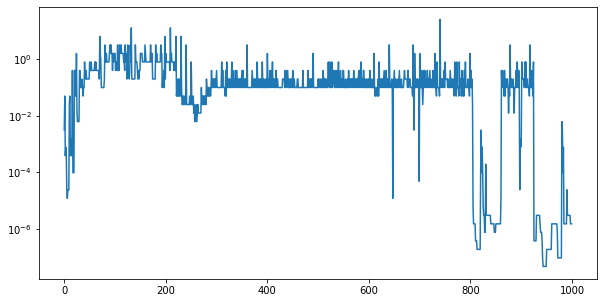

In [11]:
# Plot step size track
plt.figure(figsize=(10,5))
plt.semilogy(step_size_track)
print(max(step_size_track))

relative L1 error: 0.224327
relative L2 error: 0.409917


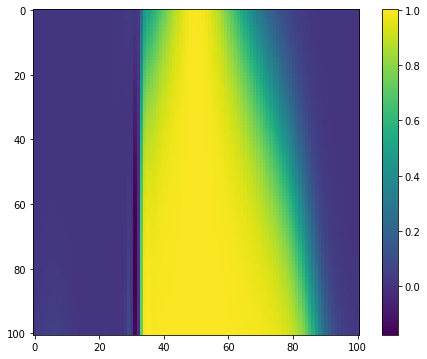

In [12]:
# Visualize PINNsformer
res_test = make_time_sequence(res_test, num_step=5, step=1e-4) 
res_test = torch.tensor(res_test, dtype=torch.float32, requires_grad=True).to(device)
x_test, t_test = res_test[:,:,0:1], res_test[:,:,1:2]

with torch.no_grad():
    pred = model(x_test, t_test)[:,0:1]
    pred = pred.cpu().detach().numpy()

pred = pred.reshape(101,101)

def h(x):
    return np.exp( - (x-np.pi)**2 / (2 * (np.pi/4)**2))

def u_ana(x,t):
    return h(x) * np.exp(5*t) / ( h(x) * np.exp(5*t) + 1 - h(x))

res_test, _, _, _, _ = get_data([0,2*np.pi], [0,1], 101, 101)
u = u_ana(res_test[:,0], res_test[:,1]).reshape(101,101)

rl1 = np.sum(np.abs(u-pred)) / np.sum(np.abs(u))
rl2 = np.sqrt(np.sum((u-pred)**2) / np.sum(u**2))

print('relative L1 error: {:4f}'.format(rl1))
print('relative L2 error: {:4f}'.format(rl2))

plt.figure(figsize=(8,6))
plt.imshow(pred)
plt.colorbar()
plt.show()